In [1]:
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn import datasets
from torch.backends import cudnn
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import torchvision as tv
from torch.utils.data import TensorDataset,DataLoader
import torchvision
import torchvision.datasets as Dataset
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm
import copy
import torchvision as tv
import cv2
from torch.utils.data import random_split
import pandas as pd
import os
from torch.utils.data import TensorDataset
import skimage.io as io
from tqdm import tqdm
from tensorboardX import SummaryWriter
from copy import deepcopy
import time
import sys
import torch
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from torch.optim.sgd import SGD
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
from collections import Counter
from sklearn.metrics import f1_score,precision_score,recall_score
class GradualWarmupScheduler(_LRScheduler):
    """ Gradually warm-up(increasing) learning rate in optimizer.
    Proposed in 'Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour'.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        multiplier: target learning rate = base lr * multiplier if multiplier > 1.0. if multiplier = 1.0, lr starts from 0 and ends up with the base_lr.
        total_epoch: target learning rate is reached at total_epoch, gradually
        after_scheduler: after target_epoch, use this scheduler(eg. ReduceLROnPlateau)
    """
 
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        self.multiplier = multiplier
        if self.multiplier < 1.:
            raise ValueError('multiplier should be greater thant or equal to 1.')
        self.total_epoch = total_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        super(GradualWarmupScheduler, self).__init__(optimizer)
 
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_last_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
 
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
 
    def step_ReduceLROnPlateau(self, metrics, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch if epoch != 0 else 1  # ReduceLROnPlateau is called at the end of epoch, whereas others are called at beginning
        if self.last_epoch <= self.total_epoch:
            warmup_lr = [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
            for param_group, lr in zip(self.optimizer.param_groups, warmup_lr):
                param_group['lr'] = lr
        else:
            if epoch is None:
                self.after_scheduler.step(metrics, None)
            else:
                self.after_scheduler.step(metrics, epoch - self.total_epoch)
 
    def step(self, epoch=None, metrics=None):
        if type(self.after_scheduler) != ReduceLROnPlateau:
            if self.finished and self.after_scheduler:
                if epoch is None:
                    self.after_scheduler.step(None)
                else:
                    self.after_scheduler.step(epoch - self.total_epoch)
                self._last_lr = self.after_scheduler.get_last_lr()
            else:
                return super(GradualWarmupScheduler, self).step(epoch)
        else:
            self.step_ReduceLROnPlateau(metrics, epoch)


In [3]:
camera1_train_ids = ['ID00'+str(i) for i in range(1,10)] + ['ID0'+str(i) for i in range(10,29)]
camera1_test_ids = ['ID00'+str(i) for i in range(1,4)]
camera2_train_ids = ['ID00'+str(i) for i in range(1,10)] + ['ID010']
camera2_test_ids = ['ID00'+str(i) for i in range(1,5)]

In [4]:
camera1_train_ids,camera1_test_ids,camera2_train_ids,camera2_test_ids

(['ID001',
  'ID002',
  'ID003',
  'ID004',
  'ID005',
  'ID006',
  'ID007',
  'ID008',
  'ID009',
  'ID010',
  'ID011',
  'ID012',
  'ID013',
  'ID014',
  'ID015',
  'ID016',
  'ID017',
  'ID018',
  'ID019',
  'ID020',
  'ID021',
  'ID022',
  'ID023',
  'ID024',
  'ID025',
  'ID026',
  'ID027',
  'ID028'],
 ['ID001', 'ID002', 'ID003'],
 ['ID001',
  'ID002',
  'ID003',
  'ID004',
  'ID005',
  'ID006',
  'ID007',
  'ID008',
  'ID009',
  'ID010'],
 ['ID001', 'ID002', 'ID003', 'ID004'])

In [5]:
globalpath1 = '../auc-v2-with-driver-id/v2_cam1_cam2_ split_by_driver/Camera 1'
globalpath2 = '../auc-v2-with-driver-id/v2_cam1_cam2_ split_by_driver/Camera 2'
filepath = ['/c0','/c1','/c2','/c3','/c4','/c5','/c6','/c7','/c8','/c9']

def getData(globalpath1,setname,ids,filepath,counter,tobefiltered=True):
    
    x = []
    y = []
    y2 = []
    for i,driverid in enumerate(ids):
        counter += 1
        idpath = globalpath1+'/'+setname+'/'+driverid
        for label,f in enumerate(filepath):
            if tobefiltered and driverid=='ID002' and label == 0:
                continue
            imgs = idpath+f
            for dirname, _, filenames in os.walk(imgs):

                for filename in filenames:
                    temppath = os.path.join(dirname, filename)
                    im_o = Image.open(temppath)
                    im_o = transforms.Resize([224,224])(im_o)
                    x.append(im_o)
                    y.append(label)
                    y2.append(counter)
    print(len(x),len(y))
    return x,y,y2,counter


counter = -1
trainx_1,trainy_1,trainy2_1,counter = getData(globalpath1,'train',camera1_train_ids,filepath,counter)
trainx_2,trainy_2,trainy2_2,counter = getData(globalpath2,'train',camera2_train_ids,filepath,counter,False)

10555 10555

2000 2000


In [6]:
from collections import Counter
Counter(trainy2_1),Counter(trainy2_2)

(Counter({0: 354,
          1: 252,
          2: 360,
          3: 303,
          4: 280,
          5: 461,
          6: 398,
          7: 420,
          8: 550,
          9: 358,
          10: 515,
          11: 269,
          12: 357,
          13: 400,
          14: 411,
          15: 445,
          16: 242,
          17: 346,
          18: 367,
          19: 427,
          20: 392,
          21: 531,
          22: 340,
          23: 352,
          24: 326,
          25: 381,
          26: 287,
          27: 431}),
 Counter({28: 200,
          29: 200,
          30: 200,
          31: 200,
          32: 200,
          33: 200,
          34: 200,
          35: 200,
          36: 200,
          37: 200}))

In [7]:
train_x = trainx_1 + trainx_2
train_y = trainy_1 + trainy_2
train_yid = trainy2_1 + trainy2_2

In [8]:
valid_driver_ids = [24,25,26,27,36,37]
trainset = [[train_x[i],train_y[i],train_yid[i]] for i in range(len(train_x)) if train_yid[i] not in valid_driver_ids]
validset = [[train_x[i],train_y[i],train_yid[i]] for i in range(len(train_x)) if train_yid[i] in valid_driver_ids]
len_train_subs = 38-6

In [9]:
globalpath1 = '../auc-distracted-driver-v2-train-valid-test/v2_cam1_cam2_ split_by_driver/Camera 1'
globalpath2 = '../auc-distracted-driver-v2-train-valid-test/v2_cam1_cam2_ split_by_driver/Camera 2'
filepath = ['/c0','/c1','/c2','/c3','/c4','/c5','/c6','/c7','/c8','/c9']

def getData(globalpath1,setname,filepath):
    counter = 0
    x = []
    y = []
    for idx,f in enumerate(filepath):
        
        imgs = globalpath1+'/'+setname+f
        for dirname, _, filenames in os.walk(imgs):
            
            for filename in filenames:
                temppath = os.path.join(dirname, filename)
                im_o = Image.open(temppath)
                im_o = transforms.Resize([224,224])(im_o)
                x.append(im_o)
                y.append(idx)
    print(len(x),len(y))
    return x,y

testx1,testy1 = getData(globalpath1,'test',filepath)
testx2,testy2 = getData(globalpath2,'test',filepath)

def getDataset(x1,y1,x2,y2):
    size = len(x1)
    outs = []
    for i in range(size):
        outs.append([x1[i],y1[i],0])
        
    size = len(x2)
    for i in range(size):
        outs.append([x2[i],y2[i],0])
    return outs
testset = getDataset(testx1,testy1,testx2,testy2)

test_len = len(testset)

1123 1123

800 800


In [10]:
train_len = len(trainset)
valid_len = len(validset)
test_len = len(testset)
train_all = train_len

In [11]:
train_len,valid_len,test_len,train_all

(10730, 1825, 1923, 10730)

In [12]:
#models with our Constrained Attention Mechanism
class MSFIN(nn.Module):
    def __init__(self):
        super(MSFIN,self).__init__()
        
        
        model = models.mobilenet_v2(pretrained=True)
        self.features = model.features
        self.fc = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=1280, out_features=10, bias=True)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        '''self.map = nn.Sequential(
            nn.Conv2d(1280,1280,1,bias = False)
        )'''
    def getGAP(self,f):
        return self.avgpool(f).squeeze(-1).squeeze(-1)
    def getCAM(self,preds,w,f):
        camlists = []
        a,b = preds.size()
        for i in range(a):
            idx = preds[i].argmax(-1)
            tempw = w[idx]
            tempf = f[i]
            c,d,e = tempf.size()
            tempf = tempw.unsqueeze(1).unsqueeze(1) * tempf
            tempf = tempf.sum(0)
            cam = tempf.reshape(-1)
            c,d = tempf.size()
            cam = tempf.reshape(-1)
            cam = (cam-cam.min())/(cam.max()-cam.min())
            cam = cam.reshape(d,e)
            camlists.append(cam)
        return torch.stack(camlists,0)
        
    def forward(self,x):
        
        f = self.features(x)
        avgf = self.getGAP(f)
        preds = self.fc(avgf)
        
        #calculating CAMs
        
        cam = f.unsqueeze(1) * self.fc[1].weight.unsqueeze(0).unsqueeze(3).unsqueeze(3)
        cams = cam.sum(2) + self.fc[1].bias.unsqueeze(0).unsqueeze(2).unsqueeze(2)
        a,b,c,d = cams.size()
        cams = cams.reshape(a,b,-1)
        cams = cams - cams.min(-1)[0].unsqueeze(-1)
        cams = cams / (cams.max(-1)[0].unsqueeze(-1)+ 1e-30)
        
        
        
        cams0 = cams.reshape(a*b,c*d)
        
        #Internal Constraint -> Concentrative Regularization
        N = 5
        topkv,topkp = cams0.topk(c*d,-1)
        loss1 = ((topkv[:,:N] - 1)**2).sum(-1)
        loss1 = ((topkv[:,N:] - 0)**2).sum(-1) + loss1
        loss1 = (loss1 / c / d).mean()

        #Internal Constraint -> Orthogonal Regularization
        temp = cams.unsqueeze(2) + cams.unsqueeze(1)
        eye = torch.triu(torch.ones(10,10)) - torch.eye(10)
        eye = eye.bool().cuda().unsqueeze(0).unsqueeze(3).expand(a,10,10,c*d)
        temp = temp[eye]
        loss3 = nn.ReLU()(temp-1).mean()
        
        #Intersample Constraint
        filtered_f = f.unsqueeze(1) * cams.reshape(a,10,c,d).unsqueeze(2)
        filtered_f = filtered_f.sum(-1).sum(-1) / c / d
        filtered_f = filtered_f.reshape(a,-1)
        co = F.cosine_similarity(filtered_f.unsqueeze(1),filtered_f.unsqueeze(0),-1)
        
        return preds,loss1,co,loss3

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

100%|██████████| 336/336 [00:45<00:00,  7.35it/s]


67.7688598036766 38.58204293996096


100%|██████████| 58/58 [00:02<00:00, 22.37it/s]


valid-f1: 0.6697957365018624

valid-precision: 0.7083389205365463

valid-recall: 0.6775230007040893

process: 0  loss: 3581.5040731430054  train_correct: 0.7095060577819199 valid_loss 55.87492952981847  val_correct: 0.6756164383561644


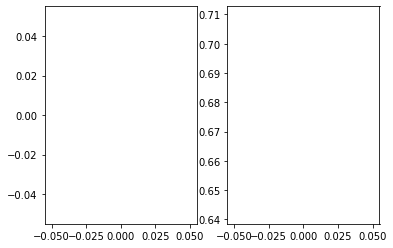

100%|██████████| 61/61 [00:02<00:00, 22.59it/s]


test-f1: 0.6883853200411634

test-precision: 0.7391016999680347

test-recall: 0.7084521080144985

The model has been saved!!

The best val_acc is  0.6756164383561644 The best test_acc is  0.6905876235049402


100%|██████████| 336/336 [00:38<00:00,  8.63it/s]


62.781526044011116 34.511391051113605


100%|██████████| 58/58 [00:02<00:00, 22.70it/s]


valid-f1: 0.6919956544706176

valid-precision: 0.7244209600226743

valid-recall: 0.7194956149936768

process: 1  loss: 1031.569458246231  train_correct: 0.9705498602050326 valid_loss 50.71208271847809  val_correct: 0.701917808219178


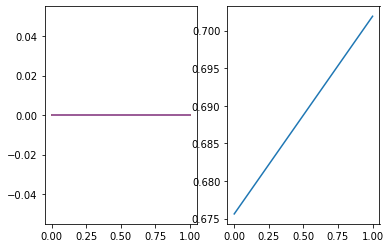

100%|██████████| 61/61 [00:02<00:00, 21.24it/s]


test-f1: 0.7066673140074093

test-precision: 0.7539362429911239

test-recall: 0.7197303987143762

The model has been saved!!

The best val_acc is  0.701917808219178 The best test_acc is  0.6931877275091004


100%|██████████| 336/336 [00:39<00:00,  8.60it/s]


55.32411815226078 29.520738437771797


100%|██████████| 58/58 [00:02<00:00, 22.56it/s]


valid-f1: 0.6887440514870179

valid-precision: 0.7516492479295354

valid-recall: 0.7207664488507316

process: 2  loss: 786.8418884277344  train_correct: 0.9895619757688723 valid_loss 56.158147003661725  val_correct: 0.7167123287671233


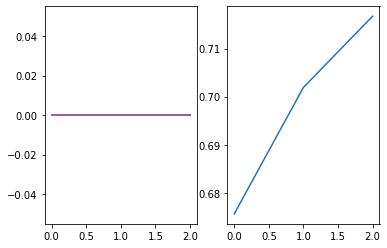

100%|██████████| 61/61 [00:02<00:00, 21.61it/s]


test-f1: 0.7277953037477591

test-precision: 0.7842519134089623

test-recall: 0.734406248696066

The model has been saved!!

The best val_acc is  0.7167123287671233 The best test_acc is  0.7243889755590224


100%|██████████| 336/336 [00:39<00:00,  8.60it/s]


48.27425056695938 25.119883462786674


100%|██████████| 58/58 [00:02<00:00, 22.62it/s]


valid-f1: 0.6587277214600101

valid-precision: 0.7582641481358036

valid-recall: 0.6509785456892115

process: 3  loss: 691.3379805088043  train_correct: 0.9956197576887232 valid_loss 82.78556318394476  val_correct: 0.6821917808219178


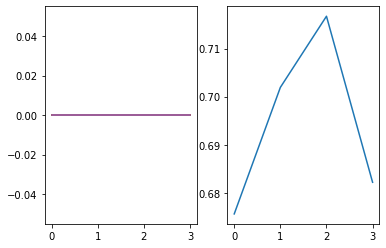

100%|██████████| 336/336 [00:39<00:00,  8.57it/s]


43.40741979330778 22.438097801059484


100%|██████████| 58/58 [00:02<00:00, 22.70it/s]


valid-f1: 0.723185617473588

valid-precision: 0.7732928763501787

valid-recall: 0.7209818671424284

process: 4  loss: 703.5343177318573  train_correct: 0.9920782851817335 valid_loss 58.784460192253505  val_correct: 0.7506849315068493


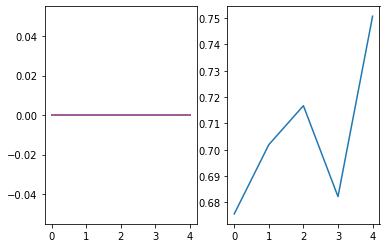

100%|██████████| 61/61 [00:02<00:00, 22.66it/s]


test-f1: 0.7802937797071355

test-precision: 0.8011841842099056

test-recall: 0.7727735791850386

The model has been saved!!

The best val_acc is  0.7506849315068493 The best test_acc is  0.7680707228289132


100%|██████████| 336/336 [00:39<00:00,  8.58it/s]


35.994021102786064 18.332403622567654


100%|██████████| 58/58 [00:02<00:00, 21.99it/s]


valid-f1: 0.7576466538946074

valid-precision: 0.7824496457077849

valid-recall: 0.7719881441944023

process: 5  loss: 583.8855639696121  train_correct: 0.9994408201304753 valid_loss 48.97609248169192  val_correct: 0.7873972602739726


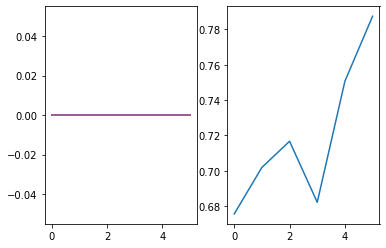

100%|██████████| 61/61 [00:02<00:00, 22.04it/s]


test-f1: 0.7999006506333961

test-precision: 0.8081417534335085

test-recall: 0.8027251825387829

The model has been saved!!

The best val_acc is  0.7873972602739726 The best test_acc is  0.7930317212688508


100%|██████████| 336/336 [00:39<00:00,  8.55it/s]


30.58744965493679 14.874226309359074


100%|██████████| 58/58 [00:02<00:00, 21.00it/s]


valid-f1: 0.7764657449715446

valid-precision: 0.7998785526098413

valid-recall: 0.7835171720325039

process: 6  loss: 554.0633484125137  train_correct: 0.9994408201304753 valid_loss 45.36685213118517  val_correct: 0.7983561643835616


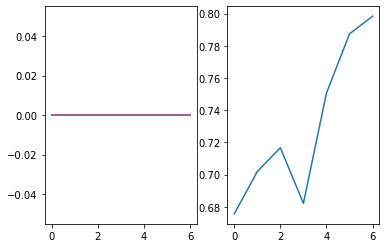

100%|██████████| 61/61 [00:02<00:00, 20.84it/s]


test-f1: 0.7931479936182395

test-precision: 0.8037685491160153

test-recall: 0.797572031426034

The model has been saved!!

The best val_acc is  0.7983561643835616 The best test_acc is  0.7836713468538742


100%|██████████| 336/336 [00:39<00:00,  8.60it/s]


26.346370689570904 12.125265138223767


100%|██████████| 58/58 [00:02<00:00, 22.26it/s]


valid-f1: 0.7638267267730958

valid-precision: 0.7867944823740224

valid-recall: 0.768482032045515

process: 7  loss: 535.5535910129547  train_correct: 0.9995340167753961 valid_loss 45.44705587973931  val_correct: 0.7852054794520548


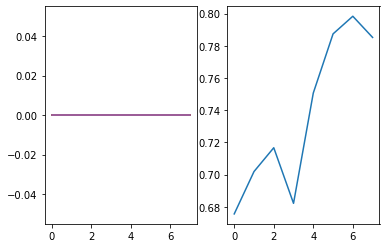

100%|██████████| 336/336 [00:38<00:00,  8.63it/s]


27.36792914569378 12.67686615884304


100%|██████████| 58/58 [00:02<00:00, 22.78it/s]


valid-f1: 0.6239243281193292

valid-precision: 0.7066973668649879

valid-recall: 0.6399997828562697

process: 8  loss: 736.1723273992538  train_correct: 0.9813606710158435 valid_loss 86.20715497141191  val_correct: 0.6186301369863013


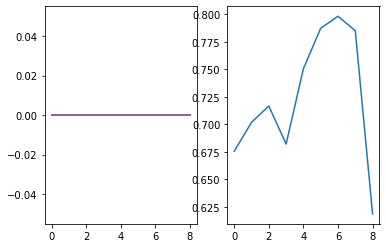

100%|██████████| 336/336 [00:39<00:00,  8.59it/s]


29.12609063833952 15.524071026593447


100%|██████████| 58/58 [00:02<00:00, 22.69it/s]


valid-f1: 0.6974552742330657

valid-precision: 0.7414623659982609

valid-recall: 0.7318841599527899

process: 9  loss: 694.6884331703186  train_correct: 0.9880708294501398 valid_loss 69.4230151645279  val_correct: 0.7375342465753425


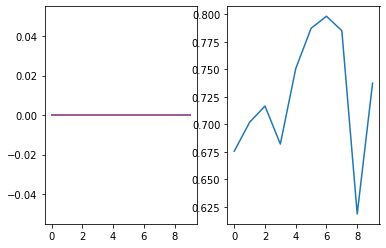

100%|██████████| 336/336 [00:39<00:00,  8.60it/s]


25.354040153324604 12.945199765264988


100%|██████████| 58/58 [00:02<00:00, 22.67it/s]


valid-f1: 0.7524872565494528

valid-precision: 0.7995069782243064

valid-recall: 0.751217922608884

process: 10  loss: 616.3145853877068  train_correct: 0.9924510717614166 valid_loss 55.66737249484959  val_correct: 0.770958904109589


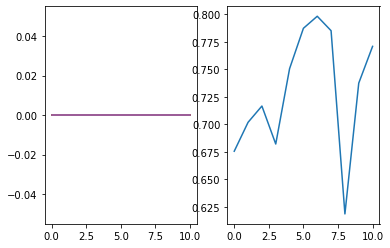

100%|██████████| 336/336 [00:38<00:00,  8.63it/s]


22.89675210043788 11.008983252570033


100%|██████████| 58/58 [00:02<00:00, 21.76it/s]


valid-f1: 0.7806535874286792

valid-precision: 0.7994017149428311

valid-recall: 0.7788508726000638

process: 11  loss: 549.0627992153168  train_correct: 0.9968313140726934 valid_loss 46.983377154099344  val_correct: 0.7884931506849315


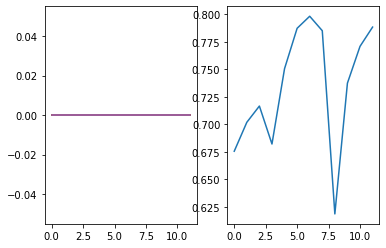

100%|██████████| 336/336 [00:39<00:00,  8.59it/s]


21.48887288942933 9.434515904635191


100%|██████████| 58/58 [00:02<00:00, 22.01it/s]


valid-f1: 0.8098117526554546

valid-precision: 0.8426199066496995

valid-recall: 0.8058470483253602

process: 12  loss: 513.3109896183014  train_correct: 0.9992544268406337 valid_loss 49.703098876540935  val_correct: 0.821917808219178


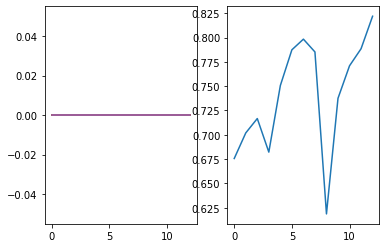

100%|██████████| 61/61 [00:02<00:00, 21.23it/s]


test-f1: 0.8088663255976922

test-precision: 0.8256462435897001

test-recall: 0.8050747777194722

The model has been saved!!

The best val_acc is  0.821917808219178 The best test_acc is  0.7987519500780031


100%|██████████| 336/336 [00:38<00:00,  8.62it/s]


20.586654782295227 8.116412941366434


100%|██████████| 58/58 [00:02<00:00, 21.81it/s]


valid-f1: 0.8112629852841113

valid-precision: 0.8514499794061997

valid-recall: 0.8045551198243508

process: 13  loss: 498.9702522754669  train_correct: 0.9998136067101584 valid_loss 47.5944182652338  val_correct: 0.8213698630136986


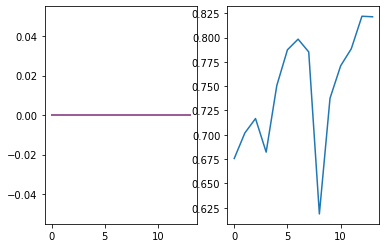

100%|██████████| 336/336 [00:39<00:00,  8.61it/s]


19.781003516167402 7.2779016979038715


100%|██████████| 58/58 [00:02<00:00, 22.53it/s]


valid-f1: 0.8197521672702818

valid-precision: 0.850354515318416

valid-recall: 0.8118253234872226

process: 14  loss: 489.8757108449936  train_correct: 0.9996272134203169 valid_loss 45.62850745036144  val_correct: 0.8284931506849315


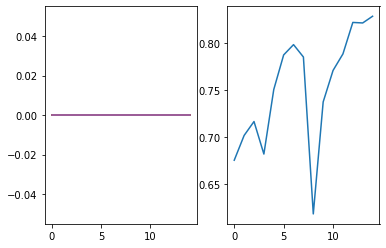

100%|██████████| 61/61 [00:02<00:00, 21.27it/s]


test-f1: 0.8034720162299929

test-precision: 0.8234671981680746

test-recall: 0.8034562348978909

The model has been saved!!

The best val_acc is  0.8284931506849315 The best test_acc is  0.7878315132605305


100%|██████████| 336/336 [00:39<00:00,  8.57it/s]


19.268644113093615 6.631040660664439


100%|██████████| 58/58 [00:02<00:00, 22.45it/s]


valid-f1: 0.8084398132503212

valid-precision: 0.846410814912651

valid-recall: 0.7984613826008776

process: 15  loss: 487.4961289167404  train_correct: 0.9996272134203169 valid_loss 50.93808006504787  val_correct: 0.8175342465753425


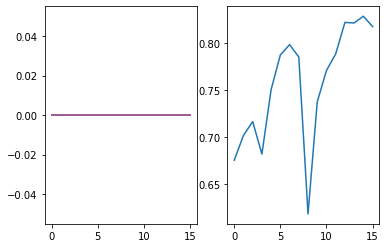

100%|██████████| 336/336 [00:39<00:00,  8.61it/s]


18.724441569298506 6.096863845363259


100%|██████████| 58/58 [00:02<00:00, 22.83it/s]


valid-f1: 0.8143332716572281

valid-precision: 0.8504110420514903

valid-recall: 0.803670313933648

process: 16  loss: 479.302738070488  train_correct: 0.9999068033550792 valid_loss 48.564494018135065  val_correct: 0.8213698630136986


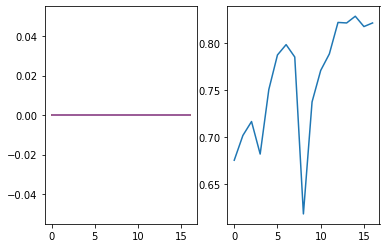

100%|██████████| 336/336 [00:39<00:00,  8.61it/s]


22.277764100581408 8.865623766556382


100%|██████████| 58/58 [00:02<00:00, 21.49it/s]


valid-f1: 0.7161092310114567

valid-precision: 0.7672585721810734

valid-recall: 0.7226753352234851

process: 17  loss: 736.3745669722557  train_correct: 0.9792171481826655 valid_loss 70.01452851731847  val_correct: 0.7331506849315068


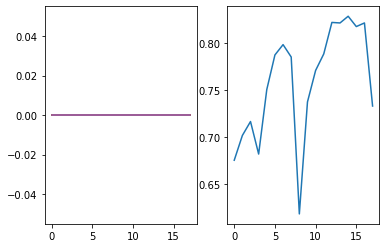

100%|██████████| 336/336 [00:39<00:00,  8.56it/s]


22.115175750106573 9.897152546793222


100%|██████████| 58/58 [00:02<00:00, 22.59it/s]


valid-f1: 0.8242054306839732

valid-precision: 0.8395147915731613

valid-recall: 0.8245126711706379

process: 18  loss: 632.9949090480804  train_correct: 0.9908667287977633 valid_loss 43.62086255410759  val_correct: 0.8241095890410959


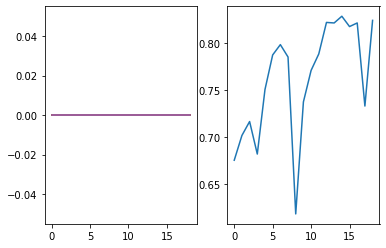

100%|██████████| 336/336 [00:39<00:00,  8.56it/s]


20.447584316134453 8.05219865962863


100%|██████████| 58/58 [00:02<00:00, 21.89it/s]


valid-f1: 0.8209067919831385

valid-precision: 0.8492407000534573

valid-recall: 0.8197293993698805

process: 19  loss: 534.5722961425781  train_correct: 0.9967381174277726 valid_loss 44.38371281318359  val_correct: 0.8339726027397261


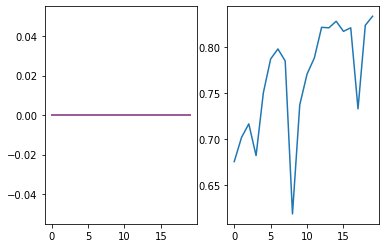

100%|██████████| 61/61 [00:02<00:00, 22.37it/s]


test-f1: 0.8187021912046243

test-precision: 0.8322472412413451

test-recall: 0.8177908157442308

The model has been saved!!

The best val_acc is  0.8339726027397261 The best test_acc is  0.8143525741029641


100%|██████████| 336/336 [00:39<00:00,  8.44it/s]


19.50197184830904 6.636816520243883


100%|██████████| 58/58 [00:02<00:00, 22.13it/s]


valid-f1: 0.84073893506671

valid-precision: 0.8623084091740811

valid-recall: 0.8383870533418427

process: 20  loss: 485.77652180194855  train_correct: 0.9994408201304753 valid_loss 42.27429537527178  val_correct: 0.8509589041095891


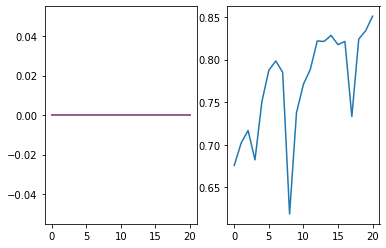

100%|██████████| 61/61 [00:02<00:00, 22.50it/s]


test-f1: 0.8265284807962127

test-precision: 0.8402142673174945

test-recall: 0.828327385170539

The model has been saved!!

The best val_acc is  0.8509589041095891 The best test_acc is  0.8148725949037962


100%|██████████| 336/336 [00:39<00:00,  8.56it/s]


18.597807202488184 5.969091579318047


100%|██████████| 58/58 [00:02<00:00, 22.54it/s]


valid-f1: 0.8300590597983923

valid-precision: 0.8595358289020496

valid-recall: 0.8268297448986841

process: 21  loss: 482.3546470403671  train_correct: 0.9995340167753961 valid_loss 47.687747667851  val_correct: 0.8334246575342465


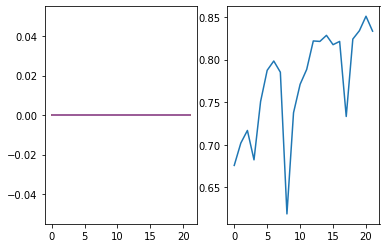

100%|██████████| 336/336 [00:39<00:00,  8.59it/s]


17.776652839034796 5.595519577153027


100%|██████████| 58/58 [00:02<00:00, 21.41it/s]


valid-f1: 0.8341908498119336

valid-precision: 0.8727369234558274

valid-recall: 0.8254484389353834

process: 22  loss: 475.60896223783493  train_correct: 0.9997204100652376 valid_loss 53.275051032443116  val_correct: 0.8443835616438357


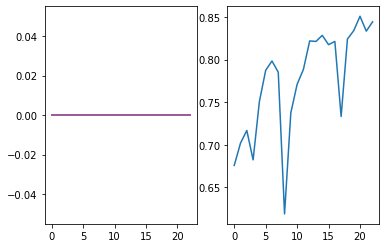

100%|██████████| 336/336 [00:39<00:00,  8.59it/s]


17.402994979172945 5.392028572037816


100%|██████████| 58/58 [00:02<00:00, 21.45it/s]


valid-f1: 0.8472494644630031

valid-precision: 0.8828396629625663

valid-recall: 0.8371994067866492

process: 23  loss: 474.9658943414688  train_correct: 0.9997204100652376 valid_loss 45.60593574523591  val_correct: 0.8547945205479452


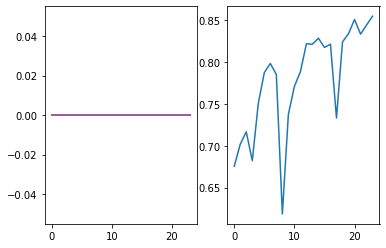

100%|██████████| 61/61 [00:02<00:00, 22.13it/s]


test-f1: 0.8379555393387272

test-precision: 0.8493985668010327

test-recall: 0.8356235562277508

The model has been saved!!

The best val_acc is  0.8547945205479452 The best test_acc is  0.8268330733229329


100%|██████████| 336/336 [00:39<00:00,  8.59it/s]


19.412520065903664 6.91947908885777


100%|██████████| 58/58 [00:02<00:00, 21.86it/s]


valid-f1: 0.6284016131373666

valid-precision: 0.7365887219145276

valid-recall: 0.6841552063629794

process: 24  loss: 649.5815731287003  train_correct: 0.9876980428704567 valid_loss 87.28624466783367  val_correct: 0.6991780821917808


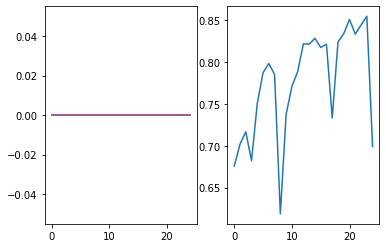

100%|██████████| 336/336 [00:39<00:00,  8.55it/s]


19.83007663860917 7.5836350955069065


100%|██████████| 58/58 [00:02<00:00, 21.17it/s]


valid-f1: 0.8198893578383372

valid-precision: 0.8431893440896575

valid-recall: 0.8187754625012748

process: 25  loss: 562.2726994752884  train_correct: 0.9946877912395153 valid_loss 44.723324794228574  val_correct: 0.8312328767123288


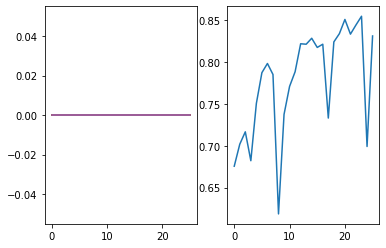

100%|██████████| 336/336 [00:39<00:00,  8.61it/s]


19.015539649873972 6.701936399564147


100%|██████████| 58/58 [00:02<00:00, 22.15it/s]


valid-f1: 0.7832933925028479

valid-precision: 0.8089982842130221

valid-recall: 0.7980239628376109

process: 26  loss: 548.9043949842453  train_correct: 0.9942218080149114 valid_loss 67.98499268614614  val_correct: 0.7775342465753424


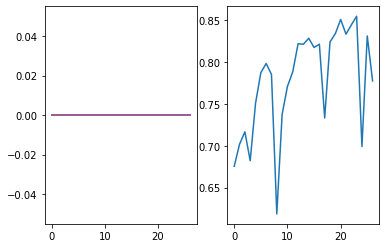

100%|██████████| 336/336 [00:39<00:00,  8.60it/s]


18.22978562489152 6.205144273117185


100%|██████████| 58/58 [00:02<00:00, 22.32it/s]


valid-f1: 0.7987433463269095

valid-precision: 0.8387749545680296

valid-recall: 0.7885390239126682

process: 27  loss: 541.4190810322762  train_correct: 0.9945945945945946 valid_loss 58.75009032659  val_correct: 0.806027397260274


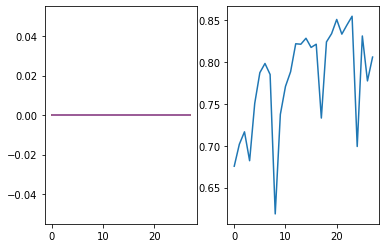

100%|██████████| 336/336 [00:39<00:00,  8.56it/s]


17.13671574369073 5.5045271115377545


100%|██████████| 58/58 [00:02<00:00, 21.21it/s]


valid-f1: 0.7986313091187724

valid-precision: 0.8425337412241717

valid-recall: 0.7978369755360202

process: 28  loss: 482.62096428871155  train_correct: 0.9990680335507922 valid_loss 60.63257782705932  val_correct: 0.821917808219178


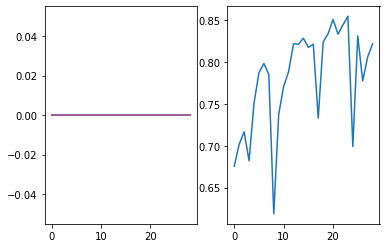

100%|██████████| 336/336 [00:39<00:00,  8.61it/s]


16.539251044392586 5.15878829266876


100%|██████████| 58/58 [00:02<00:00, 22.02it/s]


valid-f1: 0.8182127136230128

valid-precision: 0.835943407617792

valid-recall: 0.8179307524457998

process: 29  loss: 476.3767954111099  train_correct: 0.9992544268406337 valid_loss 51.48088862296163  val_correct: 0.8241095890410959


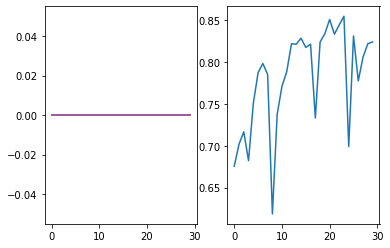

100%|██████████| 336/336 [00:39<00:00,  8.59it/s]


15.896086744964123 4.92012083157897


100%|██████████| 58/58 [00:02<00:00, 21.38it/s]


valid-f1: 0.8187243856565856

valid-precision: 0.8458757566897628

valid-recall: 0.8093845798124966

process: 30  loss: 466.1000556945801  train_correct: 0.9996272134203169 valid_loss 53.10549447930043  val_correct: 0.8317808219178082


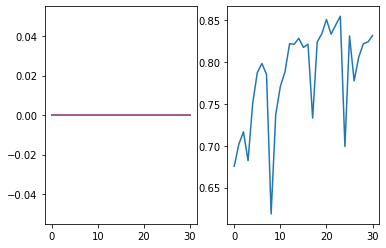

100%|██████████| 336/336 [00:39<00:00,  8.59it/s]


15.481489144265652 4.740304368548095


100%|██████████| 58/58 [00:02<00:00, 21.92it/s]


valid-f1: 0.8135590527245645

valid-precision: 0.8371170074304256

valid-recall: 0.806360199660754

process: 31  loss: 463.56179094314575  train_correct: 0.9997204100652376 valid_loss 53.36309751884164  val_correct: 0.8268493150684931


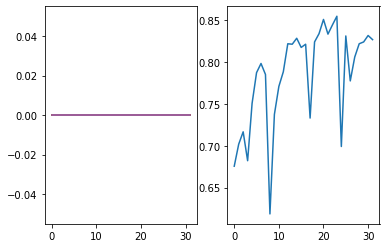

100%|██████████| 336/336 [00:39<00:00,  8.55it/s]


15.068192284554243 4.631447743624449


100%|██████████| 58/58 [00:02<00:00, 22.61it/s]


valid-f1: 0.7890322701842738

valid-precision: 0.8047140598272605

valid-recall: 0.7917207485820239

process: 32  loss: 461.03617560863495  train_correct: 1.0 valid_loss 57.381227308989764  val_correct: 0.7923287671232877


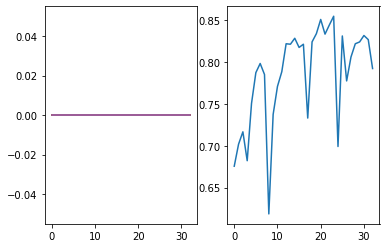

100%|██████████| 336/336 [00:38<00:00,  8.62it/s]


16.553216952830553 5.6235096314921975


100%|██████████| 58/58 [00:02<00:00, 22.60it/s]


valid-f1: 0.660050207643416

valid-precision: 0.7077379166490967

valid-recall: 0.6697506644646317

process: 33  loss: 564.0200451612473  train_correct: 0.9928238583410998 valid_loss 93.49618783839514  val_correct: 0.6953424657534246


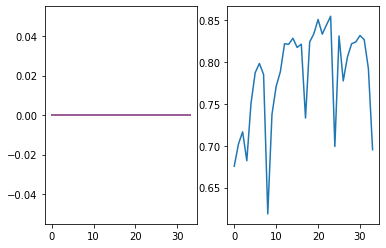

100%|██████████| 336/336 [00:39<00:00,  8.53it/s]


19.431264828890562 7.444780141115189


100%|██████████| 58/58 [00:02<00:00, 22.48it/s]


valid-f1: 0.7986518267871103

valid-precision: 0.8332615553480514

valid-recall: 0.8058955652226831

process: 34  loss: 628.1269122362137  train_correct: 0.9885368126747437 valid_loss 51.29499023401877  val_correct: 0.8164383561643835


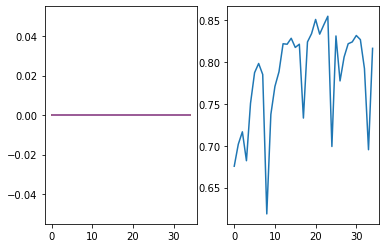

100%|██████████| 336/336 [00:39<00:00,  8.58it/s]


16.371732983738184 5.442259582690895


100%|██████████| 58/58 [00:02<00:00, 21.55it/s]


valid-f1: 0.7987193849010616

valid-precision: 0.8568166152227589

valid-recall: 0.7851458740972794

process: 35  loss: 491.91158068180084  train_correct: 0.9981360671015843 valid_loss 57.767874243734695  val_correct: 0.8180821917808219


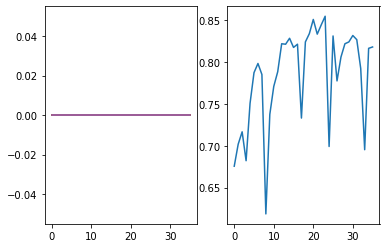

100%|██████████| 336/336 [00:39<00:00,  8.59it/s]


15.459939990192652 4.870615077205002


100%|██████████| 58/58 [00:02<00:00, 19.76it/s]


valid-f1: 0.805510701725842

valid-precision: 0.8463016371648134

valid-recall: 0.7929711039726149

process: 36  loss: 466.40857195854187  train_correct: 0.9998136067101584 valid_loss 55.98833463585834  val_correct: 0.8235616438356165


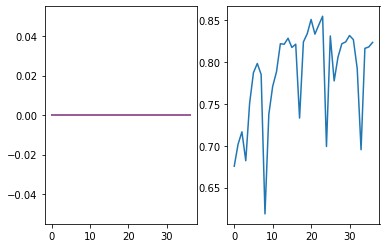

100%|██████████| 336/336 [00:39<00:00,  8.57it/s]


14.879862815141678 4.660635012201965


100%|██████████| 58/58 [00:02<00:00, 22.48it/s]


valid-f1: 0.8102770075489115

valid-precision: 0.8496770674878158

valid-recall: 0.7984259665264763

process: 37  loss: 459.8809028863907  train_correct: 1.0 valid_loss 55.87329165686242  val_correct: 0.8246575342465754


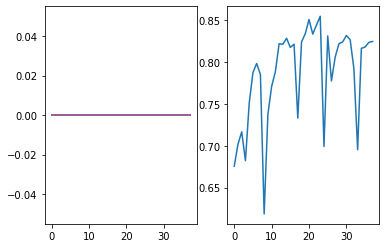

100%|██████████| 336/336 [00:39<00:00,  8.57it/s]


14.521469477564096 4.548819939605892


100%|██████████| 58/58 [00:02<00:00, 22.13it/s]


valid-f1: 0.7339536974278108

valid-precision: 0.7888675689729945

valid-recall: 0.7265801922462791

process: 38  loss: 464.1807931661606  train_correct: 0.9996272134203169 valid_loss 84.83405422397891  val_correct: 0.7347945205479453


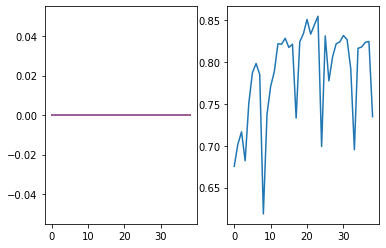

100%|██████████| 336/336 [00:39<00:00,  8.58it/s]


16.37232507020235 5.745012616738677


100%|██████████| 58/58 [00:02<00:00, 21.51it/s]


valid-f1: 0.7867680596114848

valid-precision: 0.8209390018669005

valid-recall: 0.7847396671252269

process: 39  loss: 593.4968417882919  train_correct: 0.9917986952469711 valid_loss 57.53349449278903  val_correct: 0.8071232876712329


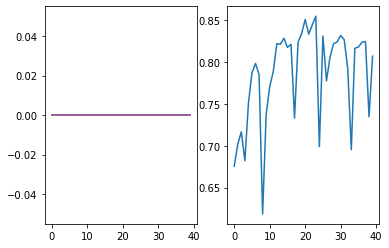

100%|██████████| 336/336 [00:39<00:00,  8.55it/s]


15.950488947331905 5.3941746624186635


100%|██████████| 58/58 [00:02<00:00, 22.59it/s]


valid-f1: 0.766620094929124

valid-precision: 0.8199689639137139

valid-recall: 0.7523517029562595

process: 40  loss: 546.4170281887054  train_correct: 0.994408201304753 valid_loss 66.42271072311996  val_correct: 0.7857534246575343


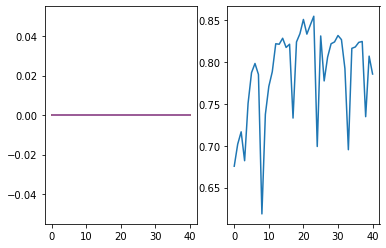

100%|██████████| 336/336 [00:39<00:00,  8.60it/s]


15.359291888773441 4.841211833059788


100%|██████████| 58/58 [00:02<00:00, 21.85it/s]


valid-f1: 0.7953573761256612

valid-precision: 0.8045529834419807

valid-recall: 0.7979422855328886

process: 41  loss: 472.59534227848053  train_correct: 0.9995340167753961 valid_loss 57.97517184241951  val_correct: 0.8076712328767123


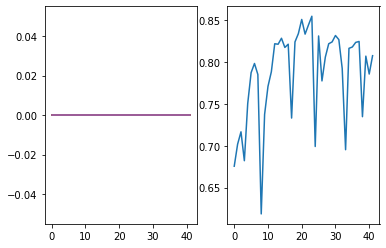

100%|██████████| 336/336 [00:39<00:00,  8.55it/s]


14.55246889963746 4.445435066707432


100%|██████████| 58/58 [00:02<00:00, 20.45it/s]


valid-f1: 0.8187024637977173

valid-precision: 0.828308661603589

valid-recall: 0.8175562186568428

process: 42  loss: 463.89467895030975  train_correct: 0.9997204100652376 valid_loss 59.83214990654051  val_correct: 0.8317808219178082


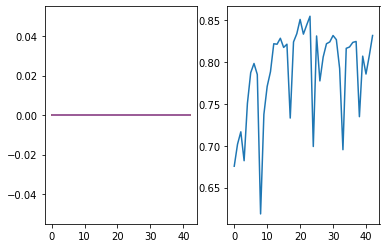

100%|██████████| 336/336 [00:39<00:00,  8.53it/s]


14.23628756031394 4.313906370662153


100%|██████████| 58/58 [00:02<00:00, 21.53it/s]


valid-f1: 0.8219034832946512

valid-precision: 0.8378011880771856

valid-recall: 0.8157055113705269

process: 43  loss: 462.0942829847336  train_correct: 0.9999068033550792 valid_loss 59.95424417057802  val_correct: 0.8372602739726027


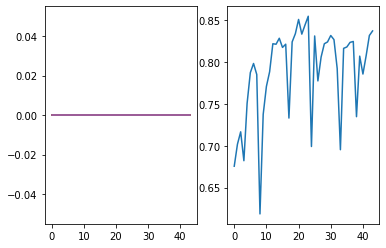

100%|██████████| 336/336 [00:39<00:00,  8.51it/s]


13.777153570204973 4.2296456741169095


100%|██████████| 58/58 [00:02<00:00, 22.00it/s]


valid-f1: 0.7651587825416313

valid-precision: 0.7895681101517186

valid-recall: 0.7707977255841748

process: 44  loss: 462.5229253768921  train_correct: 0.9997204100652376 valid_loss 78.11733090266944  val_correct: 0.7665753424657534


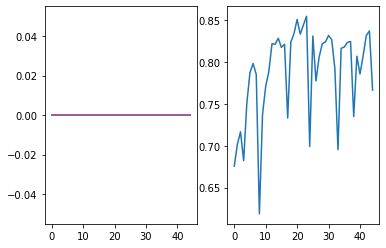

100%|██████████| 336/336 [00:39<00:00,  8.54it/s]


16.745873227715492 6.1431082878261805


100%|██████████| 58/58 [00:02<00:00, 22.18it/s]


valid-f1: 0.7782170453605596

valid-precision: 0.7966325754751641

valid-recall: 0.7799482148141657

process: 45  loss: 613.8575013875961  train_correct: 0.9894687791239516 valid_loss 65.16491006360593  val_correct: 0.795068493150685


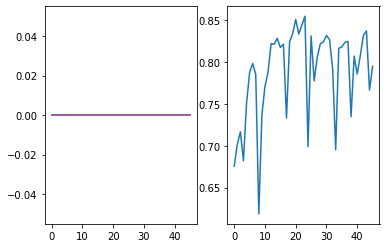

100%|██████████| 336/336 [00:39<00:00,  8.56it/s]


14.548814192414284 4.514893074519932


100%|██████████| 58/58 [00:02<00:00, 22.52it/s]


valid-f1: 0.8244866147661016

valid-precision: 0.8394011056697941

valid-recall: 0.8286145425221866

process: 46  loss: 473.60698413848877  train_correct: 0.9991612301957129 valid_loss 60.151923363451715  val_correct: 0.8361643835616438


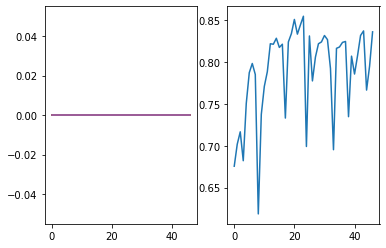

100%|██████████| 336/336 [00:39<00:00,  8.59it/s]


13.99015810340643 4.183121689595282


100%|██████████| 58/58 [00:02<00:00, 22.03it/s]


valid-f1: 0.8052343185074029

valid-precision: 0.8194580493073345

valid-recall: 0.8149670295538959

process: 47  loss: 463.8979449272156  train_correct: 0.9995340167753961 valid_loss 65.98175009699116  val_correct: 0.8076712328767123


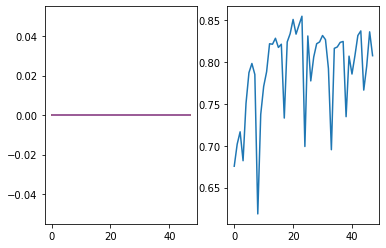

100%|██████████| 336/336 [00:39<00:00,  8.58it/s]


13.764096304774284 4.03310121409595


100%|██████████| 58/58 [00:02<00:00, 20.76it/s]


valid-f1: 0.8238583812617062

valid-precision: 0.8367480670847034

valid-recall: 0.8263699262400206

process: 48  loss: 459.3500187397003  train_correct: 0.9998136067101584 valid_loss 59.1674892331248  val_correct: 0.8328767123287671


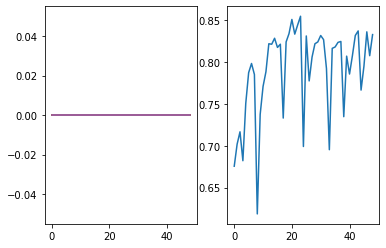

100%|██████████| 336/336 [00:39<00:00,  8.54it/s]


13.380329377949238 3.9591831490397453


100%|██████████| 58/58 [00:02<00:00, 22.48it/s]


valid-f1: 0.824482635605104

valid-precision: 0.8400040229856277

valid-recall: 0.8254204316315302

process: 49  loss: 457.39451038837433  train_correct: 0.9998136067101584 valid_loss 60.2357850783319  val_correct: 0.8323287671232876


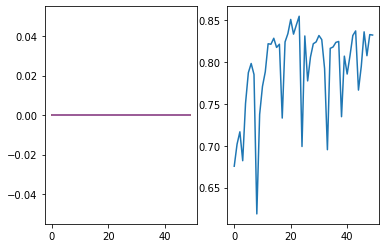

100%|██████████| 336/336 [00:39<00:00,  8.60it/s]


68.20555210113525 39.290391601622105


100%|██████████| 58/58 [00:02<00:00, 22.64it/s]


valid-f1: 0.7032132802353411

valid-precision: 0.7606263356374968

valid-recall: 0.7121662130590629

process: 0  loss: 3211.692707300186  train_correct: 0.7548928238583411 valid_loss 50.29662718261534  val_correct: 0.7139726027397261


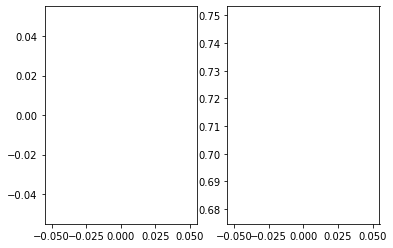

100%|██████████| 61/61 [00:02<00:00, 21.81it/s]


test-f1: 0.6432819983715448

test-precision: 0.7046352230825134

test-recall: 0.6483620325024061

The model has been saved!!

The best val_acc is  0.7139726027397261 The best test_acc is  0.6354654186167447


100%|██████████| 336/336 [00:39<00:00,  8.55it/s]


61.38596987724304 33.50087873637676


100%|██████████| 58/58 [00:02<00:00, 22.12it/s]


valid-f1: 0.7775156100198204

valid-precision: 0.7966908458153611

valid-recall: 0.7851245454541707

process: 1  loss: 995.7564473152161  train_correct: 0.9742777260018639 valid_loss 39.461447077730554  val_correct: 0.793972602739726


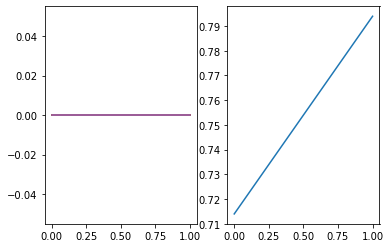

100%|██████████| 61/61 [00:02<00:00, 21.62it/s]


test-f1: 0.6703441677298669

test-precision: 0.6951104866798705

test-recall: 0.6768767849786685

The model has been saved!!

The best val_acc is  0.793972602739726 The best test_acc is  0.6547061882475299


100%|██████████| 336/336 [00:39<00:00,  8.60it/s]


51.886780470609665 27.6468435972929


100%|██████████| 58/58 [00:02<00:00, 22.59it/s]


valid-f1: 0.783175916409723

valid-precision: 0.8171947380742092

valid-recall: 0.7970010619367407

process: 2  loss: 804.6096551418304  train_correct: 0.9880708294501398 valid_loss 41.83491343104106  val_correct: 0.7994520547945205


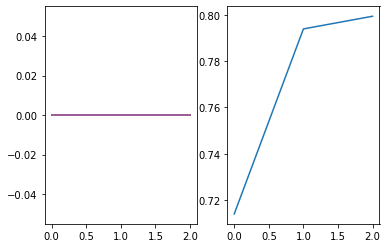

100%|██████████| 61/61 [00:02<00:00, 21.77it/s]


test-f1: 0.7359501294094648

test-precision: 0.7456746705505591

test-recall: 0.7477232820372006

The model has been saved!!

The best val_acc is  0.7994520547945205 The best test_acc is  0.7254290171606864


100%|██████████| 336/336 [00:39<00:00,  8.56it/s]


43.321234710514545 23.260874893516302


100%|██████████| 58/58 [00:02<00:00, 22.14it/s]


valid-f1: 0.7123608084861239

valid-precision: 0.8123748386407701

valid-recall: 0.7367495434362188

process: 3  loss: 669.0546088218689  train_correct: 0.9963653308480894 valid_loss 67.7021473076129  val_correct: 0.7572602739726028


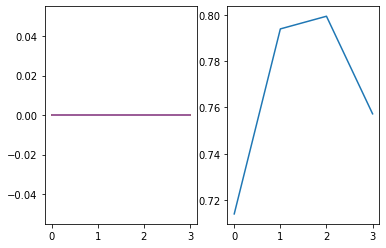

100%|██████████| 336/336 [00:40<00:00,  8.35it/s]


36.68580560386181 20.023998245596886


100%|██████████| 58/58 [00:02<00:00, 22.32it/s]


valid-f1: 0.7327553725051279

valid-precision: 0.7919901338111964

valid-recall: 0.7456090342905328

process: 4  loss: 640.6417638063431  train_correct: 0.9954333643988816 valid_loss 55.707940828033315  val_correct: 0.7621917808219179


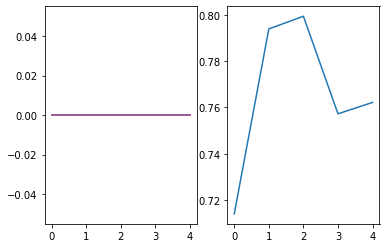

100%|██████████| 336/336 [00:39<00:00,  8.51it/s]


32.02120426297188 18.036291882395744


100%|██████████| 58/58 [00:02<00:00, 22.44it/s]


valid-f1: 0.8044238671649817

valid-precision: 0.8196543665859455

valid-recall: 0.8037340064160448

process: 5  loss: 623.7554862499237  train_correct: 0.9958061509785647 valid_loss 36.144843496742396  val_correct: 0.8202739726027397


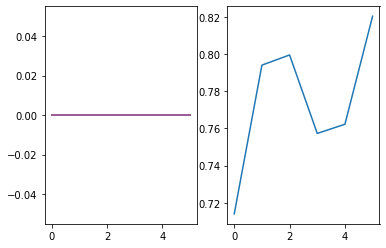

100%|██████████| 61/61 [00:02<00:00, 21.66it/s]


test-f1: 0.73453069896466

test-precision: 0.7728923253860318

test-recall: 0.7409559367664558

The model has been saved!!

The best val_acc is  0.8202739726027397 The best test_acc is  0.7254290171606864


100%|██████████| 336/336 [00:39<00:00,  8.53it/s]


26.80726858228445 14.456080175936222


100%|██████████| 58/58 [00:02<00:00, 21.61it/s]


valid-f1: 0.7260401941627532

valid-precision: 0.8010007351449339

valid-recall: 0.7247590785195237

process: 6  loss: 574.3654463291168  train_correct: 0.9970177073625349 valid_loss 61.997098793290206  val_correct: 0.7320547945205479


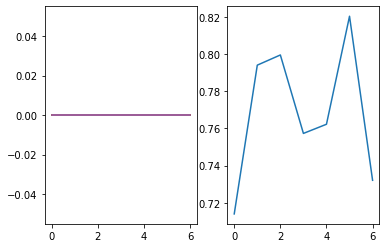

100%|██████████| 336/336 [00:39<00:00,  8.55it/s]


27.72478834539652 14.57198752835393


100%|██████████| 58/58 [00:02<00:00, 22.48it/s]


valid-f1: 0.7212938852006137

valid-precision: 0.8069992755677518

valid-recall: 0.7166507044610413

process: 7  loss: 659.9669771194458  train_correct: 0.9907735321528425 valid_loss 61.299861335636706  val_correct: 0.7473972602739726


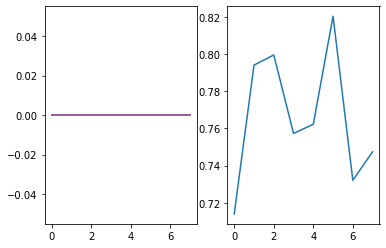

100%|██████████| 336/336 [00:39<00:00,  8.59it/s]


24.392313115298748 12.715570274740458


100%|██████████| 58/58 [00:02<00:00, 22.44it/s]


valid-f1: 0.804795054303171

valid-precision: 0.817264430014417

valid-recall: 0.8107036307590878

process: 8  loss: 589.3499011993408  train_correct: 0.9951537744641193 valid_loss 39.82655927298765  val_correct: 0.816986301369863


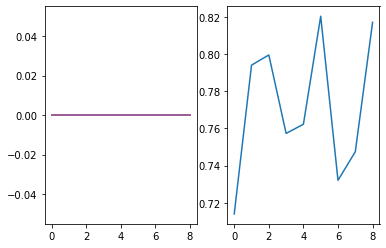

100%|██████████| 336/336 [00:39<00:00,  8.55it/s]


21.986120242625475 10.451370876282454


100%|██████████| 58/58 [00:02<00:00, 22.52it/s]


valid-f1: 0.7920887284628011

valid-precision: 0.8238405746762826

valid-recall: 0.8161604211475286

process: 9  loss: 526.138878941536  train_correct: 0.9988816402609506 valid_loss 50.91564942510013  val_correct: 0.7895890410958905


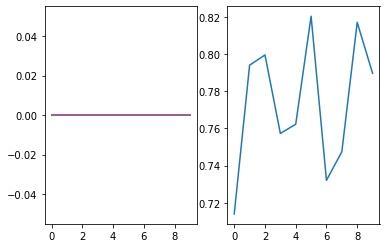

100%|██████████| 336/336 [00:39<00:00,  8.56it/s]


23.270092848688364 11.54955922625959


100%|██████████| 58/58 [00:02<00:00, 21.64it/s]


valid-f1: 0.7641471261512726

valid-precision: 0.7931622019401292

valid-recall: 0.7554765269848361

process: 10  loss: 673.4646805524826  train_correct: 0.9884436160298229 valid_loss 51.40644598932704  val_correct: 0.7819178082191781


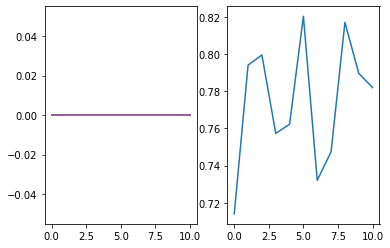

100%|██████████| 336/336 [00:39<00:00,  8.60it/s]


20.577146969735622 9.265749705955386


100%|██████████| 58/58 [00:02<00:00, 21.12it/s]


valid-f1: 0.7734172380281699

valid-precision: 0.8122423860291995

valid-recall: 0.7740427881450186

process: 11  loss: 514.2217118740082  train_correct: 0.9992544268406337 valid_loss 55.12332363672613  val_correct: 0.793972602739726


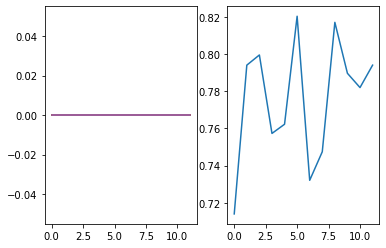

100%|██████████| 336/336 [00:39<00:00,  8.57it/s]


19.299621552228928 8.10096987709403


100%|██████████| 58/58 [00:02<00:00, 22.56it/s]


valid-f1: 0.8207843040772775

valid-precision: 0.8401108485419015

valid-recall: 0.8212035412217136

process: 12  loss: 500.15250527858734  train_correct: 0.9996272134203169 valid_loss 44.724865356191  val_correct: 0.8345205479452055


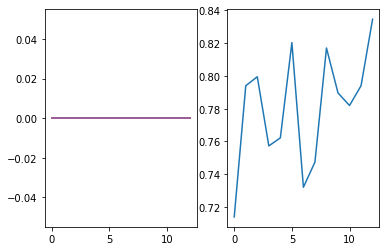

100%|██████████| 61/61 [00:03<00:00, 20.33it/s]


test-f1: 0.7740295786028284

test-precision: 0.7817358805721522

test-recall: 0.7826456426360855

The model has been saved!!

The best val_acc is  0.8345205479452055 The best test_acc is  0.7701508060322413


100%|██████████| 336/336 [00:39<00:00,  8.54it/s]


18.175214499235153 7.209841690957546


100%|██████████| 58/58 [00:02<00:00, 22.56it/s]


valid-f1: 0.8239857836909712

valid-precision: 0.841881004807418

valid-recall: 0.8242071205198632

process: 13  loss: 489.59719586372375  train_correct: 0.9997204100652376 valid_loss 44.79069992383302  val_correct: 0.8372602739726027


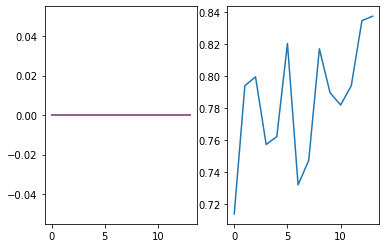

100%|██████████| 61/61 [00:02<00:00, 21.36it/s]


test-f1: 0.7788353459247791

test-precision: 0.78586699624475

test-recall: 0.79178152509267

The model has been saved!!

The best val_acc is  0.8372602739726027 The best test_acc is  0.7789911596463859


100%|██████████| 336/336 [00:39<00:00,  8.53it/s]


17.567652221769094 6.629324780777097


100%|██████████| 58/58 [00:02<00:00, 19.83it/s]


valid-f1: 0.8051736384510259

valid-precision: 0.8415405427794583

valid-recall: 0.8003551937605208

process: 14  loss: 488.56172931194305  train_correct: 0.9995340167753961 valid_loss 52.73006867332151  val_correct: 0.8191780821917808


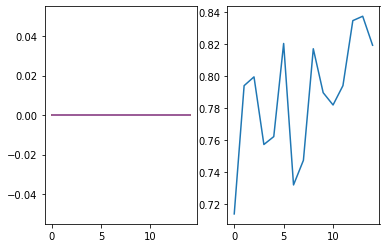

100%|██████████| 336/336 [00:39<00:00,  8.56it/s]


17.271077636629343 6.336093572899699


100%|██████████| 58/58 [00:02<00:00, 21.14it/s]


valid-f1: 0.8214353144284303

valid-precision: 0.8376301627256378

valid-recall: 0.8194744295231798

process: 15  loss: 482.04741060733795  train_correct: 0.9997204100652376 valid_loss 47.64781198021956  val_correct: 0.8367123287671233


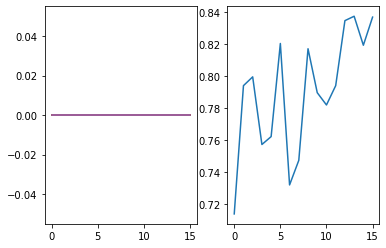

100%|██████████| 336/336 [00:39<00:00,  8.52it/s]


16.620126001536846 5.8035165555775166


100%|██████████| 58/58 [00:02<00:00, 21.54it/s]


valid-f1: 0.8303773821824876

valid-precision: 0.8487227472708296

valid-recall: 0.8286141101324478

process: 16  loss: 473.67853462696075  train_correct: 0.9997204100652376 valid_loss 46.54459915292682  val_correct: 0.8449315068493151


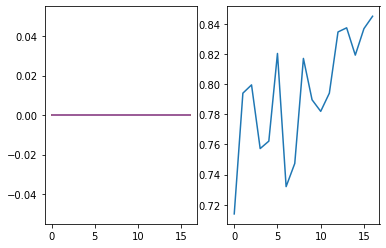

100%|██████████| 61/61 [00:02<00:00, 21.03it/s]


test-f1: 0.795342088158457

test-precision: 0.804450855416162

test-recall: 0.80437917371903

The model has been saved!!

The best val_acc is  0.8449315068493151 The best test_acc is  0.7945917836713469


100%|██████████| 336/336 [00:39<00:00,  8.53it/s]


16.21018049120903 5.536654086783528


100%|██████████| 58/58 [00:02<00:00, 22.05it/s]


valid-f1: 0.817315745188071

valid-precision: 0.8426125771232144

valid-recall: 0.812342119081617

process: 17  loss: 473.193430185318  train_correct: 0.9997204100652376 valid_loss 52.21244049481902  val_correct: 0.8306849315068493


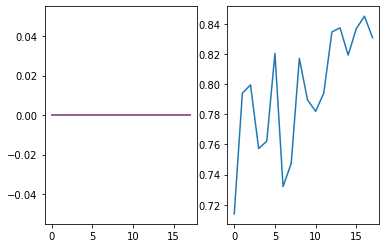

100%|██████████| 336/336 [00:39<00:00,  8.51it/s]


23.98569418489933 12.28062759898603


100%|██████████| 58/58 [00:03<00:00, 19.22it/s]


valid-f1: 0.7913637768930722

valid-precision: 0.840092847468593

valid-recall: 0.7897600579093199

process: 18  loss: 847.6754649877548  train_correct: 0.9741845293569431 valid_loss 50.94982380535657  val_correct: 0.8098630136986301


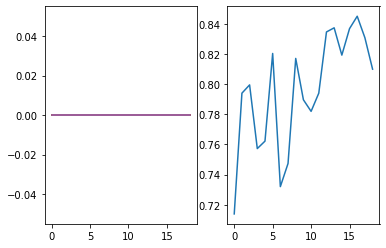

100%|██████████| 336/336 [00:39<00:00,  8.44it/s]


18.862214844673872 8.044120417907834


100%|██████████| 58/58 [00:02<00:00, 21.39it/s]


valid-f1: 0.8214990455016782

valid-precision: 0.8511226556455835

valid-recall: 0.8143942809612723

process: 19  loss: 574.4630968570709  train_correct: 0.9937558247903076 valid_loss 39.81016683107009  val_correct: 0.8372602739726027


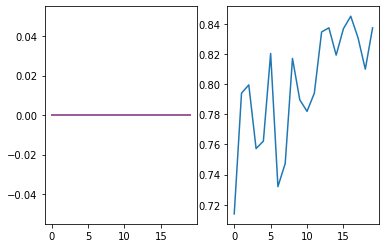

100%|██████████| 336/336 [00:39<00:00,  8.45it/s]


17.905267909169197 7.058166738599539


100%|██████████| 58/58 [00:02<00:00, 22.36it/s]


valid-f1: 0.8238953171589743

valid-precision: 0.851911724729921

valid-recall: 0.8208462048362675

process: 20  loss: 519.2408236265182  train_correct: 0.9972041006523765 valid_loss 45.07280430425453  val_correct: 0.8383561643835616


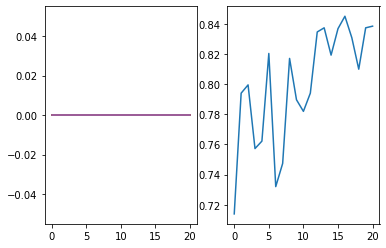

100%|██████████| 336/336 [00:39<00:00,  8.52it/s]


17.018764045089483 5.903400924988091


100%|██████████| 58/58 [00:02<00:00, 21.27it/s]


valid-f1: 0.8335016465920786

valid-precision: 0.865146198554186

valid-recall: 0.827662659768621

process: 21  loss: 473.7481401562691  train_correct: 0.9998136067101584 valid_loss 43.40314251076052  val_correct: 0.846027397260274


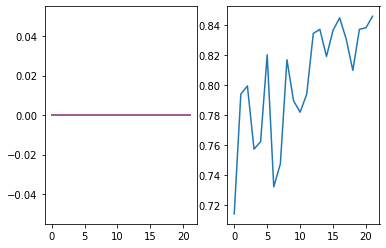

100%|██████████| 61/61 [00:02<00:00, 21.47it/s]


test-f1: 0.8116196691910528

test-precision: 0.8137552869726695

test-recall: 0.8203903109048568

The model has been saved!!

The best val_acc is  0.846027397260274 The best test_acc is  0.8060322412896516


100%|██████████| 336/336 [00:39<00:00,  8.54it/s]


16.335089821368456 5.505729232914746


100%|██████████| 58/58 [00:02<00:00, 22.04it/s]


valid-f1: 0.8439652356470667

valid-precision: 0.8662283858009138

valid-recall: 0.8417873979906159

process: 22  loss: 472.4359610080719  train_correct: 0.9997204100652376 valid_loss 42.016321294173395  val_correct: 0.856986301369863


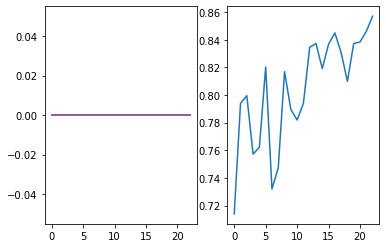

100%|██████████| 61/61 [00:02<00:00, 22.36it/s]


test-f1: 0.8052413019859637

test-precision: 0.8059198786131241

test-recall: 0.8201875459249589

The model has been saved!!

The best val_acc is  0.856986301369863 The best test_acc is  0.7987519500780031


100%|██████████| 336/336 [00:39<00:00,  8.52it/s]


15.968705423176289 5.27729690913111


100%|██████████| 58/58 [00:02<00:00, 22.47it/s]


valid-f1: 0.8324495329293156

valid-precision: 0.8502467613154879

valid-recall: 0.8332607320958008

process: 23  loss: 469.8301486968994  train_correct: 0.9998136067101584 valid_loss 43.99625178161841  val_correct: 0.846027397260274


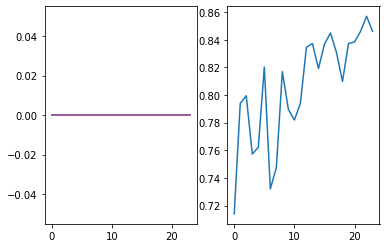

100%|██████████| 336/336 [00:39<00:00,  8.55it/s]


15.526096768677235 5.058677802793682


100%|██████████| 58/58 [00:02<00:00, 21.52it/s]


valid-f1: 0.8341273707634496

valid-precision: 0.8626151617937083

valid-recall: 0.8293289501000242

process: 24  loss: 465.0669609308243  train_correct: 1.0 valid_loss 46.18190959081767  val_correct: 0.8476712328767123


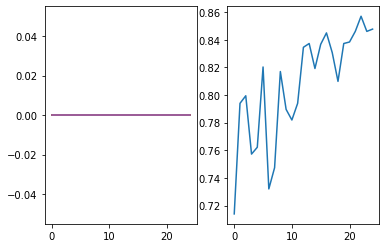

100%|██████████| 336/336 [00:39<00:00,  8.52it/s]


15.20334393158555 4.923645902425051


100%|██████████| 58/58 [00:02<00:00, 22.39it/s]


valid-f1: 0.8355156053746449

valid-precision: 0.8606665597495976

valid-recall: 0.8320161528773703

process: 25  loss: 461.68814730644226  train_correct: 1.0 valid_loss 46.087628241366474  val_correct: 0.8493150684931506


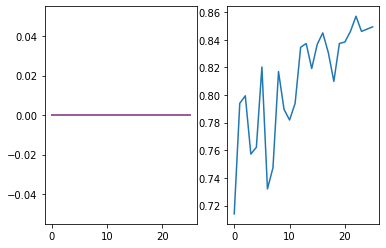

100%|██████████| 336/336 [00:39<00:00,  8.54it/s]


14.884803470224142 4.892988655716181


100%|██████████| 58/58 [00:02<00:00, 22.16it/s]


valid-f1: 0.8342664542705458

valid-precision: 0.8584394994774167

valid-recall: 0.8300534025356541

process: 26  loss: 460.91895043849945  train_correct: 1.0 valid_loss 47.795999076519365  val_correct: 0.8482191780821918


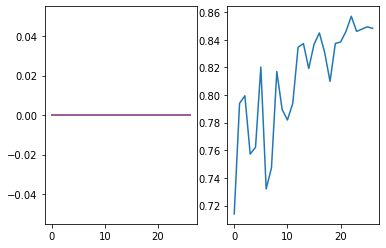

100%|██████████| 336/336 [00:39<00:00,  8.58it/s]


14.750334717333317 4.836454979144037


100%|██████████| 58/58 [00:02<00:00, 20.94it/s]


valid-f1: 0.836850211803337

valid-precision: 0.8636862021848785

valid-recall: 0.8326577682723064

process: 27  loss: 466.34244042634964  train_correct: 0.9998136067101584 valid_loss 48.09709836120601  val_correct: 0.8504109589041096


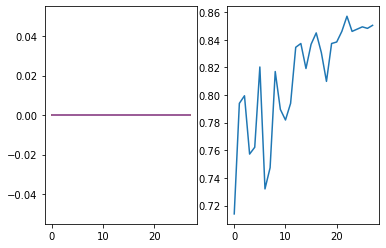

100%|██████████| 336/336 [00:40<00:00,  8.39it/s]


14.251336514949799 4.676262787543237


100%|██████████| 58/58 [00:02<00:00, 20.32it/s]


valid-f1: 0.8383937687717099

valid-precision: 0.8621481001342802

valid-recall: 0.8328462673722014

process: 28  loss: 459.7005604505539  train_correct: 0.9999068033550792 valid_loss 47.27416856423588  val_correct: 0.8504109589041096


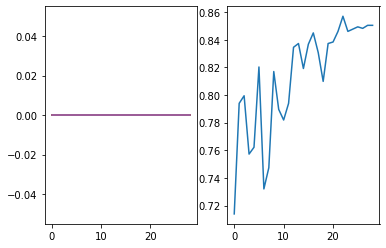

100%|██████████| 336/336 [00:40<00:00,  8.34it/s]


13.928279750049114 4.586008474230766


100%|██████████| 58/58 [00:02<00:00, 20.52it/s]


valid-f1: 0.8377492433928702

valid-precision: 0.8633962793058327

valid-recall: 0.8336557758152614

process: 29  loss: 460.4730814099312  train_correct: 0.9999068033550792 valid_loss 48.64615409235557  val_correct: 0.8515068493150685


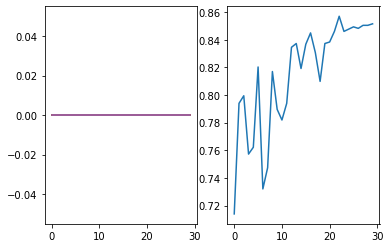

100%|██████████| 336/336 [00:39<00:00,  8.43it/s]


13.617649476975203 4.504850932396948


100%|██████████| 58/58 [00:02<00:00, 21.19it/s]


valid-f1: 0.8329721970474795

valid-precision: 0.8621985986924947

valid-recall: 0.8275830955723616

process: 30  loss: 458.83350694179535  train_correct: 0.9999068033550792 valid_loss 50.290060435276246  val_correct: 0.846027397260274


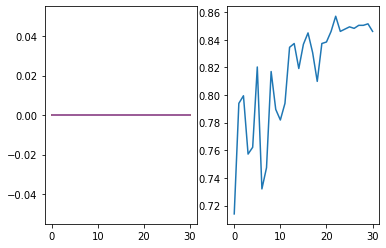

100%|██████████| 336/336 [00:39<00:00,  8.47it/s]


13.431994825601578 4.526387217454612


100%|██████████| 58/58 [00:02<00:00, 21.80it/s]


valid-f1: 0.828632305445822

valid-precision: 0.857948283144025

valid-recall: 0.824978466389636

process: 31  loss: 460.2570022344589  train_correct: 0.9998136067101584 valid_loss 53.489560886293475  val_correct: 0.8443835616438357


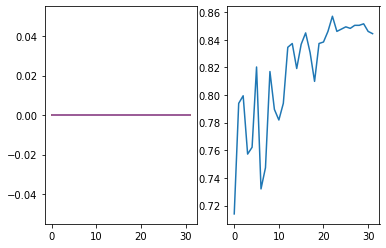

100%|██████████| 336/336 [00:39<00:00,  8.52it/s]


13.169603537768126 4.498714632354677


100%|██████████| 58/58 [00:02<00:00, 21.18it/s]


valid-f1: 0.8268519751035358

valid-precision: 0.8555482928811642

valid-recall: 0.8243455345284151

process: 32  loss: 458.16827523708344  train_correct: 0.9999068033550792 valid_loss 53.20769929241578  val_correct: 0.8416438356164384


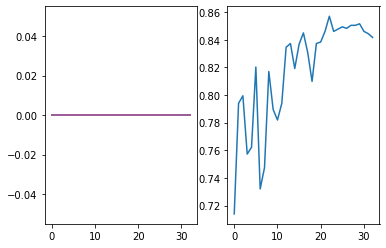

100%|██████████| 336/336 [00:39<00:00,  8.51it/s]


22.941620398312807 12.733316234312952


100%|██████████| 58/58 [00:02<00:00, 20.54it/s]


valid-f1: 0.7045110050932524

valid-precision: 0.7744015173604357

valid-recall: 0.6993003501651647

process: 33  loss: 908.8823914527893  train_correct: 0.9683131407269339 valid_loss 76.32911852987672  val_correct: 0.7468493150684932


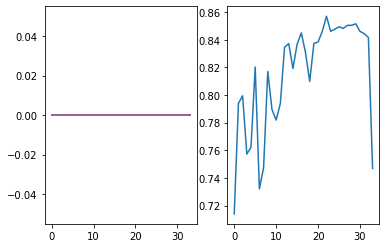

100%|██████████| 336/336 [00:39<00:00,  8.50it/s]


17.6473954282701 7.037009654566646


100%|██████████| 58/58 [00:02<00:00, 20.28it/s]


valid-f1: 0.7791560489083542

valid-precision: 0.8319086362894689

valid-recall: 0.7728182809657612

process: 34  loss: 536.6236147880554  train_correct: 0.9954333643988816 valid_loss 57.34965165879112  val_correct: 0.7978082191780822


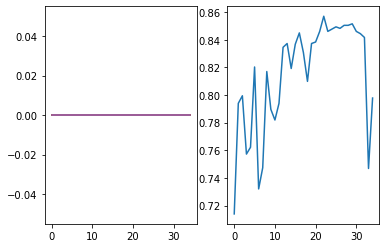

100%|██████████| 336/336 [00:39<00:00,  8.52it/s]


16.303784776479006 5.631956789642572


100%|██████████| 58/58 [00:02<00:00, 22.20it/s]


valid-f1: 0.7933491239879196

valid-precision: 0.8357865335913355

valid-recall: 0.7930212281474047

process: 35  loss: 502.72349894046783  train_correct: 0.9982292637465051 valid_loss 61.81318908887988  val_correct: 0.8131506849315069


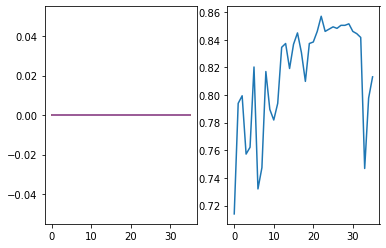

100%|██████████| 336/336 [00:39<00:00,  8.49it/s]


15.664466552436352 5.189876141026616


100%|██████████| 58/58 [00:02<00:00, 21.34it/s]


valid-f1: 0.7854704928386955

valid-precision: 0.827764730648531

valid-recall: 0.784338339959089

process: 36  loss: 522.5927286148071  train_correct: 0.9961789375582479 valid_loss 59.743113035503484  val_correct: 0.8043835616438356


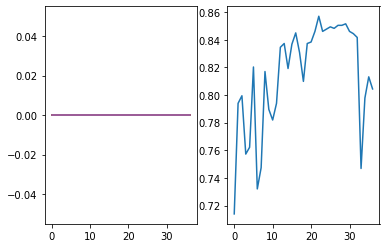

100%|██████████| 336/336 [00:39<00:00,  8.55it/s]


15.550574447959661 5.381768353283405


100%|██████████| 58/58 [00:02<00:00, 21.60it/s]


valid-f1: 0.79929462659074

valid-precision: 0.8451849948742032

valid-recall: 0.787201649171404

process: 37  loss: 523.0923992395401  train_correct: 0.9961789375582479 valid_loss 56.89623314458004  val_correct: 0.8158904109589041


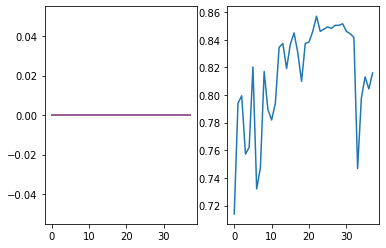

100%|██████████| 336/336 [00:39<00:00,  8.42it/s]


14.664356492459774 4.6918949438259006


100%|██████████| 58/58 [00:02<00:00, 21.91it/s]


valid-f1: 0.7902097440127693

valid-precision: 0.8344768969877009

valid-recall: 0.7764311995500195

process: 38  loss: 470.9384340643883  train_correct: 0.9995340167753961 valid_loss 64.42706984621691  val_correct: 0.8065753424657535


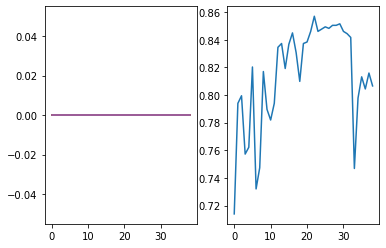

100%|██████████| 336/336 [00:39<00:00,  8.44it/s]


14.366704020649195 4.494333270005882


100%|██████████| 58/58 [00:02<00:00, 22.34it/s]


valid-f1: 0.8037294488744584

valid-precision: 0.8338380887192116

valid-recall: 0.8021051430508948

process: 39  loss: 462.50119292736053  train_correct: 0.9998136067101584 valid_loss 57.4650492179353  val_correct: 0.8175342465753425


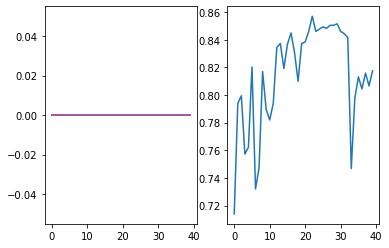

100%|██████████| 336/336 [00:39<00:00,  8.55it/s]


14.007947739213705 4.339084068313241


100%|██████████| 58/58 [00:02<00:00, 22.25it/s]


valid-f1: 0.8119827822981198

valid-precision: 0.8456256157582596

valid-recall: 0.8047676094631424

process: 40  loss: 459.43255484104156  train_correct: 1.0 valid_loss 56.700048744176456  val_correct: 0.8263013698630137


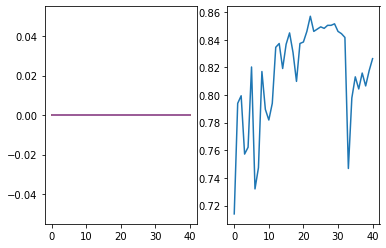

100%|██████████| 336/336 [00:39<00:00,  8.49it/s]


13.704775035381317 4.284600004553795


100%|██████████| 58/58 [00:02<00:00, 21.21it/s]


valid-f1: 0.8131381832487298

valid-precision: 0.849822299164504

valid-recall: 0.8048373560354977

process: 41  loss: 455.61252707242966  train_correct: 1.0 valid_loss 57.929447892543976  val_correct: 0.8284931506849315


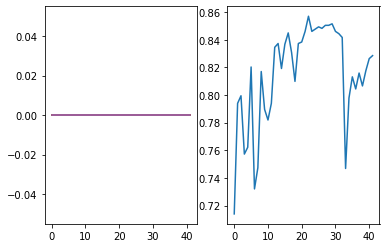

100%|██████████| 336/336 [00:39<00:00,  8.53it/s]


13.425586234778166 4.2322939448058605


100%|██████████| 58/58 [00:02<00:00, 22.34it/s]


valid-f1: 0.8166602155743924

valid-precision: 0.8524863962275175

valid-recall: 0.8073243387704935

process: 42  loss: 455.1706112623215  train_correct: 1.0 valid_loss 58.309590066506644  val_correct: 0.8306849315068493


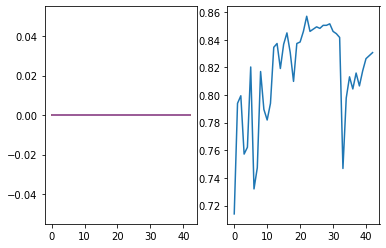

100%|██████████| 336/336 [00:39<00:00,  8.51it/s]


13.16160985454917 4.191548344679177


100%|██████████| 58/58 [00:02<00:00, 21.18it/s]


valid-f1: 0.814393397356516

valid-precision: 0.8506273516345235

valid-recall: 0.8048784215222551

process: 43  loss: 452.263524889946  train_correct: 1.0 valid_loss 59.17372438059101  val_correct: 0.829041095890411


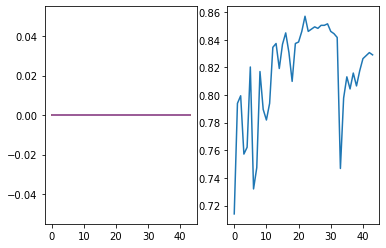

100%|██████████| 336/336 [00:39<00:00,  8.51it/s]


12.861750226467848 4.136808559298515


100%|██████████| 58/58 [00:03<00:00, 19.07it/s]


valid-f1: 0.8158277925576026

valid-precision: 0.8505678492477609

valid-recall: 0.8069920626776421

process: 44  loss: 453.57684803009033  train_correct: 1.0 valid_loss 58.67930985685962  val_correct: 0.8317808219178082


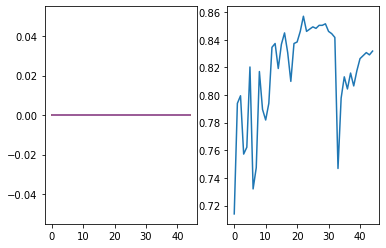

100%|██████████| 336/336 [00:39<00:00,  8.51it/s]


12.575583629310131 4.070675576105714


100%|██████████| 58/58 [00:02<00:00, 21.22it/s]


valid-f1: 0.8194325437072386

valid-precision: 0.854622939391987

valid-recall: 0.8096629584565006

process: 45  loss: 453.92698407173157  train_correct: 1.0 valid_loss 58.94544183202379  val_correct: 0.8339726027397261


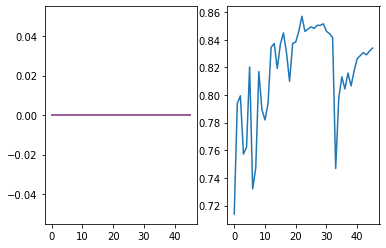

100%|██████████| 336/336 [00:39<00:00,  8.55it/s]


12.314733393490314 4.035180862993002


100%|██████████| 58/58 [00:02<00:00, 21.97it/s]


valid-f1: 0.8174745738553024

valid-precision: 0.8518813555658398

valid-recall: 0.807328359235521

process: 46  loss: 452.2369418144226  train_correct: 1.0 valid_loss 59.198216861834226  val_correct: 0.8312328767123288


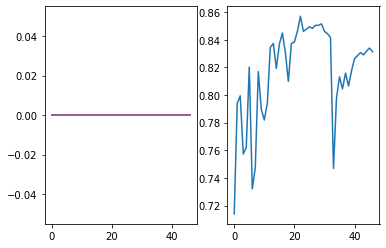

100%|██████████| 336/336 [00:39<00:00,  8.47it/s]


12.071732766926289 3.9990210495889187


100%|██████████| 58/58 [00:02<00:00, 21.73it/s]


valid-f1: 0.816498743578653

valid-precision: 0.8507296445563318

valid-recall: 0.8070824886726236

process: 47  loss: 450.83911895751953  train_correct: 1.0 valid_loss 60.05231234742678  val_correct: 0.8312328767123288


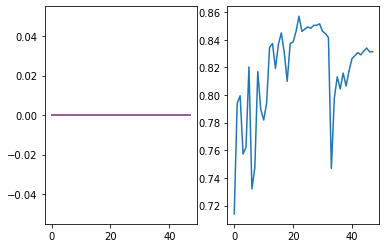

100%|██████████| 336/336 [00:39<00:00,  8.48it/s]


11.861101342365146 3.971061763353646


100%|██████████| 58/58 [00:02<00:00, 19.76it/s]


valid-f1: 0.8168553657748339

valid-precision: 0.8512696633128334

valid-recall: 0.8071978384506202

process: 48  loss: 451.84631645679474  train_correct: 1.0 valid_loss 61.127505537668185  val_correct: 0.8312328767123288


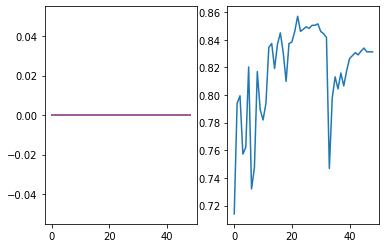

100%|██████████| 336/336 [00:39<00:00,  8.50it/s]


11.597742883488536 3.9457964450120926


100%|██████████| 58/58 [00:02<00:00, 22.34it/s]


valid-f1: 0.8188034630122806

valid-precision: 0.8531770314348419

valid-recall: 0.8076265672203459

process: 49  loss: 452.1119318008423  train_correct: 1.0 valid_loss 60.408157420661155  val_correct: 0.8317808219178082


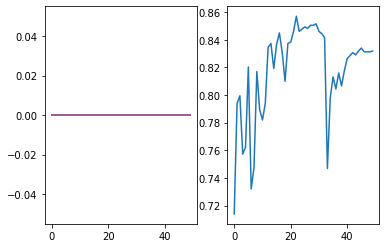

100%|██████████| 336/336 [00:39<00:00,  8.54it/s]


63.38697478175163 36.137273125350475


100%|██████████| 58/58 [00:02<00:00, 21.38it/s]


valid-f1: 0.6695707767618801

valid-precision: 0.7165538575151551

valid-recall: 0.6981175008900198

process: 0  loss: 3611.628185272217  train_correct: 0.6995340167753961 valid_loss 54.45983406765299  val_correct: 0.6915068493150685


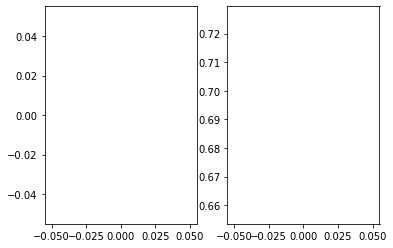

100%|██████████| 61/61 [00:02<00:00, 22.03it/s]


test-f1: 0.7363233206463413

test-precision: 0.7723678545647601

test-recall: 0.7427325126692039

The model has been saved!!

The best val_acc is  0.6915068493150685 The best test_acc is  0.734789391575663


100%|██████████| 336/336 [00:39<00:00,  8.55it/s]


60.614121332764626 33.13468059897423


100%|██████████| 58/58 [00:02<00:00, 21.21it/s]


valid-f1: 0.7223198663934941

valid-precision: 0.7866852785491389

valid-recall: 0.7353019333697476

process: 1  loss: 1086.697561264038  train_correct: 0.9669151910531221 valid_loss 47.47266587407648  val_correct: 0.7402739726027397


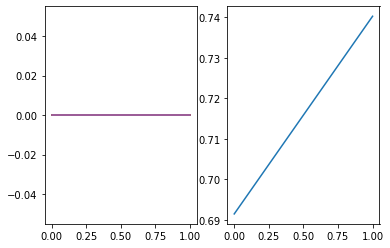

100%|██████████| 61/61 [00:03<00:00, 19.97it/s]


test-f1: 0.672273192357381

test-precision: 0.7561293644843158

test-recall: 0.662014909947192

The model has been saved!!

The best val_acc is  0.7402739726027397 The best test_acc is  0.65730629225169


100%|██████████| 336/336 [00:39<00:00,  8.52it/s]


53.639155626297 28.59222101420164


100%|██████████| 58/58 [00:02<00:00, 21.00it/s]


valid-f1: 0.7481992135980118

valid-precision: 0.8083571352993767

valid-recall: 0.7245665616537653

process: 2  loss: 785.8376361131668  train_correct: 0.9906803355079217 valid_loss 46.25847853157029  val_correct: 0.7561643835616438


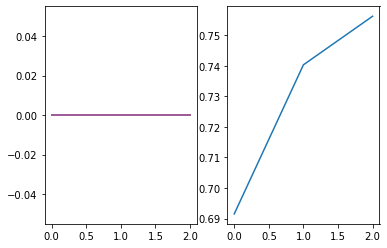

100%|██████████| 61/61 [00:02<00:00, 22.24it/s]


test-f1: 0.6909570431062662

test-precision: 0.7643341028735604

test-recall: 0.6836681872830217

The model has been saved!!

The best val_acc is  0.7561643835616438 The best test_acc is  0.6812272490899636


100%|██████████| 336/336 [00:39<00:00,  8.54it/s]


47.073907777667046 24.2473958209157


100%|██████████| 58/58 [00:02<00:00, 21.42it/s]


valid-f1: 0.8068184159631866

valid-precision: 0.829582284013321

valid-recall: 0.8019132352094214

process: 3  loss: 690.8328045606613  train_correct: 0.9958993476234855 valid_loss 33.987293312737165  val_correct: 0.812054794520548


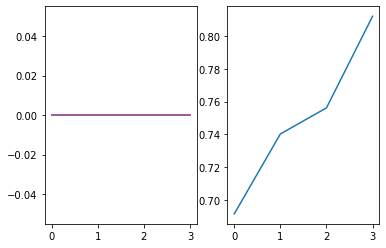

100%|██████████| 61/61 [00:02<00:00, 22.05it/s]


test-f1: 0.7097997491529613

test-precision: 0.7422357783004949

test-recall: 0.7182626856994678

The model has been saved!!

The best val_acc is  0.812054794520548 The best test_acc is  0.6994279771190848


100%|██████████| 336/336 [00:39<00:00,  8.48it/s]


42.11117868870497 21.71526451036334


100%|██████████| 58/58 [00:02<00:00, 20.14it/s]


valid-f1: 0.7841862435296901

valid-precision: 0.8074625618415828

valid-recall: 0.7878087472332348

process: 4  loss: 667.0410430431366  train_correct: 0.9958993476234855 valid_loss 41.95332838076865  val_correct: 0.8010958904109589


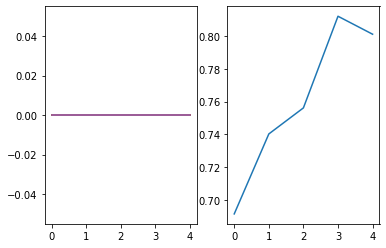

100%|██████████| 336/336 [00:40<00:00,  8.38it/s]


37.09345904737711 18.676665499806404


100%|██████████| 58/58 [00:02<00:00, 22.34it/s]


valid-f1: 0.7496244394825453

valid-precision: 0.7782371639792007

valid-recall: 0.7583990908773608

process: 5  loss: 632.7890125513077  train_correct: 0.9964585274930102 valid_loss 44.924213621459785  val_correct: 0.7621917808219179


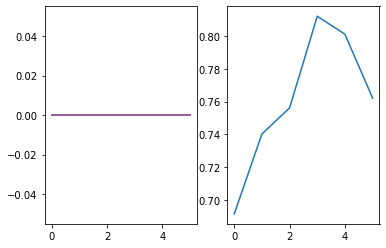

100%|██████████| 336/336 [00:39<00:00,  8.45it/s]


37.143932692706585 19.342874754220247


100%|██████████| 58/58 [00:02<00:00, 21.77it/s]


valid-f1: 0.7055757313723493

valid-precision: 0.7667871554071831

valid-recall: 0.6938240244811326

process: 6  loss: 733.5708873271942  train_correct: 0.9865796831314073 valid_loss 70.6802667573429  val_correct: 0.7194520547945206


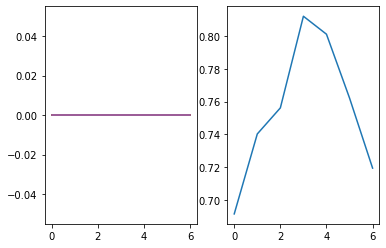

100%|██████████| 336/336 [00:39<00:00,  8.49it/s]


32.205947779119015 17.137016650289297


100%|██████████| 58/58 [00:02<00:00, 21.11it/s]


valid-f1: 0.761886878616066

valid-precision: 0.7950039171612959

valid-recall: 0.748268830562434

process: 7  loss: 623.6731516122818  train_correct: 0.9949673811742777 valid_loss 56.37535987513638  val_correct: 0.7726027397260274


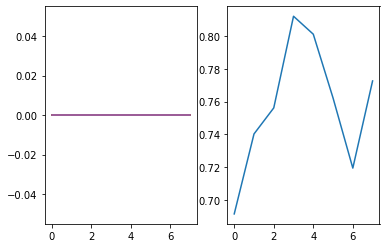

100%|██████████| 336/336 [00:39<00:00,  8.48it/s]


28.824994400143623 14.98578156530857


100%|██████████| 58/58 [00:02<00:00, 19.38it/s]


valid-f1: 0.7931319599348724

valid-precision: 0.8156325872146224

valid-recall: 0.7851707760388893

process: 8  loss: 583.5764305591583  train_correct: 0.9970177073625349 valid_loss 44.473615673632594  val_correct: 0.8032876712328767


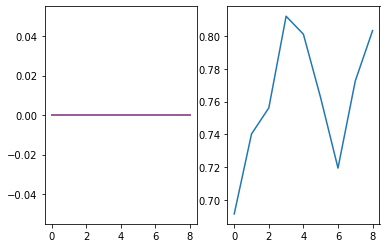

100%|██████████| 336/336 [00:39<00:00,  8.51it/s]


24.4010176807642 12.092839481309056


100%|██████████| 58/58 [00:02<00:00, 21.65it/s]


valid-f1: 0.7934680728409262

valid-precision: 0.825301651630871

valid-recall: 0.7795629598814459

process: 9  loss: 525.576161980629  train_correct: 0.9997204100652376 valid_loss 45.808064581708095  val_correct: 0.7983561643835616


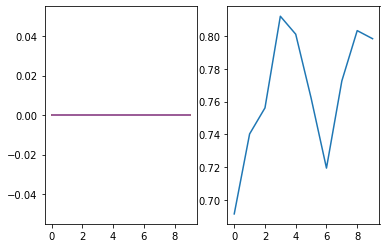

100%|██████████| 336/336 [00:39<00:00,  8.52it/s]


22.215845443308353 10.308366999030113


100%|██████████| 58/58 [00:02<00:00, 21.73it/s]


valid-f1: 0.7947087051376022

valid-precision: 0.8233507818328436

valid-recall: 0.7831071182815906

process: 10  loss: 512.9119457006454  train_correct: 0.9996272134203169 valid_loss 45.648429737632796  val_correct: 0.8005479452054794


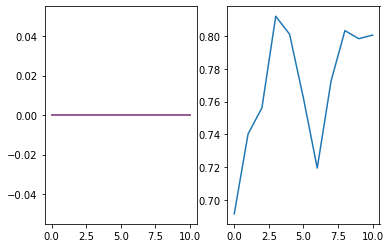

100%|██████████| 336/336 [00:39<00:00,  8.55it/s]


20.827645372599363 9.07269519008696


100%|██████████| 58/58 [00:02<00:00, 22.31it/s]


valid-f1: 0.7922347888934091

valid-precision: 0.8200491503459448

valid-recall: 0.7813372752589685

process: 11  loss: 506.93984818458557  train_correct: 0.9997204100652376 valid_loss 44.80338738129558  val_correct: 0.7983561643835616


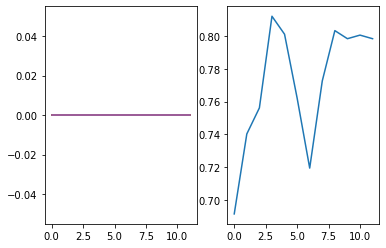

100%|██████████| 336/336 [00:39<00:00,  8.49it/s]


19.88944334536791 8.261743610724807


100%|██████████| 58/58 [00:02<00:00, 20.74it/s]


valid-f1: 0.7617643329858986

valid-precision: 0.7915021675169693

valid-recall: 0.7638917961894957

process: 12  loss: 499.0229834318161  train_correct: 0.9996272134203169 valid_loss 49.0508229981906  val_correct: 0.776986301369863


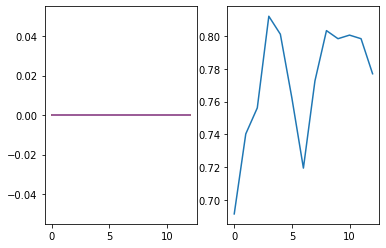

100%|██████████| 336/336 [00:39<00:00,  8.45it/s]


27.274325504899025 14.028608873486519


100%|██████████| 58/58 [00:02<00:00, 21.91it/s]


valid-f1: 0.7459301465836192

valid-precision: 0.7756625914836016

valid-recall: 0.7612065835670798

process: 13  loss: 792.0121887922287  train_correct: 0.9780987884436161 valid_loss 53.80462575762067  val_correct: 0.766027397260274


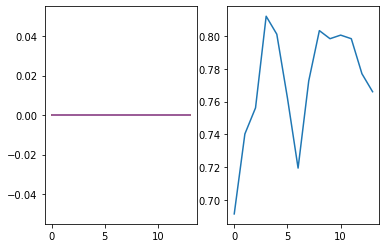

100%|██████████| 336/336 [00:39<00:00,  8.50it/s]


22.70163705945015 10.754513185471296


100%|██████████| 58/58 [00:02<00:00, 21.34it/s]


valid-f1: 0.759412512064208

valid-precision: 0.7853533277743788

valid-recall: 0.7724845551769643

process: 14  loss: 546.7578995227814  train_correct: 0.9972041006523765 valid_loss 58.19901349530801  val_correct: 0.7704109589041096


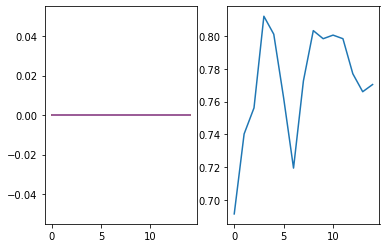

100%|██████████| 336/336 [00:39<00:00,  8.49it/s]


23.112378045916557 11.070212751626968


100%|██████████| 58/58 [00:02<00:00, 22.36it/s]


valid-f1: 0.775822723502628

valid-precision: 0.8155210662673774

valid-recall: 0.782427063353931

process: 15  loss: 617.2982224225998  train_correct: 0.9913327120223672 valid_loss 52.29345797384303  val_correct: 0.7923287671232877


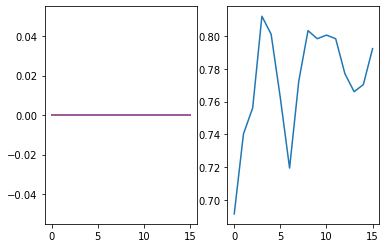

100%|██████████| 336/336 [00:39<00:00,  8.47it/s]


19.77273405715823 8.528216609731317


100%|██████████| 58/58 [00:03<00:00, 18.89it/s]


valid-f1: 0.7978296153408511

valid-precision: 0.824285617572736

valid-recall: 0.7882503365866796

process: 16  loss: 503.7177962064743  train_correct: 0.9993476234855545 valid_loss 49.08311710426642  val_correct: 0.804931506849315


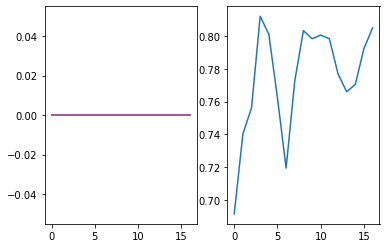

100%|██████████| 336/336 [00:39<00:00,  8.53it/s]


18.564687881618738 7.31135000474751


100%|██████████| 58/58 [00:02<00:00, 20.56it/s]


valid-f1: 0.8121236670504347

valid-precision: 0.8286362670017805

valid-recall: 0.8124922441872545

process: 17  loss: 488.29785537719727  train_correct: 0.9997204100652376 valid_loss 43.67270276543968  val_correct: 0.8224657534246576


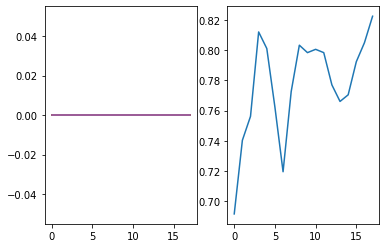

100%|██████████| 61/61 [00:02<00:00, 22.14it/s]


test-f1: 0.8046630344844612

test-precision: 0.8271842592151325

test-recall: 0.8025657201753262

The model has been saved!!

The best val_acc is  0.8224657534246576 The best test_acc is  0.7992719708788352


100%|██████████| 336/336 [00:39<00:00,  8.50it/s]


18.00946395844221 6.688985470682383


100%|██████████| 58/58 [00:02<00:00, 20.01it/s]


valid-f1: 0.8220858356604254

valid-precision: 0.8385442581214461

valid-recall: 0.8231375960879816

process: 18  loss: 483.5841234922409  train_correct: 0.9996272134203169 valid_loss 43.55040621119588  val_correct: 0.8301369863013699


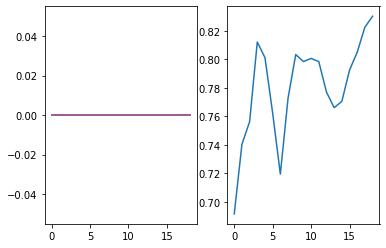

100%|██████████| 61/61 [00:02<00:00, 21.02it/s]


test-f1: 0.8056257346691194

test-precision: 0.8276957090832833

test-recall: 0.8043611719394488

The model has been saved!!

The best val_acc is  0.8301369863013699 The best test_acc is  0.7977119084763391


100%|██████████| 336/336 [00:39<00:00,  8.47it/s]


17.537799317389727 6.234206415712833


100%|██████████| 58/58 [00:02<00:00, 19.89it/s]


valid-f1: 0.8144522283424689

valid-precision: 0.8286171781101421

valid-recall: 0.8176756495100588

process: 19  loss: 481.2038561105728  train_correct: 0.9997204100652376 valid_loss 43.41395952273888  val_correct: 0.8246575342465754


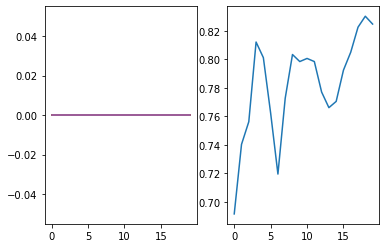

100%|██████████| 336/336 [00:39<00:00,  8.50it/s]


17.67404831945896 6.262211875058711


100%|██████████| 58/58 [00:02<00:00, 22.47it/s]


valid-f1: 0.6661593629485294

valid-precision: 0.7506793770255474

valid-recall: 0.6865480365499987

process: 20  loss: 509.2113845348358  train_correct: 0.9971109040074557 valid_loss 82.84231723022094  val_correct: 0.6789041095890411


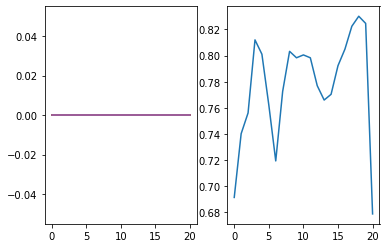

100%|██████████| 336/336 [00:39<00:00,  8.51it/s]


22.838914219290018 11.215533217415214


100%|██████████| 58/58 [00:02<00:00, 21.21it/s]


valid-f1: 0.7688623972960811

valid-precision: 0.8012922671579762

valid-recall: 0.7854896860509062

process: 21  loss: 722.1148122549057  train_correct: 0.9831314072693383 valid_loss 58.11028280629671  val_correct: 0.7978082191780822


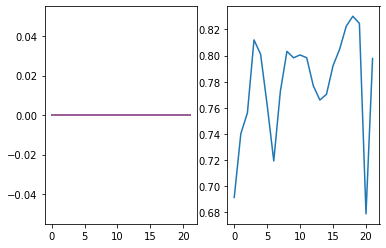

100%|██████████| 336/336 [00:39<00:00,  8.52it/s]


18.948293432593346 7.97319371253252


100%|██████████| 58/58 [00:02<00:00, 22.06it/s]


valid-f1: 0.7922294204309922

valid-precision: 0.820718243577039

valid-recall: 0.7821875347089261

process: 22  loss: 533.2022969722748  train_correct: 0.9966449207828518 valid_loss 50.795434038794156  val_correct: 0.7983561643835616


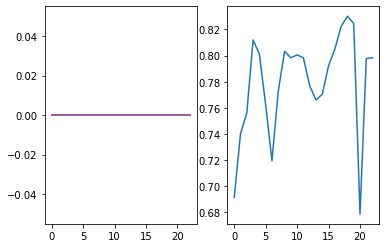

100%|██████████| 336/336 [00:39<00:00,  8.52it/s]


18.737228214740753 7.529888706281781


100%|██████████| 58/58 [00:02<00:00, 19.45it/s]


valid-f1: 0.8189913156714397

valid-precision: 0.8396471856000505

valid-recall: 0.8166402207169664

process: 23  loss: 515.5709592103958  train_correct: 0.9974836905871388 valid_loss 45.01192649541281  val_correct: 0.827945205479452


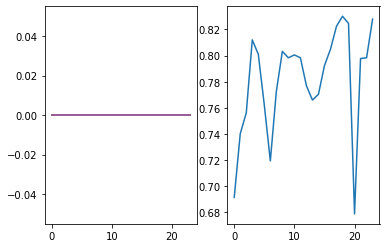

100%|██████████| 336/336 [00:40<00:00,  8.33it/s]


17.461164698004723 6.278395710512996


100%|██████████| 58/58 [00:02<00:00, 22.39it/s]


valid-f1: 0.8240118071338607

valid-precision: 0.8441832406528371

valid-recall: 0.8208781833709811

process: 24  loss: 480.3400499820709  train_correct: 0.9996272134203169 valid_loss 44.98905173658204  val_correct: 0.8301369863013699


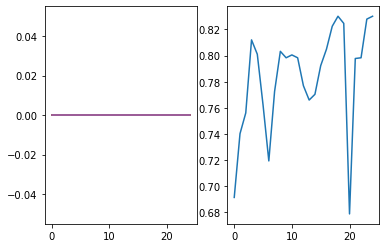

100%|██████████| 336/336 [00:39<00:00,  8.46it/s]


17.075104389339685 5.796996869146824


100%|██████████| 58/58 [00:02<00:00, 22.63it/s]


valid-f1: 0.8207043730125647

valid-precision: 0.8447358763490416

valid-recall: 0.814101952310019

process: 25  loss: 475.2808290719986  train_correct: 0.9997204100652376 valid_loss 44.90378536788012  val_correct: 0.8268493150684931


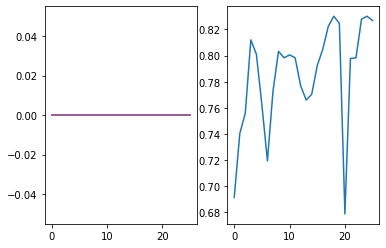

100%|██████████| 336/336 [00:39<00:00,  8.53it/s]


16.736914835870266 5.529117072932422


100%|██████████| 58/58 [00:02<00:00, 20.67it/s]


valid-f1: 0.8340658374447273

valid-precision: 0.8455666937416373

valid-recall: 0.8374921048741883

process: 26  loss: 471.8984352350235  train_correct: 0.9995340167753961 valid_loss 42.99550226705878  val_correct: 0.8421917808219178


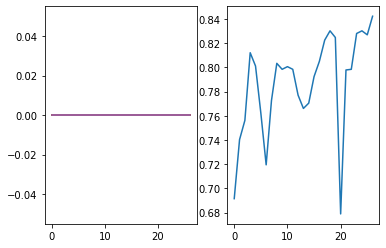

100%|██████████| 61/61 [00:02<00:00, 22.20it/s]


test-f1: 0.815569389646695

test-precision: 0.8225679656719876

test-recall: 0.8236444807028583

The model has been saved!!

The best val_acc is  0.8421917808219178 The best test_acc is  0.8096723868954758


100%|██████████| 336/336 [00:39<00:00,  8.53it/s]


16.467264648526907 5.412627022713423


100%|██████████| 58/58 [00:02<00:00, 20.11it/s]


valid-f1: 0.8224125829960427

valid-precision: 0.8471101508343102

valid-recall: 0.8151721598886599

process: 27  loss: 473.04336285591125  train_correct: 0.9996272134203169 valid_loss 47.28214427943294  val_correct: 0.8257534246575342


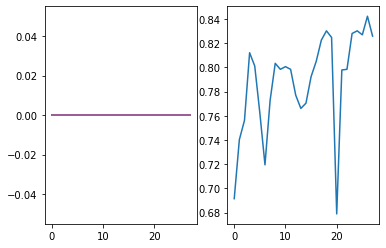

100%|██████████| 336/336 [00:39<00:00,  8.53it/s]


16.2259743437171 5.204257239587605


100%|██████████| 58/58 [00:02<00:00, 22.10it/s]


valid-f1: 0.8269642676080217

valid-precision: 0.8460837744032806

valid-recall: 0.8202239707073978

process: 28  loss: 469.1670563220978  train_correct: 0.9996272134203169 valid_loss 46.19120436881076  val_correct: 0.8284931506849315


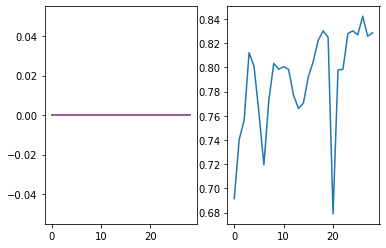

100%|██████████| 336/336 [00:39<00:00,  8.52it/s]


15.872225172817707 5.03110520914197


100%|██████████| 58/58 [00:02<00:00, 22.31it/s]


valid-f1: 0.834176335087075

valid-precision: 0.8556017306404875

valid-recall: 0.8274073206692906

process: 29  loss: 464.59148794412613  train_correct: 0.9997204100652376 valid_loss 45.14313604098879  val_correct: 0.8361643835616438


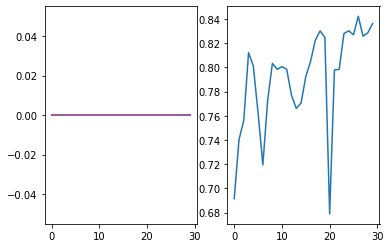

100%|██████████| 336/336 [00:39<00:00,  8.49it/s]


18.82446663454175 7.449506179429591


100%|██████████| 58/58 [00:02<00:00, 21.99it/s]


valid-f1: 0.7563839201244198

valid-precision: 0.8145144424932094

valid-recall: 0.7507763540414901

process: 30  loss: 671.6150971651077  train_correct: 0.987138863000932 valid_loss 62.76355135480844  val_correct: 0.7731506849315068


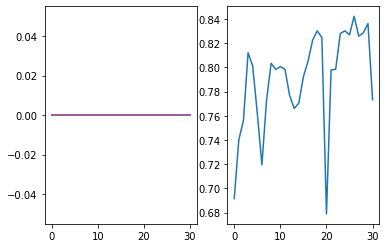

100%|██████████| 336/336 [00:39<00:00,  8.53it/s]


19.550970781594515 8.8714137095958


100%|██████████| 58/58 [00:03<00:00, 19.22it/s]


valid-f1: 0.7710527941907175

valid-precision: 0.8129706936764121

valid-recall: 0.7575983567821332

process: 31  loss: 574.8523089289665  train_correct: 0.9936626281453868 valid_loss 56.366196502247476  val_correct: 0.7841095890410958


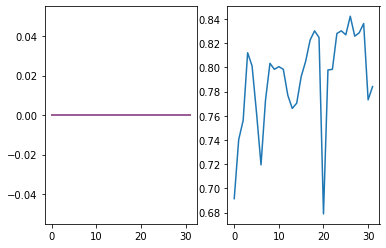

100%|██████████| 336/336 [00:39<00:00,  8.43it/s]


17.273060530424118 6.65406877361238


100%|██████████| 58/58 [00:02<00:00, 22.21it/s]


valid-f1: 0.8162595078036994

valid-precision: 0.8324245359812196

valid-recall: 0.8180837984110179

process: 32  loss: 499.5320380926132  train_correct: 0.9986020503261882 valid_loss 45.75739105010689  val_correct: 0.8312328767123288


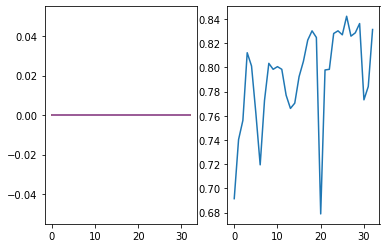

100%|██████████| 336/336 [00:39<00:00,  8.51it/s]


16.406292527914047 5.748856999911368


100%|██████████| 58/58 [00:02<00:00, 22.35it/s]


valid-f1: 0.8222040992346724

valid-precision: 0.8349619485919693

valid-recall: 0.8323525951409885

process: 33  loss: 481.42728781700134  train_correct: 0.9992544268406337 valid_loss 44.43876582778739  val_correct: 0.8367123287671233


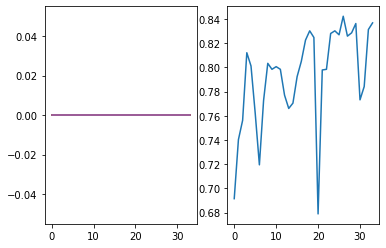

100%|██████████| 336/336 [00:39<00:00,  8.52it/s]


16.0318665727973 5.213053749874234


100%|██████████| 58/58 [00:02<00:00, 22.57it/s]


valid-f1: 0.8286899762735628

valid-precision: 0.8393362567166184

valid-recall: 0.8303264313792533

process: 34  loss: 469.3713504076004  train_correct: 0.9998136067101584 valid_loss 42.278907000712934  val_correct: 0.8372602739726027


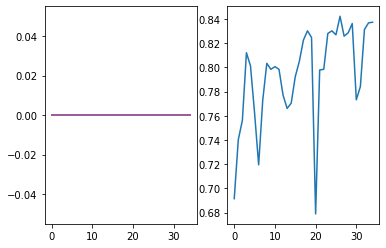

100%|██████████| 336/336 [00:39<00:00,  8.50it/s]


15.491539359092712 4.96122635435313


100%|██████████| 58/58 [00:02<00:00, 22.48it/s]


valid-f1: 0.8406556654223685

valid-precision: 0.8529579486831163

valid-recall: 0.8402853280311579

process: 35  loss: 466.76618844270706  train_correct: 0.9998136067101584 valid_loss 42.591692468142355  val_correct: 0.8471232876712329


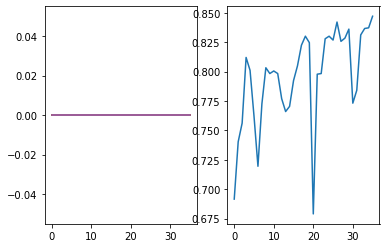

100%|██████████| 61/61 [00:02<00:00, 21.39it/s]


test-f1: 0.817121838430397

test-precision: 0.8407494035679403

test-recall: 0.8173376541138466

The model has been saved!!

The best val_acc is  0.8471232876712329 The best test_acc is  0.8159126365054602


100%|██████████| 336/336 [00:40<00:00,  8.39it/s]


15.029287029057741 4.878499168902636


100%|██████████| 58/58 [00:02<00:00, 22.41it/s]


valid-f1: 0.8431151947604606

valid-precision: 0.8563653876187585

valid-recall: 0.8446374113033952

process: 36  loss: 463.1217156648636  train_correct: 0.9998136067101584 valid_loss 44.52307748000294  val_correct: 0.8487671232876712


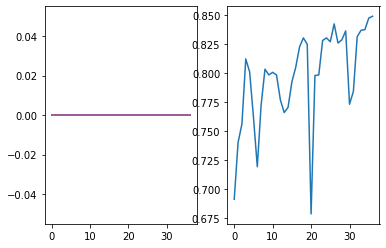

100%|██████████| 61/61 [00:02<00:00, 21.60it/s]


test-f1: 0.8086686570846207

test-precision: 0.8370501847848979

test-recall: 0.8096185195160821

The model has been saved!!

The best val_acc is  0.8487671232876712 The best test_acc is  0.8101924076963078


100%|██████████| 336/336 [00:39<00:00,  8.52it/s]


14.766471836715937 4.776064767502248


100%|██████████| 58/58 [00:02<00:00, 22.43it/s]


valid-f1: 0.8355515554755547

valid-precision: 0.8486611205329583

valid-recall: 0.8353953862521732

process: 37  loss: 463.69802367687225  train_correct: 0.9999068033550792 valid_loss 44.57422888361452  val_correct: 0.8416438356164384


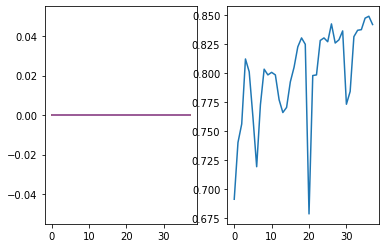

100%|██████████| 336/336 [00:39<00:00,  8.53it/s]


14.342924546450377 4.690259555354714


100%|██████████| 58/58 [00:02<00:00, 21.97it/s]


valid-f1: 0.8327213223605237

valid-precision: 0.8452939795265619

valid-recall: 0.8314940453847045

process: 38  loss: 462.20916724205017  train_correct: 0.9998136067101584 valid_loss 45.80627857052605  val_correct: 0.8383561643835616


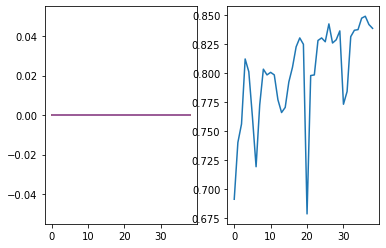

100%|██████████| 336/336 [00:39<00:00,  8.49it/s]


13.959785152226686 4.556257338263094


100%|██████████| 58/58 [00:02<00:00, 22.15it/s]


valid-f1: 0.8164741486807253

valid-precision: 0.8590410369378999

valid-recall: 0.7970493156760288

process: 39  loss: 458.1085704565048  train_correct: 0.9999068033550792 valid_loss 56.20438378286235  val_correct: 0.8208219178082192


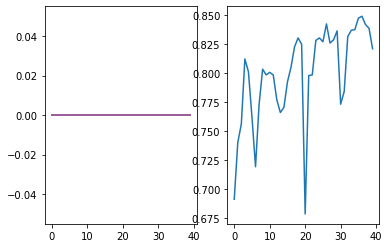

100%|██████████| 336/336 [00:40<00:00,  8.38it/s]


16.779637925326824 7.029993151314557


100%|██████████| 58/58 [00:02<00:00, 22.50it/s]


valid-f1: 0.7387825261245407

valid-precision: 0.7471124265770616

valid-recall: 0.7500934467314061

process: 40  loss: 662.0396965742111  train_correct: 0.9862068965517241 valid_loss 56.82700812064377  val_correct: 0.7523287671232877


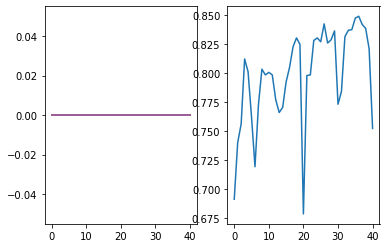

100%|██████████| 336/336 [00:39<00:00,  8.48it/s]


16.238483510911465 7.526985069736838


100%|██████████| 58/58 [00:02<00:00, 22.47it/s]


valid-f1: 0.8061267721337322

valid-precision: 0.8211520138178316

valid-recall: 0.8115559401200947

process: 41  loss: 556.8831684589386  train_correct: 0.9941286113699906 valid_loss 47.03709577376685  val_correct: 0.8180821917808219


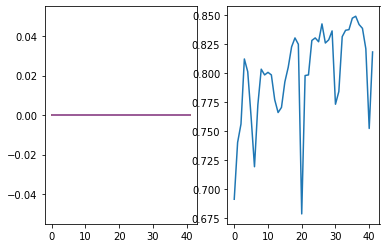

100%|██████████| 336/336 [00:39<00:00,  8.53it/s]


14.72719967737794 5.723630493506789


100%|██████████| 58/58 [00:02<00:00, 21.23it/s]


valid-f1: 0.7818624858846344

valid-precision: 0.8205434619318186

valid-recall: 0.7775733948504208

process: 42  loss: 485.5039687156677  train_correct: 0.9987884436160298 valid_loss 59.01737159800177  val_correct: 0.7928767123287671


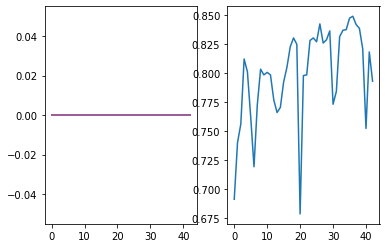

100%|██████████| 336/336 [00:39<00:00,  8.55it/s]


14.627542242407799 4.978639808483422


100%|██████████| 58/58 [00:02<00:00, 21.66it/s]


valid-f1: 0.7930741881123724

valid-precision: 0.8303242485579588

valid-recall: 0.7897469446527807

process: 43  loss: 464.76080644130707  train_correct: 0.9998136067101584 valid_loss 59.13852396790844  val_correct: 0.8027397260273973


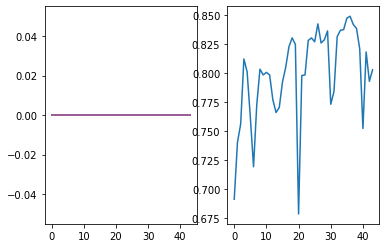

100%|██████████| 336/336 [00:39<00:00,  8.57it/s]


14.155765000730753 4.748314875178039


100%|██████████| 58/58 [00:02<00:00, 20.31it/s]


valid-f1: 0.7891889579272796

valid-precision: 0.8179998538625167

valid-recall: 0.7853185717747185

process: 44  loss: 462.08623707294464  train_correct: 0.9998136067101584 valid_loss 58.45252263213388  val_correct: 0.7994520547945205


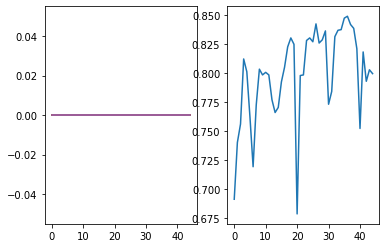

100%|██████████| 336/336 [00:39<00:00,  8.44it/s]


13.823491897433996 4.625034929253161


100%|██████████| 58/58 [00:02<00:00, 21.03it/s]


valid-f1: 0.8015085564638896

valid-precision: 0.8261021542796636

valid-recall: 0.7992759703268015

process: 45  loss: 460.30093801021576  train_correct: 0.9999068033550792 valid_loss 56.003530569891154  val_correct: 0.8115068493150684


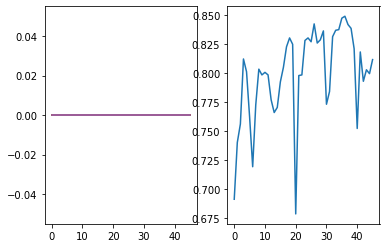

100%|██████████| 336/336 [00:39<00:00,  8.47it/s]


13.60590160638094 4.524758356623352


100%|██████████| 58/58 [00:02<00:00, 21.90it/s]


valid-f1: 0.7998045933487377

valid-precision: 0.8279707772451068

valid-recall: 0.795696100398561

process: 46  loss: 461.5351068973541  train_correct: 0.9999068033550792 valid_loss 57.24308776642101  val_correct: 0.8087671232876712


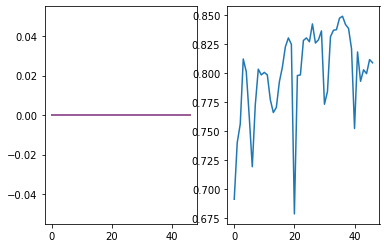

100%|██████████| 336/336 [00:39<00:00,  8.47it/s]


13.310344383120537 4.444132628850639


100%|██████████| 58/58 [00:02<00:00, 22.49it/s]


valid-f1: 0.7999465195102651

valid-precision: 0.8281849426472518

valid-recall: 0.7950623782271762

process: 47  loss: 458.86301040649414  train_correct: 0.9999068033550792 valid_loss 58.46108674224706  val_correct: 0.8076712328767123


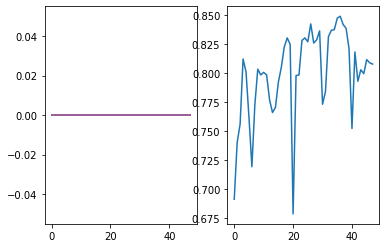

100%|██████████| 336/336 [00:39<00:00,  8.47it/s]


12.996738750487566 4.364047581329942


100%|██████████| 58/58 [00:02<00:00, 22.37it/s]


valid-f1: 0.7976568925646935

valid-precision: 0.8215693095314422

valid-recall: 0.7933396149734919

process: 48  loss: 457.8700592517853  train_correct: 1.0 valid_loss 58.17826749080996  val_correct: 0.8054794520547945


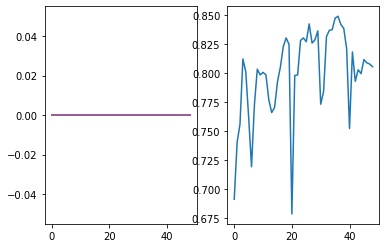

100%|██████████| 336/336 [00:39<00:00,  8.52it/s]


12.559552188962698 4.250878736376762


100%|██████████| 58/58 [00:03<00:00, 19.02it/s]


valid-f1: 0.7994612820424809

valid-precision: 0.8236437199368721

valid-recall: 0.7960113613917358

process: 49  loss: 455.9620158672333  train_correct: 1.0 valid_loss 59.21097967517153  val_correct: 0.8071232876712329


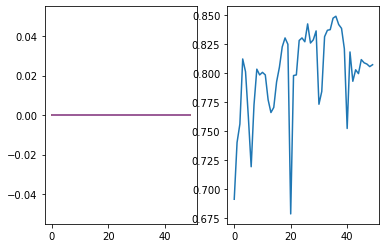

100%|██████████| 336/336 [00:39<00:00,  8.56it/s]


67.03360824286938 38.732363894581795


100%|██████████| 58/58 [00:02<00:00, 21.38it/s]


valid-f1: 0.7406825105879196

valid-precision: 0.7783618818448405

valid-recall: 0.7388896468722317

process: 0  loss: 3445.4508476257324  train_correct: 0.7281453867660764 valid_loss 43.27087082929211  val_correct: 0.7391780821917808


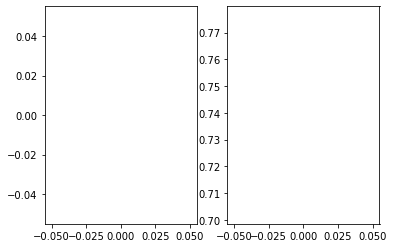

100%|██████████| 61/61 [00:02<00:00, 22.35it/s]


test-f1: 0.7015608206395187

test-precision: 0.7367437229517498

test-recall: 0.7088452220442977

The model has been saved!!

The best val_acc is  0.7391780821917808 The best test_acc is  0.6916276651066042


100%|██████████| 336/336 [00:39<00:00,  8.48it/s]


60.81747192144394 33.65480626374483


100%|██████████| 58/58 [00:02<00:00, 22.10it/s]


valid-f1: 0.7386090685663484

valid-precision: 0.7899553644224222

valid-recall: 0.7374386208806376

process: 1  loss: 1033.0302411317825  train_correct: 0.9713886300093196 valid_loss 49.4852413412591  val_correct: 0.7484931506849315


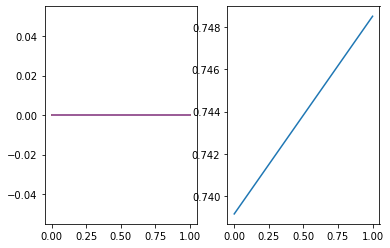

100%|██████████| 61/61 [00:02<00:00, 22.41it/s]


test-f1: 0.7548764774038194

test-precision: 0.7840313214221153

test-recall: 0.7654750548400495

The model has been saved!!

The best val_acc is  0.7484931506849315 The best test_acc is  0.7519500780031201


100%|██████████| 336/336 [00:39<00:00,  8.52it/s]


52.71938180923462 28.537491999566555


100%|██████████| 58/58 [00:02<00:00, 22.38it/s]


valid-f1: 0.7111861245543281

valid-precision: 0.7825402907331318

valid-recall: 0.6949832784934953

process: 2  loss: 824.1838595867157  train_correct: 0.9846225535880708 valid_loss 56.997145880013676  val_correct: 0.7238356164383561


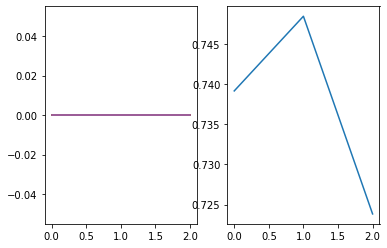

100%|██████████| 336/336 [00:40<00:00,  8.33it/s]


43.49294801056385 23.497231997549534


100%|██████████| 58/58 [00:03<00:00, 18.44it/s]


valid-f1: 0.815511665192689

valid-precision: 0.8272369307876473

valid-recall: 0.8233200364475003

process: 3  loss: 652.6800464391708  train_correct: 0.9972972972972973 valid_loss 36.71567051834222  val_correct: 0.812054794520548


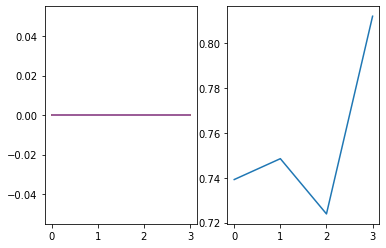

100%|██████████| 61/61 [00:02<00:00, 21.64it/s]


test-f1: 0.7439031403176724

test-precision: 0.7668030696480989

test-recall: 0.7566592508265523

The model has been saved!!

The best val_acc is  0.812054794520548 The best test_acc is  0.733229329173167


100%|██████████| 336/336 [00:39<00:00,  8.51it/s]


37.703005239367485 20.314103107899427


100%|██████████| 58/58 [00:02<00:00, 22.18it/s]


valid-f1: 0.818372257421626

valid-precision: 0.8352324625747242

valid-recall: 0.8288654529591835

process: 4  loss: 640.2647552490234  train_correct: 0.9959925442684063 valid_loss 35.69307010985858  val_correct: 0.8202739726027397


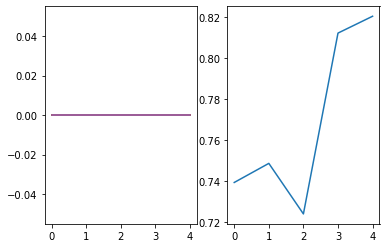

100%|██████████| 61/61 [00:02<00:00, 22.27it/s]


test-f1: 0.7682599543868124

test-precision: 0.7907448383805429

test-recall: 0.775373901154476

The model has been saved!!

The best val_acc is  0.8202739726027397 The best test_acc is  0.7545501820072803


100%|██████████| 336/336 [00:39<00:00,  8.49it/s]


33.091057516634464 17.33355613425374


100%|██████████| 58/58 [00:02<00:00, 20.57it/s]


valid-f1: 0.7716279358993392

valid-precision: 0.794988165822011

valid-recall: 0.7786420128975722

process: 5  loss: 644.9176168441772  train_correct: 0.992730661696179 valid_loss 57.59356569724332  val_correct: 0.7578082191780822


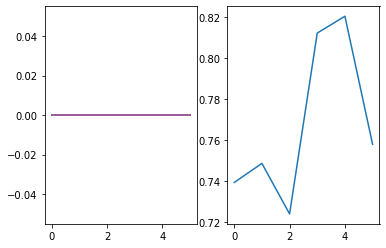

100%|██████████| 336/336 [00:39<00:00,  8.47it/s]


32.81940929591656 18.157623134553432


100%|██████████| 58/58 [00:02<00:00, 21.72it/s]


valid-f1: 0.7771621481836622

valid-precision: 0.8150605891711855

valid-recall: 0.7807936540647248

process: 6  loss: 707.0432012081146  train_correct: 0.9882572227399814 valid_loss 54.09204388484977  val_correct: 0.7873972602739726


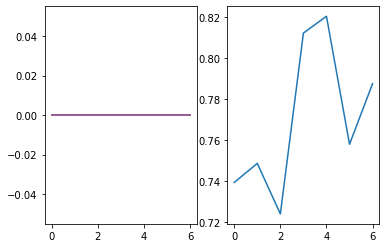

100%|██████████| 336/336 [00:40<00:00,  8.34it/s]


27.177807934582233 13.994088262319565


100%|██████████| 58/58 [00:03<00:00, 18.45it/s]


valid-f1: 0.8246174490787901

valid-precision: 0.8400640312353216

valid-recall: 0.8260361635081186

process: 7  loss: 573.1559046506882  train_correct: 0.9976700838769804 valid_loss 38.20222094667588  val_correct: 0.8235616438356165


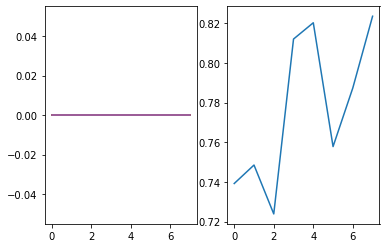

100%|██████████| 61/61 [00:02<00:00, 21.42it/s]


test-f1: 0.7892682581591538

test-precision: 0.7989763995304113

test-recall: 0.8037820209418474

The model has been saved!!

The best val_acc is  0.8235616438356165 The best test_acc is  0.7847113884555382


100%|██████████| 336/336 [00:39<00:00,  8.45it/s]


23.684559881687164 11.606304701417685


100%|██████████| 58/58 [00:02<00:00, 21.93it/s]


valid-f1: 0.8056869687635146

valid-precision: 0.839423840421964

valid-recall: 0.7949888976287623

process: 8  loss: 545.2544004917145  train_correct: 0.9981360671015843 valid_loss 42.11728371672143  val_correct: 0.8104109589041096


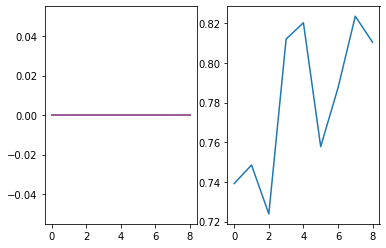

100%|██████████| 336/336 [00:39<00:00,  8.43it/s]


20.946235924959183 9.22442384250462


100%|██████████| 58/58 [00:02<00:00, 22.35it/s]


valid-f1: 0.8018552116609661

valid-precision: 0.8340554677272323

valid-recall: 0.7948622368769203

process: 9  loss: 511.00944340229034  train_correct: 0.9993476234855545 valid_loss 43.493921537767164  val_correct: 0.8032876712328767


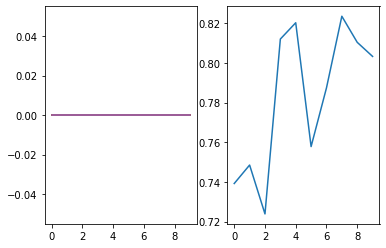

100%|██████████| 336/336 [00:39<00:00,  8.46it/s]


19.525499191135168 7.931186242029071


100%|██████████| 58/58 [00:02<00:00, 22.08it/s]


valid-f1: 0.8015550141874442

valid-precision: 0.8425657760819881

valid-recall: 0.7868078657340571

process: 10  loss: 500.8797936439514  train_correct: 0.9996272134203169 valid_loss 48.721887630476886  val_correct: 0.8071232876712329


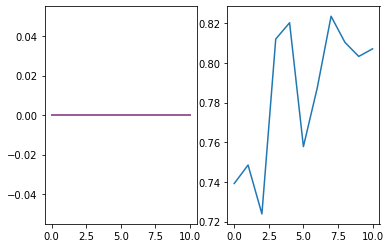

100%|██████████| 336/336 [00:39<00:00,  8.45it/s]


20.923593025654554 8.703652864322066


100%|██████████| 58/58 [00:02<00:00, 20.84it/s]


valid-f1: 0.76307374170298

valid-precision: 0.8140904361441574

valid-recall: 0.7716265579383963

process: 11  loss: 655.5105912685394  train_correct: 0.9875116495806151 valid_loss 58.738364802211436  val_correct: 0.783013698630137


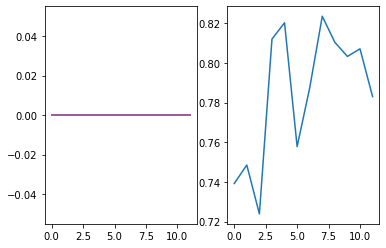

100%|██████████| 336/336 [00:39<00:00,  8.43it/s]


24.131423857063055 11.810884669423103


100%|██████████| 58/58 [00:02<00:00, 20.55it/s]


valid-f1: 0.780173420727641

valid-precision: 0.8076856474297862

valid-recall: 0.7939717461839564

process: 12  loss: 653.4587562084198  train_correct: 0.9877912395153774 valid_loss 47.88615215158279  val_correct: 0.7813698630136986


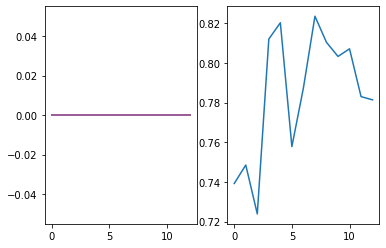

100%|██████████| 336/336 [00:39<00:00,  8.44it/s]


20.677946589887142 8.842054875567555


100%|██████████| 58/58 [00:02<00:00, 20.29it/s]


valid-f1: 0.8291407720924026

valid-precision: 0.8412235569790998

valid-recall: 0.8285255496928704

process: 13  loss: 550.3560483455658  train_correct: 0.9960857409133271 valid_loss 44.733490719396286  val_correct: 0.8306849315068493


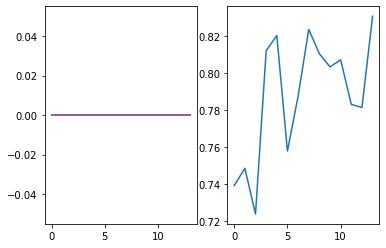

100%|██████████| 61/61 [00:02<00:00, 21.15it/s]


test-f1: 0.8174550090205882

test-precision: 0.8259375388440479

test-recall: 0.8312710388757489

The model has been saved!!

The best val_acc is  0.8306849315068493 The best test_acc is  0.8075923036921477


100%|██████████| 336/336 [00:39<00:00,  8.48it/s]


19.945591297000647 8.10301211476326


100%|██████████| 58/58 [00:02<00:00, 21.48it/s]


valid-f1: 0.8024304385732544

valid-precision: 0.8275736840553171

valid-recall: 0.7958913322902549

process: 14  loss: 543.1995607018471  train_correct: 0.9962721342031687 valid_loss 55.254067342675626  val_correct: 0.8158904109589041


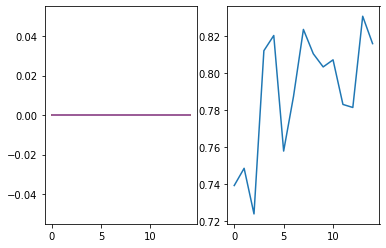

100%|██████████| 336/336 [00:39<00:00,  8.43it/s]


20.042957168072462 7.985546730458736


100%|██████████| 58/58 [00:02<00:00, 21.67it/s]


valid-f1: 0.8170671491244766

valid-precision: 0.8376295695369951

valid-recall: 0.8092842681570236

process: 15  loss: 572.6467283368111  train_correct: 0.9943150046598322 valid_loss 44.461563211196335  val_correct: 0.8268493150684931


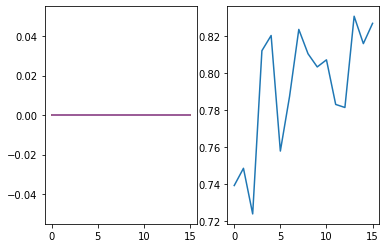

100%|██████████| 336/336 [00:39<00:00,  8.50it/s]


18.42435447126627 6.922424081712961


100%|██████████| 58/58 [00:03<00:00, 17.29it/s]


valid-f1: 0.8359771749332211

valid-precision: 0.8615904669591725

valid-recall: 0.8341699271920617

process: 16  loss: 515.3420733213425  train_correct: 0.997856477166822 valid_loss 43.06394959541285  val_correct: 0.8471232876712329


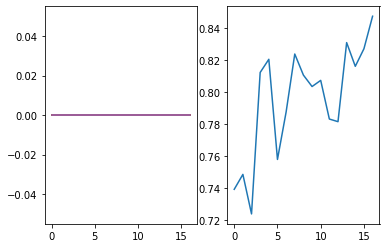

100%|██████████| 61/61 [00:03<00:00, 19.35it/s]


test-f1: 0.8419754454409629

test-precision: 0.8593735925256819

test-recall: 0.8405805452930893

The model has been saved!!

The best val_acc is  0.8471232876712329 The best test_acc is  0.8377535101404057


100%|██████████| 336/336 [00:39<00:00,  8.45it/s]


18.646658197045326 6.51709808409214


100%|██████████| 58/58 [00:02<00:00, 21.20it/s]


valid-f1: 0.8048750848341835

valid-precision: 0.835605973234631

valid-recall: 0.8013946983222043

process: 17  loss: 501.48237800598145  train_correct: 0.9984156570363467 valid_loss 58.813039040043805  val_correct: 0.8054794520547945


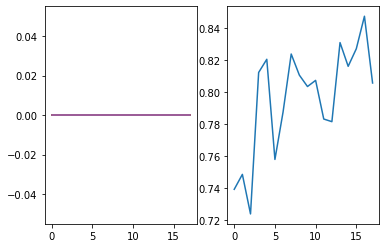

100%|██████████| 336/336 [00:39<00:00,  8.47it/s]


18.89861235767603 6.9373796582221985


100%|██████████| 58/58 [00:02<00:00, 20.62it/s]


valid-f1: 0.7615914590154889

valid-precision: 0.8031638808363377

valid-recall: 0.7565182586861816

process: 18  loss: 583.2299138307571  train_correct: 0.993103448275862 valid_loss 58.46179557697906  val_correct: 0.7556164383561644


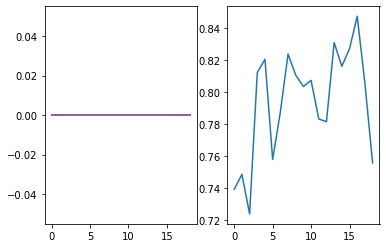

100%|██████████| 336/336 [00:39<00:00,  8.49it/s]


19.038404915481806 7.280037561431527


100%|██████████| 58/58 [00:02<00:00, 21.90it/s]


valid-f1: 0.8105724509925019

valid-precision: 0.82977409472466

valid-recall: 0.8083425744382975

process: 19  loss: 573.698320388794  train_correct: 0.9926374650512582 valid_loss 50.899243193160146  val_correct: 0.8158904109589041


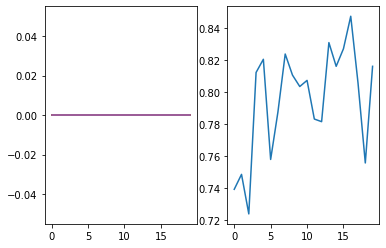

100%|██████████| 336/336 [00:39<00:00,  8.42it/s]


17.776411838829517 5.641153791919351


100%|██████████| 58/58 [00:02<00:00, 22.13it/s]


valid-f1: 0.8274393225235182

valid-precision: 0.8518382425880386

valid-recall: 0.820436852289377

process: 20  loss: 492.8779287338257  train_correct: 0.9989748369058714 valid_loss 48.29167057717132  val_correct: 0.8295890410958904


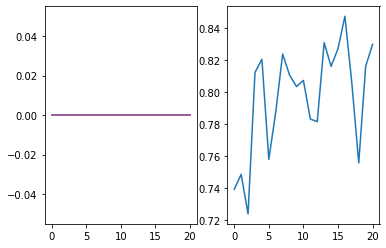

100%|██████████| 336/336 [00:40<00:00,  8.31it/s]


17.08667527884245 4.987067348323762


100%|██████████| 58/58 [00:03<00:00, 19.33it/s]


valid-f1: 0.8273870463502682

valid-precision: 0.8636293593285791

valid-recall: 0.8128708001102144

process: 21  loss: 473.69676476716995  train_correct: 0.9996272134203169 valid_loss 50.72399175541068  val_correct: 0.8284931506849315


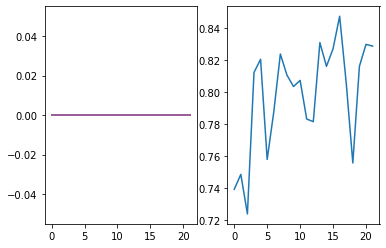

100%|██████████| 336/336 [00:40<00:00,  8.39it/s]


16.606269486248493 4.540095324628055


100%|██████████| 58/58 [00:02<00:00, 22.06it/s]


valid-f1: 0.8356148208882199

valid-precision: 0.8630340589506682

valid-recall: 0.8251631403518418

process: 22  loss: 467.1891103386879  train_correct: 0.9998136067101584 valid_loss 46.21370965434471  val_correct: 0.8356164383561644


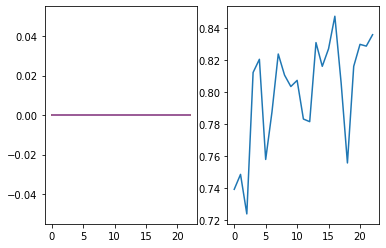

100%|██████████| 336/336 [00:39<00:00,  8.44it/s]


16.20167187228799 4.348081591539085


100%|██████████| 58/58 [00:02<00:00, 22.13it/s]


valid-f1: 0.8298671892837086

valid-precision: 0.8517471376343986

valid-recall: 0.8204212363142458

process: 23  loss: 467.89453971385956  train_correct: 0.9999068033550792 valid_loss 48.49621270292846  val_correct: 0.8263013698630137


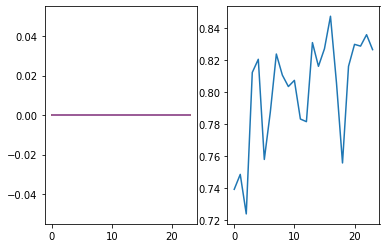

100%|██████████| 336/336 [00:39<00:00,  8.43it/s]


16.07884958013892 4.245668841525912


100%|██████████| 58/58 [00:02<00:00, 22.04it/s]


valid-f1: 0.8257436611289295

valid-precision: 0.8430801455894479

valid-recall: 0.8233832655702977

process: 24  loss: 467.64716309309006  train_correct: 0.9998136067101584 valid_loss 51.311621390017535  val_correct: 0.8301369863013699


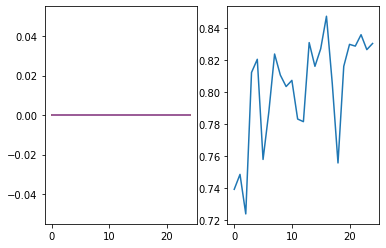

100%|██████████| 336/336 [00:39<00:00,  8.46it/s]


15.664074171334505 3.9669536678120494


100%|██████████| 58/58 [00:02<00:00, 21.93it/s]


valid-f1: 0.8488870932426265

valid-precision: 0.8714518049340546

valid-recall: 0.840241564463682

process: 25  loss: 461.10600113868713  train_correct: 1.0 valid_loss 45.25347752193193  val_correct: 0.8504109589041096


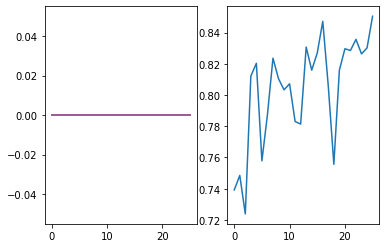

100%|██████████| 61/61 [00:02<00:00, 21.88it/s]


test-f1: 0.8312342470668584

test-precision: 0.8426070488485566

test-recall: 0.8322020472033846

The model has been saved!!

The best val_acc is  0.8504109589041096 The best test_acc is  0.8185127405096204


100%|██████████| 336/336 [00:40<00:00,  8.30it/s]


15.072050329297781 3.747647248208523


100%|██████████| 58/58 [00:02<00:00, 20.22it/s]


valid-f1: 0.82740959682929

valid-precision: 0.8460262512614489

valid-recall: 0.8218075341631463

process: 26  loss: 462.97509932518005  train_correct: 0.9999068033550792 valid_loss 49.36766005641039  val_correct: 0.827945205479452


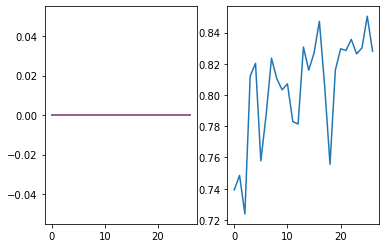

100%|██████████| 336/336 [00:39<00:00,  8.45it/s]


14.593533385545015 3.6502540512010455


100%|██████████| 58/58 [00:02<00:00, 22.42it/s]


valid-f1: 0.8410662428756073

valid-precision: 0.8681618613017538

valid-recall: 0.8302646815191267

process: 27  loss: 456.3908733725548  train_correct: 1.0 valid_loss 49.11138458977075  val_correct: 0.846027397260274


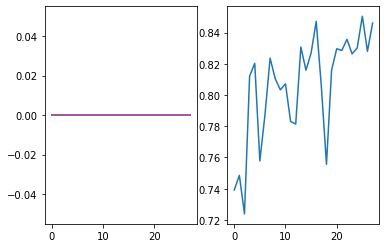

100%|██████████| 336/336 [00:39<00:00,  8.49it/s]


18.32031010836363 7.291178623214364


100%|██████████| 58/58 [00:02<00:00, 22.20it/s]


valid-f1: 0.8210878500241311

valid-precision: 0.8382616615394198

valid-recall: 0.8287267673321741

process: 28  loss: 697.7043997049332  train_correct: 0.9835973904939422 valid_loss 40.289757577556884  val_correct: 0.8317808219178082


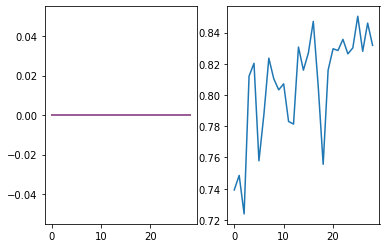

100%|██████████| 336/336 [00:39<00:00,  8.43it/s]


18.586551547050476 7.495737847872078


100%|██████████| 58/58 [00:02<00:00, 20.22it/s]


valid-f1: 0.8108667252645354

valid-precision: 0.8300095465609776

valid-recall: 0.8125564425845313

process: 29  loss: 566.5647568702698  train_correct: 0.9939422180801492 valid_loss 45.75067803760612  val_correct: 0.8175342465753425


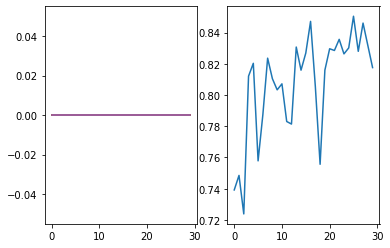

100%|██████████| 336/336 [00:39<00:00,  8.48it/s]


16.837901450693607 4.7770356787368655


100%|██████████| 58/58 [00:02<00:00, 21.39it/s]


valid-f1: 0.8600183800163558

valid-precision: 0.8817908881936635

valid-recall: 0.854693351526975

process: 30  loss: 481.86321783065796  train_correct: 0.9992544268406337 valid_loss 39.6167469035463  val_correct: 0.8657534246575342


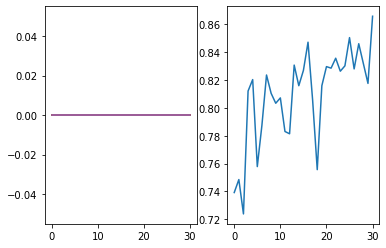

100%|██████████| 61/61 [00:02<00:00, 22.23it/s]


test-f1: 0.7938168444191618

test-precision: 0.8104520914777267

test-recall: 0.8039476627287572

The model has been saved!!

The best val_acc is  0.8657534246575342 The best test_acc is  0.7935517420696828


100%|██████████| 336/336 [00:39<00:00,  8.46it/s]


16.10530899837613 4.099673310294747


100%|██████████| 58/58 [00:03<00:00, 15.66it/s]


valid-f1: 0.8476965899685036

valid-precision: 0.8665385328127195

valid-recall: 0.844523171245531

process: 31  loss: 467.46600317955017  train_correct: 0.9998136067101584 valid_loss 43.34012931676989  val_correct: 0.8504109589041096


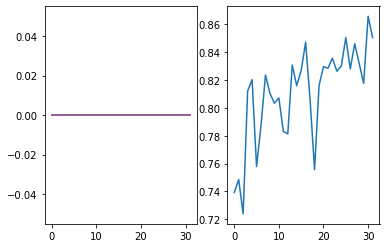

100%|██████████| 336/336 [00:39<00:00,  8.54it/s]


15.602037839591503 3.757733075879514


100%|██████████| 58/58 [00:02<00:00, 19.99it/s]


valid-f1: 0.8442828753811435

valid-precision: 0.8575869042044404

valid-recall: 0.843113012998107

process: 32  loss: 462.27809059619904  train_correct: 0.9999068033550792 valid_loss 42.07583575831086  val_correct: 0.8465753424657534


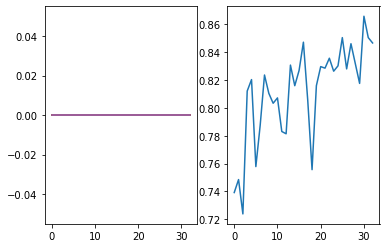

100%|██████████| 336/336 [00:39<00:00,  8.56it/s]


15.132888488471508 3.6205265931785107


100%|██████████| 58/58 [00:02<00:00, 21.12it/s]


valid-f1: 0.855263452916971

valid-precision: 0.8829451105263745

valid-recall: 0.8465050434840325

process: 33  loss: 462.0608158111572  train_correct: 0.9998136067101584 valid_loss 44.48271998466225  val_correct: 0.8558904109589041


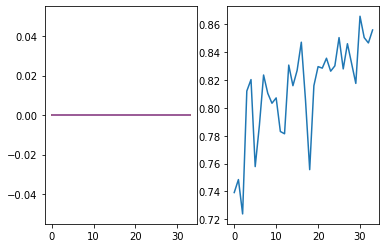

100%|██████████| 336/336 [00:39<00:00,  8.47it/s]


18.336789093911648 6.132922265678644


100%|██████████| 58/58 [00:02<00:00, 22.26it/s]


valid-f1: 0.7544156892200078

valid-precision: 0.8201060804771977

valid-recall: 0.7548149324484464

process: 34  loss: 655.641872882843  train_correct: 0.9870456663560112 valid_loss 73.32308693107552  val_correct: 0.7841095890410958


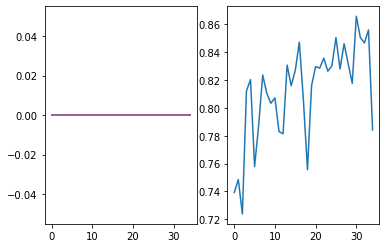

100%|██████████| 336/336 [00:39<00:00,  8.48it/s]


16.938053335994482 5.358466434292495


100%|██████████| 58/58 [00:02<00:00, 22.42it/s]


valid-f1: 0.8007159807048165

valid-precision: 0.8336359694242788

valid-recall: 0.785583800438772

process: 35  loss: 550.6766271591187  train_correct: 0.9945013979496738 valid_loss 53.886593085946515  val_correct: 0.8136986301369863


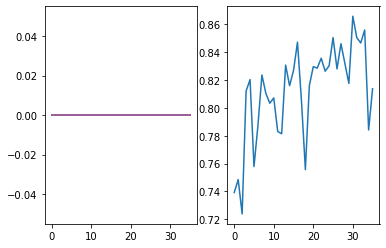

100%|██████████| 336/336 [00:39<00:00,  8.51it/s]


15.748056452721357 4.06096363812685


100%|██████████| 58/58 [00:02<00:00, 20.83it/s]


valid-f1: 0.8104663554820432

valid-precision: 0.8480981490315779

valid-recall: 0.8038755449280834

process: 36  loss: 504.6581400632858  train_correct: 0.997856477166822 valid_loss 52.03255806324887  val_correct: 0.8136986301369863


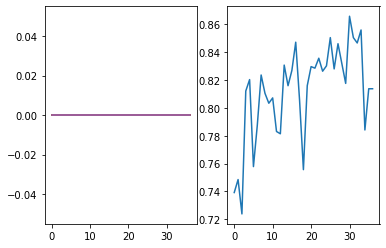

100%|██████████| 336/336 [00:40<00:00,  8.27it/s]


16.02281181514263 4.809280524030328


100%|██████████| 58/58 [00:02<00:00, 21.12it/s]


valid-f1: 0.8152863621509276

valid-precision: 0.8422535408320341

valid-recall: 0.8117776011498783

process: 37  loss: 533.4706523418427  train_correct: 0.9953401677539608 valid_loss 59.84383577837434  val_correct: 0.8071232876712329


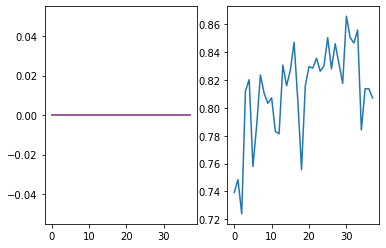

100%|██████████| 336/336 [00:39<00:00,  8.48it/s]


14.738650433719158 3.619963627308607


100%|██████████| 58/58 [00:02<00:00, 22.17it/s]


valid-f1: 0.8339984451904231

valid-precision: 0.8567424974888566

valid-recall: 0.8282726499653601

process: 38  loss: 465.7150398492813  train_correct: 0.9997204100652376 valid_loss 54.996226478007884  val_correct: 0.8361643835616438


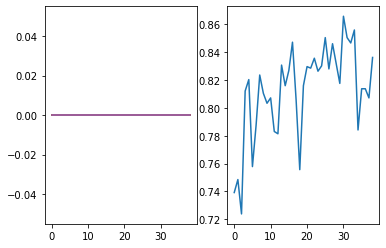

100%|██████████| 336/336 [00:39<00:00,  8.50it/s]


14.41774458810687 3.3706820867955685


100%|██████████| 58/58 [00:02<00:00, 22.40it/s]


valid-f1: 0.8480718627540946

valid-precision: 0.8730872001307173

valid-recall: 0.8420914922056462

process: 39  loss: 458.8076899051666  train_correct: 0.9998136067101584 valid_loss 50.89960296740901  val_correct: 0.856986301369863


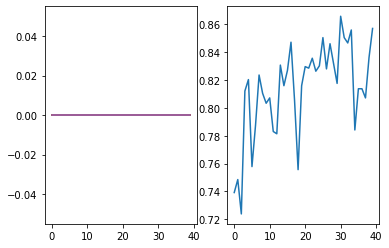

100%|██████████| 336/336 [00:39<00:00,  8.46it/s]


14.147708464413881 3.291064509190619


100%|██████████| 58/58 [00:02<00:00, 21.67it/s]


valid-f1: 0.8493783718189899

valid-precision: 0.8737781550174656

valid-recall: 0.8436615091094233

process: 40  loss: 457.62910401821136  train_correct: 1.0 valid_loss 51.38083687229664  val_correct: 0.8580821917808219


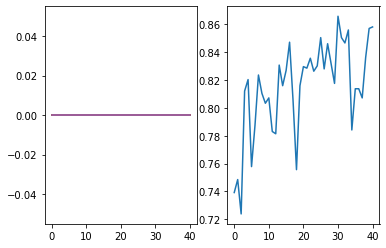

100%|██████████| 336/336 [00:39<00:00,  8.51it/s]


14.032094478607178 3.283146374858916


100%|██████████| 58/58 [00:02<00:00, 21.69it/s]


valid-f1: 0.8485359024332461

valid-precision: 0.8718286813793066

valid-recall: 0.8428212852476593

process: 41  loss: 457.9275532960892  train_correct: 0.9999068033550792 valid_loss 53.1444657562115  val_correct: 0.856986301369863


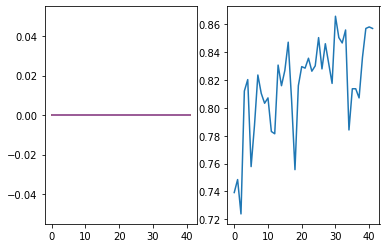

100%|██████████| 336/336 [00:39<00:00,  8.41it/s]


13.66666904836893 3.2621353147551417


100%|██████████| 58/58 [00:03<00:00, 18.63it/s]


valid-f1: 0.8497190343993747

valid-precision: 0.8730859604675729

valid-recall: 0.8446432417029968

process: 42  loss: 453.8814572095871  train_correct: 1.0 valid_loss 52.562655334959345  val_correct: 0.8586301369863014


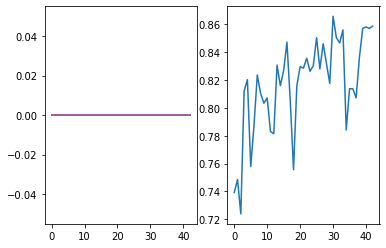

100%|██████████| 336/336 [00:39<00:00,  8.46it/s]


13.414241008460522 3.2828516867011786


100%|██████████| 58/58 [00:02<00:00, 20.58it/s]


valid-f1: 0.8359616513433791

valid-precision: 0.8511543941132361

valid-recall: 0.8336455323219039

process: 43  loss: 460.73272919654846  train_correct: 0.9999068033550792 valid_loss 52.35284710959604  val_correct: 0.8306849315068493


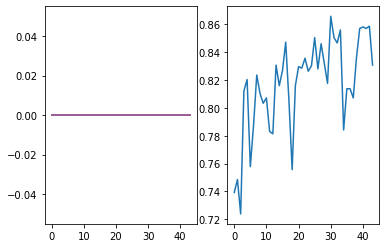

100%|██████████| 336/336 [00:39<00:00,  8.42it/s]


13.723098572343588 3.6990069607272744


100%|██████████| 58/58 [00:02<00:00, 21.31it/s]


valid-f1: 0.5730884455116579

valid-precision: 0.7940578089841827

valid-recall: 0.5280178184659364

process: 44  loss: 524.2107329368591  train_correct: 0.9956197576887232 valid_loss 112.08825052157044  val_correct: 0.5654794520547946


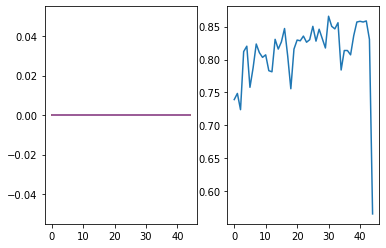

100%|██████████| 336/336 [00:39<00:00,  8.43it/s]


21.351425539702177 12.913292866200209


100%|██████████| 58/58 [00:02<00:00, 21.61it/s]


valid-f1: 0.7981962753397621

valid-precision: 0.8278974065909235

valid-recall: 0.7968879233202031

process: 45  loss: 689.7969634532928  train_correct: 0.9862068965517241 valid_loss 59.50910740119434  val_correct: 0.804931506849315


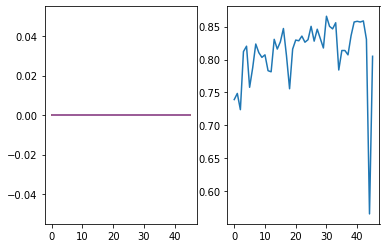

100%|██████████| 336/336 [00:39<00:00,  8.45it/s]


17.460297528654337 7.9288272969424725


100%|██████████| 58/58 [00:02<00:00, 21.89it/s]


valid-f1: 0.8354353495439989

valid-precision: 0.8563560575357687

valid-recall: 0.8331191447255136

process: 46  loss: 487.45929050445557  train_correct: 0.9992544268406337 valid_loss 54.51061641236811  val_correct: 0.8405479452054795


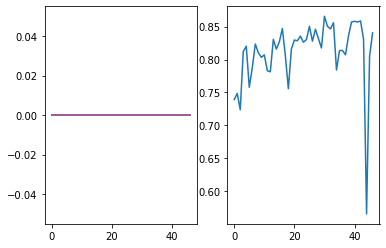

100%|██████████| 336/336 [00:40<00:00,  8.40it/s]


17.256714314222336 6.513619231060147


100%|██████████| 58/58 [00:02<00:00, 22.03it/s]


valid-f1: 0.8269385756798417

valid-precision: 0.8531367156936414

valid-recall: 0.8233829030125188

process: 47  loss: 475.12311828136444  train_correct: 0.9998136067101584 valid_loss 57.529099212570145  val_correct: 0.8317808219178082


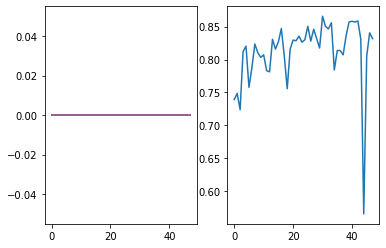

100%|██████████| 336/336 [00:39<00:00,  8.41it/s]


16.988802026957273 5.925330970436335


100%|██████████| 58/58 [00:02<00:00, 21.68it/s]


valid-f1: 0.8283270124111214

valid-precision: 0.8506784176053073

valid-recall: 0.8267475797956985

process: 48  loss: 469.87517750263214  train_correct: 0.9999068033550792 valid_loss 58.01194475335433  val_correct: 0.8323287671232876


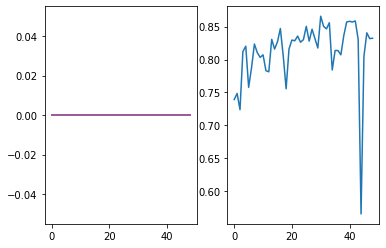

100%|██████████| 336/336 [00:39<00:00,  8.45it/s]


16.707668349146843 5.634688408114016


100%|██████████| 58/58 [00:03<00:00, 18.07it/s]


valid-f1: 0.8312813470252343

valid-precision: 0.8556157871795455

valid-recall: 0.8270938315605962

process: 49  loss: 465.35344445705414  train_correct: 0.9999068033550792 valid_loss 58.33018228924266  val_correct: 0.8345205479452055


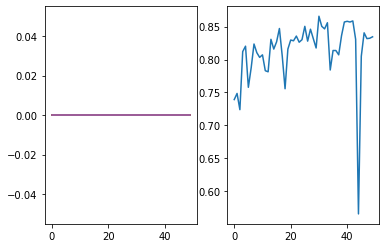

100%|██████████| 336/336 [00:39<00:00,  8.45it/s]


68.3765676766634 39.675872564315796


100%|██████████| 58/58 [00:02<00:00, 21.42it/s]


valid-f1: 0.7789858561599483

valid-precision: 0.8008215477278506

valid-recall: 0.7733397552153897

process: 0  loss: 3644.3135201931  train_correct: 0.6996272134203169 valid_loss 40.87166794395307  val_correct: 0.7890410958904109


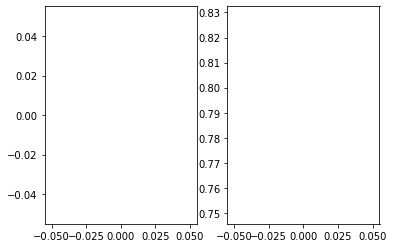

100%|██████████| 61/61 [00:02<00:00, 22.02it/s]


test-f1: 0.6696624723154784

test-precision: 0.7030414063511645

test-recall: 0.678634596989969

The model has been saved!!

The best val_acc is  0.7890410958904109 The best test_acc is  0.655746229849194


100%|██████████| 336/336 [00:39<00:00,  8.43it/s]


63.68807052075863 35.133020997047424


100%|██████████| 58/58 [00:02<00:00, 21.95it/s]


valid-f1: 0.7316723774547281

valid-precision: 0.7823213517948273

valid-recall: 0.7405110082950908

process: 1  loss: 1052.8063710927963  train_correct: 0.9687791239515378 valid_loss 51.91732681500798  val_correct: 0.7254794520547945


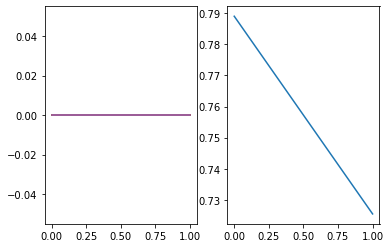

100%|██████████| 336/336 [00:39<00:00,  8.42it/s]


55.85371156036854 29.176686234772205


100%|██████████| 58/58 [00:02<00:00, 21.75it/s]


valid-f1: 0.7526345695167106

valid-precision: 0.7745504862726131

valid-recall: 0.7619244641219197

process: 2  loss: 793.4106075763702  train_correct: 0.9882572227399814 valid_loss 48.52083845229936  val_correct: 0.7643835616438356


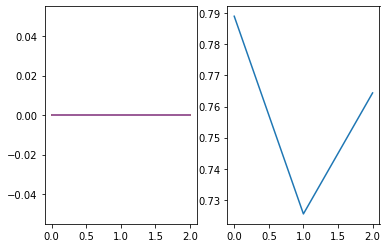

100%|██████████| 336/336 [00:39<00:00,  8.48it/s]


47.99518207460642 24.055589620023966


100%|██████████| 58/58 [00:02<00:00, 21.37it/s]


valid-f1: 0.8262492946123

valid-precision: 0.8455990648060252

valid-recall: 0.8179564536334383

process: 3  loss: 681.2039654254913  train_correct: 0.9958061509785647 valid_loss 36.68546401952926  val_correct: 0.8416438356164384


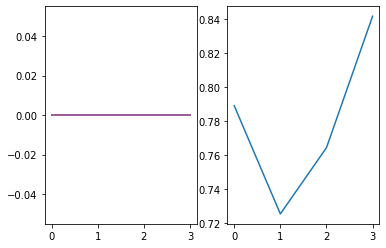

100%|██████████| 61/61 [00:02<00:00, 22.20it/s]


test-f1: 0.7627483485895318

test-precision: 0.7854639488838236

test-recall: 0.7592250489205281

The model has been saved!!

The best val_acc is  0.8416438356164384 The best test_acc is  0.750390015600624


100%|██████████| 336/336 [00:40<00:00,  8.39it/s]


41.26646602898836 19.86311148479581


100%|██████████| 58/58 [00:03<00:00, 18.18it/s]


valid-f1: 0.8071809389805626

valid-precision: 0.8329203295137223

valid-recall: 0.8148955005944429

process: 4  loss: 637.434620141983  train_correct: 0.9962721342031687 valid_loss 39.969056569646455  val_correct: 0.8208219178082192


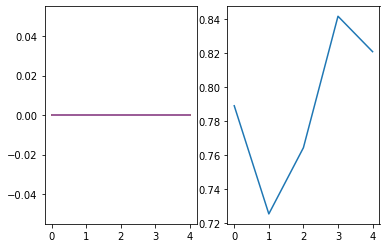

100%|██████████| 336/336 [00:39<00:00,  8.46it/s]


40.739427752792835 19.920465108007193


100%|██████████| 58/58 [00:02<00:00, 21.51it/s]


valid-f1: 0.7791560167041263

valid-precision: 0.7998788031898064

valid-recall: 0.7748103154898397

process: 5  loss: 740.9617136716843  train_correct: 0.9850885368126747 valid_loss 47.11675639360874  val_correct: 0.8


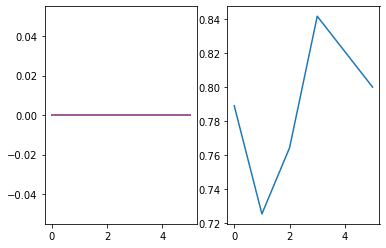

100%|██████████| 336/336 [00:39<00:00,  8.42it/s]


31.313837826251984 14.666831776499748


100%|██████████| 58/58 [00:02<00:00, 21.92it/s]


valid-f1: 0.8060773551827186

valid-precision: 0.835532650601361

valid-recall: 0.8052702659592319

process: 6  loss: 559.5564280152321  train_correct: 0.9993476234855545 valid_loss 43.83531471932838  val_correct: 0.8257534246575342


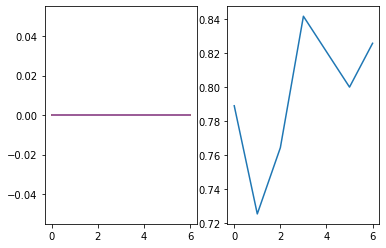

100%|██████████| 336/336 [00:39<00:00,  8.53it/s]


28.59718879312277 12.892255799844861


100%|██████████| 58/58 [00:02<00:00, 21.13it/s]


valid-f1: 0.7238352204024948

valid-precision: 0.7801043104155536

valid-recall: 0.7300769759260993

process: 7  loss: 647.344011425972  train_correct: 0.9903075489282386 valid_loss 57.24618773891416  val_correct: 0.7715068493150685


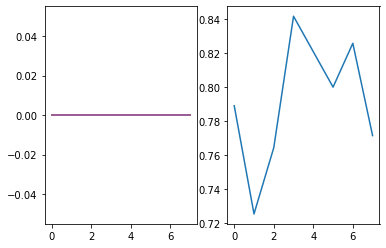

100%|██████████| 336/336 [00:39<00:00,  8.46it/s]


28.672480382025242 13.299335481598973


100%|██████████| 58/58 [00:02<00:00, 22.26it/s]


valid-f1: 0.7983094421600985

valid-precision: 0.8311247312364033

valid-recall: 0.7849916426672111

process: 8  loss: 664.0557786226273  train_correct: 0.990587138863001 valid_loss 42.35051997457413  val_correct: 0.8158904109589041


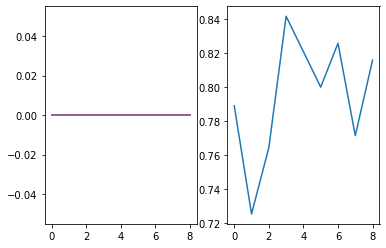

100%|██████████| 336/336 [00:39<00:00,  8.45it/s]


24.052213840186596 10.137155927717686


100%|██████████| 58/58 [00:02<00:00, 21.78it/s]


valid-f1: 0.8059619976763903

valid-precision: 0.8293666009221363

valid-recall: 0.7995473647363116

process: 9  loss: 530.9267381429672  train_correct: 0.9989748369058714 valid_loss 46.399111394369356  val_correct: 0.8186301369863014


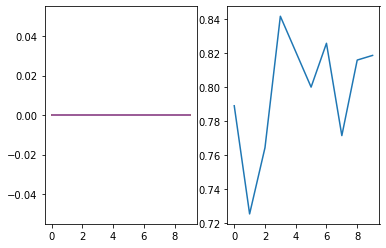

100%|██████████| 336/336 [00:39<00:00,  8.54it/s]


24.028240505605936 9.65129834227264


100%|██████████| 58/58 [00:02<00:00, 22.52it/s]


valid-f1: 0.7701354507036144

valid-precision: 0.8042079843751248

valid-recall: 0.7784741825185862

process: 10  loss: 611.4029983282089  train_correct: 0.9912395153774464 valid_loss 48.13143385761941  val_correct: 0.7978082191780822


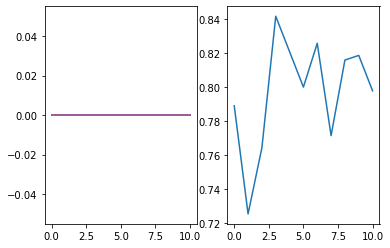

100%|██████████| 336/336 [00:39<00:00,  8.48it/s]


24.195106774568558 10.148689169436693


100%|██████████| 58/58 [00:02<00:00, 22.35it/s]


valid-f1: 0.8227676975526913

valid-precision: 0.8450652772145787

valid-recall: 0.8159313637126294

process: 11  loss: 605.1865829229355  train_correct: 0.992730661696179 valid_loss 44.290528533470024  val_correct: 0.8312328767123288


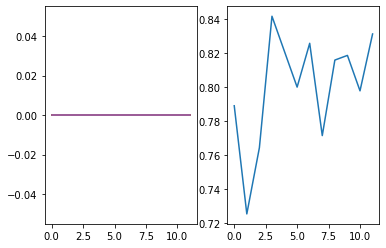

100%|██████████| 336/336 [00:39<00:00,  8.54it/s]


25.374094802886248 10.231548624113202


100%|██████████| 58/58 [00:02<00:00, 20.64it/s]


valid-f1: 0.8246149871257058

valid-precision: 0.84124152589824

valid-recall: 0.8189825650425652

process: 12  loss: 628.9034646749496  train_correct: 0.9910531220876049 valid_loss 46.53171665753598  val_correct: 0.8367123287671233


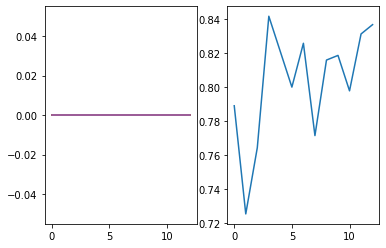

100%|██████████| 336/336 [00:39<00:00,  8.61it/s]


21.377733804285526 7.42077992670238


100%|██████████| 58/58 [00:02<00:00, 22.84it/s]


valid-f1: 0.8234941094166102

valid-precision: 0.8428436383008778

valid-recall: 0.8198374858259502

process: 13  loss: 499.39391791820526  train_correct: 0.9996272134203169 valid_loss 47.17770779415878  val_correct: 0.8361643835616438


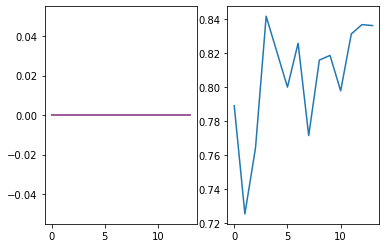

100%|██████████| 336/336 [00:39<00:00,  8.54it/s]


19.869626704603434 6.374457335099578


100%|██████████| 58/58 [00:02<00:00, 22.77it/s]


valid-f1: 0.8238427683887515

valid-precision: 0.8421770683446808

valid-recall: 0.8182410921988044

process: 14  loss: 486.5697864294052  train_correct: 0.9996272134203169 valid_loss 45.38753365301636  val_correct: 0.8361643835616438


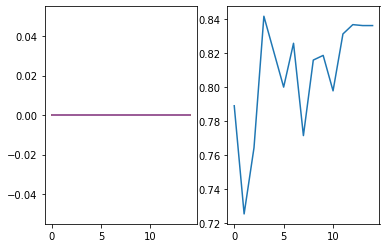

100%|██████████| 336/336 [00:38<00:00,  8.65it/s]


18.865544751286507 5.7031970378011465


100%|██████████| 58/58 [00:02<00:00, 21.93it/s]


valid-f1: 0.8216338154238597

valid-precision: 0.8402783257536575

valid-recall: 0.8162710293916682

process: 15  loss: 484.0343314409256  train_correct: 0.9997204100652376 valid_loss 45.78664465771453  val_correct: 0.8345205479452055


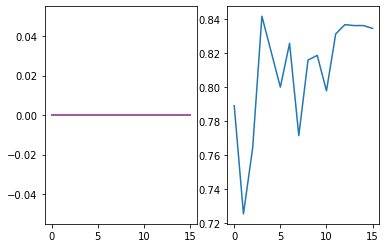

100%|██████████| 336/336 [00:39<00:00,  8.41it/s]


17.912804875522852 5.202204066328704


100%|██████████| 58/58 [00:02<00:00, 22.66it/s]


valid-f1: 0.8252771552973851

valid-precision: 0.8421306491848795

valid-recall: 0.8209057600112099

process: 16  loss: 481.755695104599  train_correct: 0.9997204100652376 valid_loss 45.82094764429348  val_correct: 0.8383561643835616


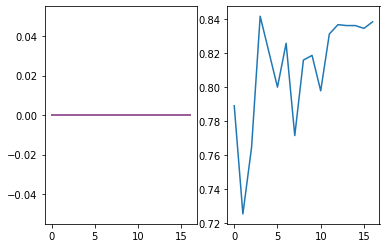

100%|██████████| 336/336 [00:39<00:00,  8.44it/s]


17.03905365243554 4.753691857680678


100%|██████████| 58/58 [00:02<00:00, 21.94it/s]


valid-f1: 0.8295250741845261

valid-precision: 0.8492981867821587

valid-recall: 0.8237430178496243

process: 17  loss: 478.1291204690933  train_correct: 0.9997204100652376 valid_loss 46.802046499956305  val_correct: 0.8438356164383561


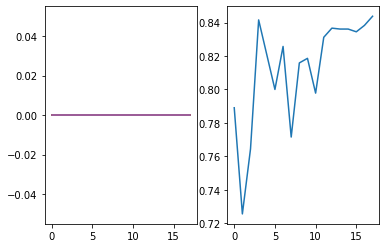

100%|██████████| 61/61 [00:02<00:00, 22.77it/s]


test-f1: 0.8126066294765867

test-precision: 0.8320392561583244

test-recall: 0.8156766489334014

The model has been saved!!

The best val_acc is  0.8438356164383561 The best test_acc is  0.8008320332813312


100%|██████████| 336/336 [00:38<00:00,  8.64it/s]


16.505056783556938 4.418254884891212


100%|██████████| 58/58 [00:02<00:00, 22.63it/s]


valid-f1: 0.8346061344928148

valid-precision: 0.8546817076978955

valid-recall: 0.8277100742241965

process: 18  loss: 475.2784080505371  train_correct: 0.9995340167753961 valid_loss 47.85381493043042  val_correct: 0.8482191780821918


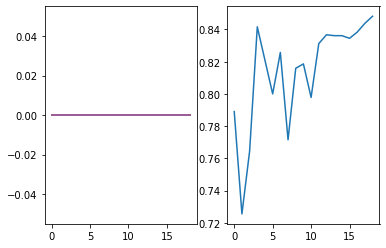

100%|██████████| 61/61 [00:02<00:00, 21.48it/s]


test-f1: 0.8076236839426757

test-precision: 0.8302161572832679

test-recall: 0.8122542424243825

The model has been saved!!

The best val_acc is  0.8482191780821918 The best test_acc is  0.7940717628705148


100%|██████████| 336/336 [00:39<00:00,  8.50it/s]


21.655839774757624 7.651283605024219


100%|██████████| 58/58 [00:02<00:00, 22.74it/s]


valid-f1: 0.7239156896636783

valid-precision: 0.8112644169745387

valid-recall: 0.7409388796155427

process: 19  loss: 732.4685584306717  train_correct: 0.9812674743709227 valid_loss 77.52674457755916  val_correct: 0.770958904109589


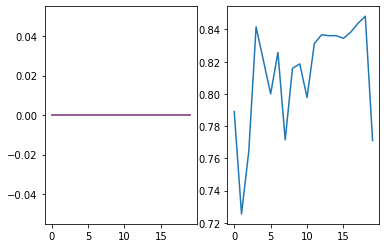

100%|██████████| 336/336 [00:40<00:00,  8.36it/s]


19.446202225983143 6.466520182788372


100%|██████████| 58/58 [00:02<00:00, 22.42it/s]


valid-f1: 0.8319462635376634

valid-precision: 0.8573136905222143

valid-recall: 0.8345866958339551

process: 20  loss: 556.3622643947601  train_correct: 0.9942218080149114 valid_loss 39.99007992839324  val_correct: 0.8482191780821918


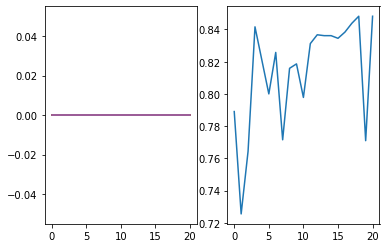

100%|██████████| 336/336 [00:39<00:00,  8.56it/s]


18.351041179150343 5.7008302584290504


100%|██████████| 58/58 [00:03<00:00, 18.69it/s]


valid-f1: 0.8259967811767621

valid-precision: 0.8628863057726047

valid-recall: 0.8185112654513625

process: 21  loss: 550.327537715435  train_correct: 0.9951537744641193 valid_loss 51.6711760254766  val_correct: 0.8405479452054795


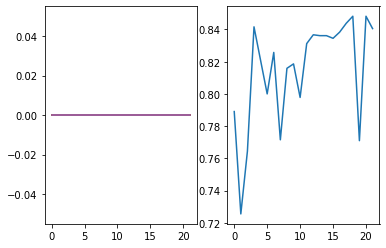

100%|██████████| 336/336 [00:39<00:00,  8.47it/s]


16.84621373936534 4.515739995054901


100%|██████████| 58/58 [00:02<00:00, 21.77it/s]


valid-f1: 0.8487286267849777

valid-precision: 0.8711565095938617

valid-recall: 0.8460392151769597

process: 22  loss: 481.4722439646721  train_correct: 0.9994408201304753 valid_loss 41.16814791157958  val_correct: 0.8613698630136987


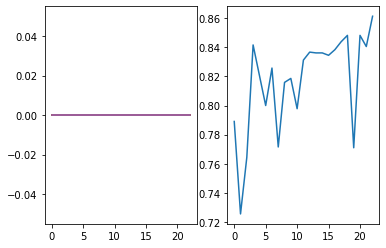

100%|██████████| 61/61 [00:02<00:00, 22.63it/s]


test-f1: 0.7905236085275339

test-precision: 0.8115985173422093

test-recall: 0.7895530688583972

The model has been saved!!

The best val_acc is  0.8613698630136987 The best test_acc is  0.7769110764430577


100%|██████████| 336/336 [00:39<00:00,  8.53it/s]


16.08990927040577 4.104606043547392


100%|██████████| 58/58 [00:02<00:00, 22.10it/s]


valid-f1: 0.8472115424075157

valid-precision: 0.8741122711944282

valid-recall: 0.8405407758488043

process: 23  loss: 470.0033060312271  train_correct: 0.9996272134203169 valid_loss 44.858216880201326  val_correct: 0.8586301369863014


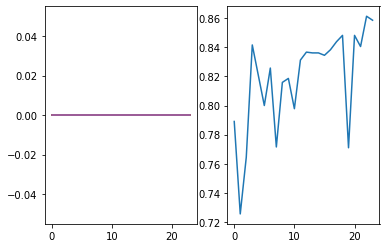

100%|██████████| 336/336 [00:39<00:00,  8.61it/s]


15.536725025624037 3.851628270931542


100%|██████████| 58/58 [00:02<00:00, 21.27it/s]


valid-f1: 0.8452241606674258

valid-precision: 0.8750401995957688

valid-recall: 0.8382639133071057

process: 24  loss: 466.9558424949646  train_correct: 0.9996272134203169 valid_loss 46.5882517927148  val_correct: 0.8564383561643836


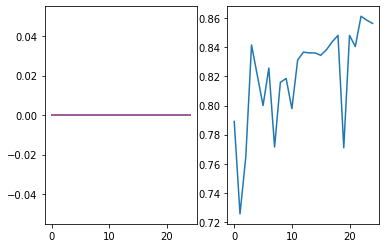

100%|██████████| 336/336 [00:39<00:00,  8.50it/s]


15.062851648777723 3.700755533762276


100%|██████████| 58/58 [00:02<00:00, 22.53it/s]


valid-f1: 0.8497085974706525

valid-precision: 0.8711198876837427

valid-recall: 0.8475671362127656

process: 25  loss: 463.594135761261  train_correct: 0.9997204100652376 valid_loss 43.786009214318256  val_correct: 0.8619178082191781


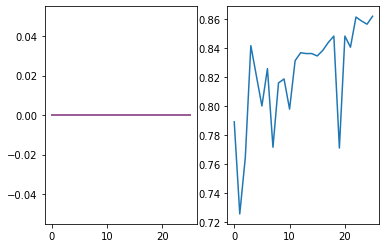

100%|██████████| 61/61 [00:02<00:00, 21.90it/s]


test-f1: 0.8259460856898085

test-precision: 0.8440140953153957

test-recall: 0.8248894939233675

The model has been saved!!

The best val_acc is  0.8619178082191781 The best test_acc is  0.8205928237129485


100%|██████████| 336/336 [00:39<00:00,  8.61it/s]


14.719118114560843 3.523620877414942


100%|██████████| 58/58 [00:03<00:00, 18.65it/s]


valid-f1: 0.8519274590758308

valid-precision: 0.8759038748745122

valid-recall: 0.8484420062889898

process: 26  loss: 460.81015050411224  train_correct: 0.9999068033550792 valid_loss 43.83435916518556  val_correct: 0.8635616438356164


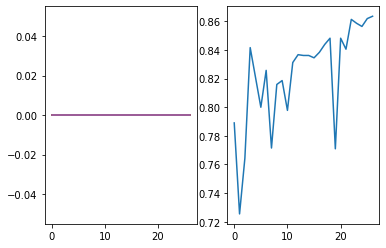

100%|██████████| 61/61 [00:03<00:00, 17.93it/s]


test-f1: 0.8328883337791726

test-precision: 0.854041060803705

test-recall: 0.8293662242621875

The model has been saved!!

The best val_acc is  0.8635616438356164 The best test_acc is  0.8257930317212688


100%|██████████| 336/336 [00:38<00:00,  8.62it/s]


14.214643619954586 3.367257106117904


100%|██████████| 58/58 [00:02<00:00, 22.04it/s]


valid-f1: 0.8517082883571895

valid-precision: 0.8756992736748224

valid-recall: 0.8489880562662175

process: 27  loss: 458.0995547771454  train_correct: 1.0 valid_loss 44.43921474870808  val_correct: 0.8646575342465753


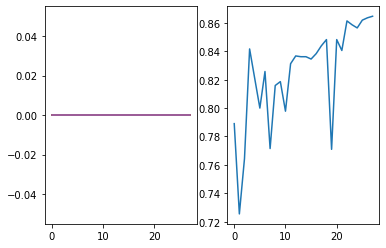

100%|██████████| 61/61 [00:02<00:00, 22.55it/s]


test-f1: 0.8331017909795309

test-precision: 0.8505851181835343

test-recall: 0.8312277505691703

The model has been saved!!

The best val_acc is  0.8646575342465753 The best test_acc is  0.8257930317212688


100%|██████████| 336/336 [00:39<00:00,  8.42it/s]


13.852708794176579 3.288835004903376


100%|██████████| 58/58 [00:02<00:00, 22.54it/s]


valid-f1: 0.8489653714856498

valid-precision: 0.8766621725430754

valid-recall: 0.8441790856418004

process: 28  loss: 457.3959985971451  train_correct: 1.0 valid_loss 46.26833978578907  val_correct: 0.8613698630136987


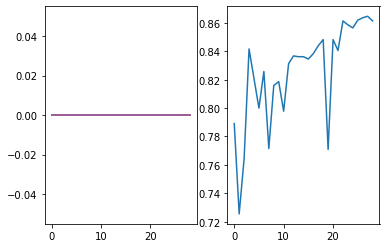

100%|██████████| 336/336 [00:38<00:00,  8.62it/s]


13.487713798880577 3.2575506763532758


100%|██████████| 58/58 [00:03<00:00, 19.20it/s]


valid-f1: 0.8525741148452146

valid-precision: 0.8798926139263742

valid-recall: 0.8481560167587368

process: 29  loss: 455.82045727968216  train_correct: 1.0 valid_loss 47.96344883196389  val_correct: 0.8641095890410959


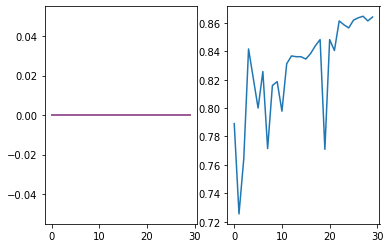

100%|██████████| 336/336 [00:39<00:00,  8.55it/s]


14.097132306545973 3.753119360655546


100%|██████████| 58/58 [00:02<00:00, 22.29it/s]


valid-f1: 0.6497017504260202

valid-precision: 0.7447908199299272

valid-recall: 0.6687747079956614

process: 30  loss: 543.5263023376465  train_correct: 0.9938490214352284 valid_loss 75.29213043540949  val_correct: 0.7084931506849315


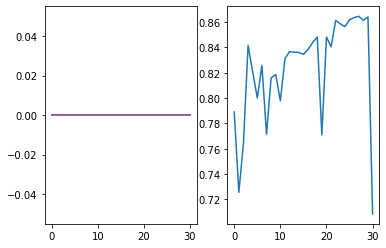

100%|██████████| 336/336 [00:39<00:00,  8.54it/s]


20.07638405263424 7.394082476384938


100%|██████████| 58/58 [00:02<00:00, 22.55it/s]


valid-f1: 0.8474656209335916

valid-precision: 0.8561255323901895

valid-recall: 0.848577070878957

process: 31  loss: 717.5895946621895  train_correct: 0.9821994408201304 valid_loss 39.20483438213705  val_correct: 0.8526027397260274


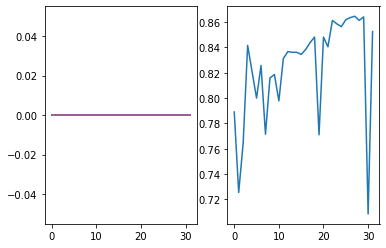

100%|██████████| 336/336 [00:39<00:00,  8.58it/s]


16.302455499768257 4.561541503295302


100%|██████████| 58/58 [00:02<00:00, 22.72it/s]


valid-f1: 0.8195543923512398

valid-precision: 0.8541898415209292

valid-recall: 0.806735902567308

process: 32  loss: 507.66266494989395  train_correct: 0.9963653308480894 valid_loss 54.50468900336182  val_correct: 0.8334246575342465


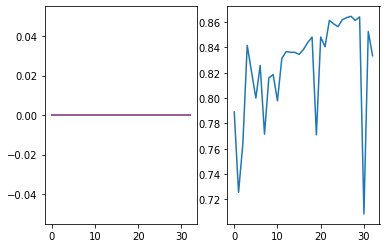

100%|██████████| 336/336 [00:39<00:00,  8.52it/s]


15.140106189996004 3.9568007104098797


100%|██████████| 58/58 [00:02<00:00, 22.72it/s]


valid-f1: 0.82418732629777

valid-precision: 0.8454975017540107

valid-recall: 0.8278331666505636

process: 33  loss: 492.2562236189842  train_correct: 0.9977632805219012 valid_loss 49.738609840867866  val_correct: 0.8394520547945206


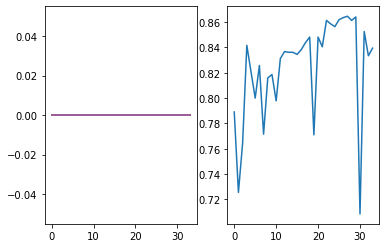

100%|██████████| 336/336 [00:39<00:00,  8.51it/s]


14.518377400934696 3.700073678046465


100%|██████████| 58/58 [00:02<00:00, 20.73it/s]


valid-f1: 0.8422654174970952

valid-precision: 0.8496605744430811

valid-recall: 0.842765593540299

process: 34  loss: 482.07147973775864  train_correct: 0.9986020503261882 valid_loss 42.56250523862036  val_correct: 0.8536986301369863


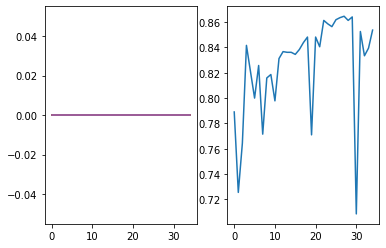

100%|██████████| 336/336 [00:39<00:00,  8.60it/s]


13.832996863871813 3.3761106953024864


100%|██████████| 58/58 [00:02<00:00, 22.00it/s]


valid-f1: 0.83462816507626

valid-precision: 0.8533003843016992

valid-recall: 0.8317575872039796

process: 35  loss: 460.08001375198364  train_correct: 1.0 valid_loss 49.23670953598412  val_correct: 0.8487671232876712


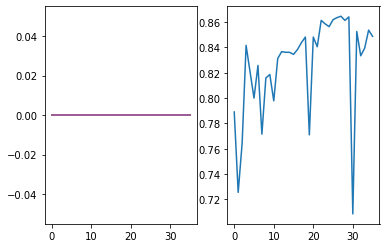

100%|██████████| 336/336 [00:39<00:00,  8.44it/s]


13.545790046453476 3.372640335932374


100%|██████████| 58/58 [00:02<00:00, 21.78it/s]


valid-f1: 0.8076914363725237

valid-precision: 0.8282356160070931

valid-recall: 0.802609065612271

process: 36  loss: 465.34200060367584  train_correct: 0.9992544268406337 valid_loss 62.51413287946548  val_correct: 0.8235616438356165


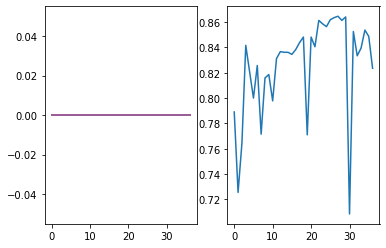

100%|██████████| 336/336 [00:38<00:00,  8.63it/s]


16.540316220372915 4.8671842543408275


100%|██████████| 58/58 [00:02<00:00, 22.53it/s]


valid-f1: 0.8377723204864793

valid-precision: 0.8681781872122117

valid-recall: 0.8378924800062346

process: 37  loss: 646.9946217536926  train_correct: 0.9876048462255359 valid_loss 47.42310419874411  val_correct: 0.8580821917808219


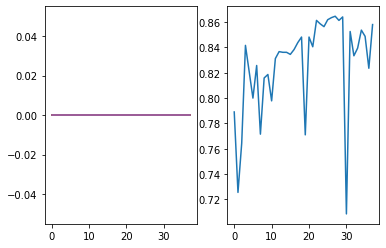

100%|██████████| 336/336 [00:40<00:00,  8.39it/s]


14.544688057154417 3.6964040603488684


100%|██████████| 58/58 [00:02<00:00, 22.66it/s]


valid-f1: 0.8386619899996708

valid-precision: 0.8707447192871911

valid-recall: 0.8338957877916802

process: 38  loss: 491.4471193552017  train_correct: 0.9984156570363467 valid_loss 48.18702867887259  val_correct: 0.852054794520548


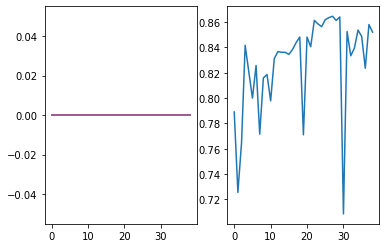

100%|██████████| 336/336 [00:39<00:00,  8.50it/s]


13.69803000614047 3.3402785304933786


100%|██████████| 58/58 [00:02<00:00, 22.70it/s]


valid-f1: 0.8403013583756851

valid-precision: 0.8662683277252748

valid-recall: 0.8373534748107325

process: 39  loss: 459.0419809818268  train_correct: 1.0 valid_loss 46.1633799066758  val_correct: 0.8542465753424657


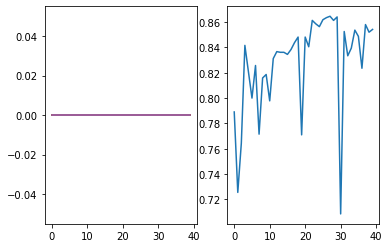

100%|██████████| 336/336 [00:38<00:00,  8.63it/s]


13.106805201619864 3.27874705940485


100%|██████████| 58/58 [00:02<00:00, 22.78it/s]


valid-f1: 0.8405897440284928

valid-precision: 0.8681060402669523

valid-recall: 0.8367687051559118

process: 40  loss: 455.5944967865944  train_correct: 1.0 valid_loss 46.8694117831983  val_correct: 0.8542465753424657


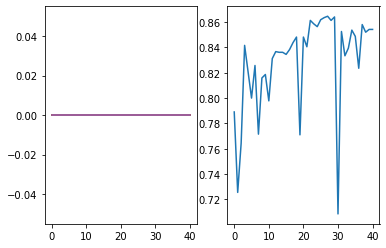

100%|██████████| 336/336 [00:39<00:00,  8.47it/s]


12.762601014226675 3.248246925882995


100%|██████████| 58/58 [00:02<00:00, 22.41it/s]


valid-f1: 0.8414396169781757

valid-precision: 0.869176992173698

valid-recall: 0.8360179162605526

process: 41  loss: 455.99744391441345  train_correct: 1.0 valid_loss 46.80112175930299  val_correct: 0.8536986301369863


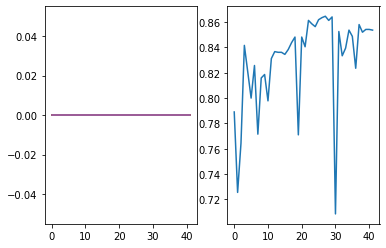

100%|██████████| 336/336 [00:39<00:00,  8.59it/s]


12.47180850803852 3.2351758386939764


100%|██████████| 58/58 [00:03<00:00, 17.81it/s]


valid-f1: 0.8409250350996371

valid-precision: 0.8687487200083883

valid-recall: 0.8345128029161877

process: 42  loss: 452.44428730010986  train_correct: 1.0 valid_loss 47.21506647577098  val_correct: 0.8531506849315068


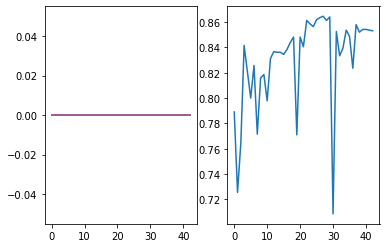

100%|██████████| 336/336 [00:38<00:00,  8.62it/s]


12.22773952037096 3.2367790834978223


100%|██████████| 58/58 [00:02<00:00, 21.91it/s]


valid-f1: 0.8417720115675549

valid-precision: 0.8695537752484348

valid-recall: 0.8351439516554511

process: 43  loss: 451.3643379807472  train_correct: 1.0 valid_loss 47.60295077346382  val_correct: 0.8536986301369863


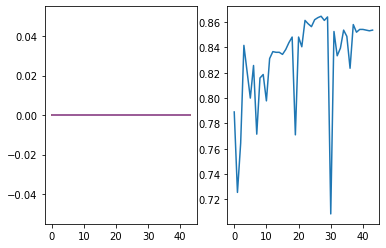

100%|██████████| 336/336 [00:39<00:00,  8.45it/s]


11.966611195355654 3.2257221108302474


100%|██████████| 58/58 [00:02<00:00, 22.78it/s]


valid-f1: 0.8457251333043608

valid-precision: 0.8723306059460162

valid-recall: 0.8381267944660085

process: 44  loss: 453.0970144867897  train_correct: 1.0 valid_loss 48.1513420143674  val_correct: 0.856986301369863


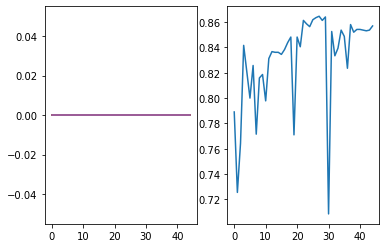

100%|██████████| 336/336 [00:38<00:00,  8.63it/s]


11.683322928845882 3.1891515906900167


100%|██████████| 58/58 [00:02<00:00, 22.80it/s]


valid-f1: 0.8493229511206655

valid-precision: 0.8755538894624328

valid-recall: 0.841454980507609

process: 45  loss: 452.16948330402374  train_correct: 1.0 valid_loss 48.53188264318487  val_correct: 0.8597260273972602


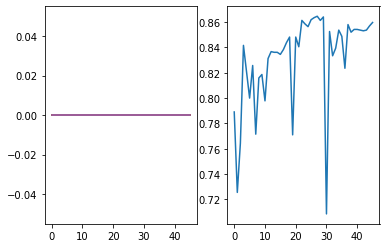

100%|██████████| 336/336 [00:39<00:00,  8.46it/s]


11.493602149188519 3.2352828765287995


100%|██████████| 58/58 [00:02<00:00, 21.44it/s]


valid-f1: 0.8546643952687981

valid-precision: 0.8771461561642784

valid-recall: 0.8467699462348675

process: 46  loss: 451.3964392542839  train_correct: 1.0 valid_loss 47.77123063357067  val_correct: 0.8646575342465753


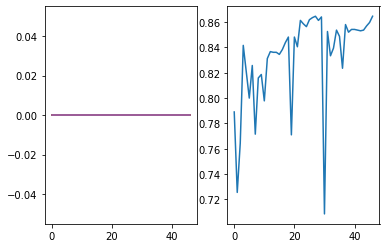

100%|██████████| 336/336 [00:39<00:00,  8.45it/s]


11.171299990266562 3.235739814117551


100%|██████████| 58/58 [00:02<00:00, 22.52it/s]


valid-f1: 0.8518177680747222

valid-precision: 0.8766096020315846

valid-recall: 0.8437433386960649

process: 47  loss: 449.348770737648  train_correct: 1.0 valid_loss 48.75487908016885  val_correct: 0.8619178082191781


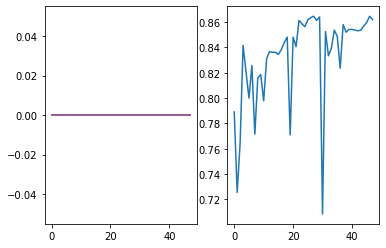

100%|██████████| 336/336 [00:38<00:00,  8.68it/s]


10.86978679895401 3.2421657843515277


100%|██████████| 58/58 [00:02<00:00, 22.22it/s]


valid-f1: 0.8481579533355001

valid-precision: 0.8751202734847224

valid-recall: 0.8404383448045041

process: 48  loss: 451.7749609351158  train_correct: 1.0 valid_loss 49.42351749901263  val_correct: 0.8597260273972602


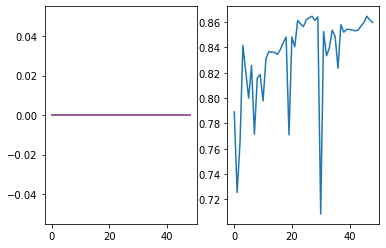

100%|██████████| 336/336 [00:39<00:00,  8.47it/s]


10.593904646113515 3.239365067332983


100%|██████████| 58/58 [00:02<00:00, 20.51it/s]


valid-f1: 0.851674412980759

valid-precision: 0.8773630502746335

valid-recall: 0.843049525485317

process: 49  loss: 448.93593549728394  train_correct: 1.0 valid_loss 50.12742663987137  val_correct: 0.8619178082191781


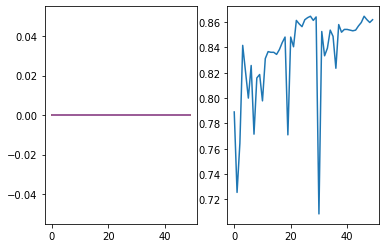

当前alphas [1, 1, 1, 10]

[0.8547945205479452, 0.856986301369863, 0.8487671232876712, 0.8657534246575342, 0.8646575342465753]

0.8581917808219177

===

[0.8472494644630031, 0.8439652356470667, 0.8431151947604606, 0.8600183800163558, 0.8517082883571895]

0.8492113126488151

===

[0.8371994067866492, 0.8417873979906159, 0.8446374113033952, 0.854693351526975, 0.8489880562662175]

0.8454611247747705

===

[0.8828396629625663, 0.8662283858009138, 0.8563653876187585, 0.8817908881936635, 0.8756992736748224]

0.8725847196501448

===

[0.8268330733229329, 0.7987519500780031, 0.8101924076963078, 0.7935517420696828, 0.8257930317212688]

0.8110244409776393

===

[0.8379555393387272, 0.8052413019859637, 0.8086686570846207, 0.7938168444191618, 0.8331017909795309]

0.8157568267616009

===

[0.8356235562277508, 0.8201875459249589, 0.8096185195160821, 0.8039476627287572, 0.8312277505691703]

0.8201210069933438

===

[0.8493985668010327, 0.8059198786131241, 0.8370501847848979, 0.8104520914777267, 0.850585

In [14]:
def _freeze_norm_stats(net):
    for m in net.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()
lr = 0.0001
batch_size = 32
train_transform = transforms.Compose(
    [
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])
test_transform = transforms.Compose(
    [
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])



for alphas in [[1,1,1,10]]:
    alpha1,alpha2,alpha3,alpha4 = alphas
    average_valid_results = []
    average_f1_results = []
    average_recall_results = []
    average_precision_results = []

    average_test_results = []
    average_f1_results_test = []
    average_recall_results_test = []
    average_precision_results_test = []
    for seed in [3,2,4,1,0]:
        lrcounter = 0
        seed4batch = seed
        T = 2
        cudnn.benchmark = False
        cudnn.deterministic = True
        torch.manual_seed(seed) 
        torch.cuda.manual_seed(seed)  
        torch.cuda.manual_seed_all(seed) 
        random.seed(seed)
        np.random.seed(seed)



        def get_num_correct(out, labels):  
            return out.argmax(dim=1).eq(labels).sum().item()

        
        
        model = MSFIN()
        model = model.cuda()
        

        optimizer = torch.optim.Adam(model.parameters(),lr=lr)
        
        epoch_num = 50
        maxval=0
        maxtest_followmaxval=0
        maxf1_followmaxval = 0
        maxrecall_followmaxval = 0
        maxprecision_followmaxval = 0
        
        maxf1_followmaxval_test = 0
        maxrecall_followmaxval_test = 0
        maxprecision_followmaxval_test = 0
        
        
        finaltestlabel_followmaxval = []
        finaltestlabel_pred_followmaxval = []

        earlystopcounter = 0

        T = 10
        minvalidloss = 99999

        val_loss_curve = []
        val_acc_curve = []
        test_acc_curve = []
        
        train_acc_1 = []
        train_acc_2 = []
        train_acc_3 = []
        train_acc_4 = []
        train_acc_5 = []
        
        idxlist = [i for i in range(train_len)]
        
        for epoch in range(epoch_num):
            np.random.seed(seed)
            np.random.shuffle(idxlist)
            
            total_loss=0
            total_loss1=0
            total_loss3=0
            valid_loss = 0
            train_correct=0
            test_correct = 0
            val_correct=0
            model.train()
            model.apply(_freeze_norm_stats)
            
            train_counter = 0
            
            train_correct1 = 0
            train_correct2 = 0
            train_correct3 = 0
            train_correct4 = 0
            train_correct5 = 0
            
            def getBatch(len_dataset,batch_size):
                batch_num = len_dataset // batch_size
                batch_res = len_dataset % batch_size

                if batch_res>0:
                    batchlist = [batch_size] * batch_num + [batch_res]
                else:
                    batchlist = [batch_size] * batch_num
                return batchlist
            train_batch_list = getBatch(train_len,batch_size)
            
            for idx,b in enumerate(tqdm(train_batch_list)):
                start = 0+sum(train_batch_list[:idx])
                end = 0+sum(train_batch_list[:idx+1])
                batchidxlist = idxlist[start:end]
                
            
                x = []
                y = []
                y2 = []
                for image_inbatch_id in batchidxlist:
                    d = trainset[image_inbatch_id]
                    x.append(transforms.ToTensor()(d[0]))
                    y.append(d[1])
                    y2.append(d[2])
                
                images = torch.stack(x,0).cuda()
                
                
                labels = torch.LongTensor(y).cuda()
                labels2 = torch.LongTensor(y2).cuda()

                mask = labels2 >=28
                labels2[mask] = labels2[mask] - 4
                
                images = train_transform(images)
                
                preds,loss1,co,loss3 = model(images)

                optimizer.zero_grad()


                colabel = labels.unsqueeze(0) == labels.unsqueeze(1)
                colabel = colabel.float()
                
                if colabel.size(0)>0:
                    loss2 = F.kl_div(F.log_softmax(co,-1),colabel / colabel.sum(-1,True),reduction='batchmean')
                else:
                    loss2 = 0

                loss = loss1 * alpha1
                loss = loss + loss2 * alpha2
                loss = loss + loss3 * alpha3
                loss = loss + F.cross_entropy(preds,labels) * alpha4



                loss.backward()
                optimizer.step()
    
                
                total_loss+=loss.item()
                total_loss1+=loss1.item()
                total_loss3+=loss3.item()
                train_correct+=get_num_correct(preds,labels)

            print(total_loss1,total_loss3)
            
            valid_preds = []
            valid_labels = []
                
            model.eval()
            with torch.no_grad():
                validxlist = [i for i in range(valid_len)]
                valid_batch_list = getBatch(valid_len,batch_size)
                
                for idx,b in enumerate(tqdm(valid_batch_list)):
                    start = 0+sum(valid_batch_list[:idx])
                    end = 0+sum(valid_batch_list[:idx+1])
                    batchidxlist = validxlist[start:end]

                    x = []
                    y = []
                    y2 = []
                    for image_inbatch_id in batchidxlist:
                        
                        d = validset[image_inbatch_id]
                        
                        x.append(transforms.ToTensor()(d[0]))
                        y.append(d[1])
                        y2.append(d[2])

                    images = torch.stack(x,0).cuda()
                    labels = torch.LongTensor(y).cuda()
                    images = test_transform(images)

                    preds,loss,_,_ = model(images)

                    
                    loss = F.cross_entropy(preds,labels)
                    
                    valid_loss+=loss.item()
                    val_correct+=get_num_correct(preds,labels)
                    
                    valid_preds += preds.argmax(-1).cpu().numpy().tolist()
                    valid_labels += y
                
            F1=f1_score(valid_labels,valid_preds,average="macro")
            print("valid-f1:",F1)
            precision=precision_score(valid_labels,valid_preds,average="macro")
            print("valid-precision:",precision)
            recall=recall_score(valid_labels,valid_preds,average="macro")
            print("valid-recall:",recall)
            
            print('process:',epoch," loss:",total_loss," train_correct:",train_correct/train_len,'valid_loss',valid_loss," val_correct:",val_correct/valid_len)
            train_acc = train_correct/train_len
            val_acc=val_correct/valid_len
            
            train_acc_1.append(train_correct1/train_all)
            train_acc_2.append(train_correct2/train_all)
            train_acc_3.append(train_correct3/train_all)
            train_acc_4.append(train_correct4/train_all)
            train_acc_5.append(train_correct5/train_all)
            val_loss_curve.append(valid_loss)
            val_acc_curve.append(val_acc)
            
            x = range(len(val_loss_curve))

            
            plt.figure()
            plt.subplot(1, 2, 1) 
            plt.plot(x, train_acc_1)
            plt.plot(x, train_acc_2)
            plt.plot(x, train_acc_3)
            plt.plot(x, train_acc_4)
            plt.plot(x, train_acc_5)

            plt.subplot(1, 2, 2)
            plt.plot(x, val_acc_curve)


            plt.show()
            
            
            if val_acc > maxval:
                test_correct = 0
                test_loss = 0
                test_preds = []
                test_labels = []
                model.eval()
                with torch.no_grad():
                    testlist = [i for i in range(test_len)]
                    test_batch_list = getBatch(test_len,batch_size)

                    for idx,b in enumerate(tqdm(test_batch_list)):
                        start = 0+sum(test_batch_list[:idx])
                        end = 0+sum(test_batch_list[:idx+1])
                        batchidxlist = testlist[start:end]

                        x = []
                        y = []
                        y2 = []
                        for image_inbatch_id in batchidxlist:
                            
                            d = testset[image_inbatch_id]
                            
                            x.append(transforms.ToTensor()(d[0]))
                            y.append(d[1])
                            y2.append(d[2])

                        images = torch.stack(x,0).cuda()
                        labels = torch.LongTensor(y).cuda()
                        
                        images = test_transform(images)

                        preds,loss,_,_ = model(images)

                        
                        loss = F.cross_entropy(preds,labels)

                        test_loss+=loss.item()
                        test_correct+=get_num_correct(preds,labels)
                        
                        test_preds += preds.argmax(-1).cpu().numpy().tolist()
                        test_labels += y
                
                test_acc = test_correct / test_len
                testF1=f1_score(test_labels,test_preds,average="macro")
                print("test-f1:",testF1)
                testprecision=precision_score(test_labels,test_preds,average="macro")
                print("test-precision:",testprecision)
                testrecall=recall_score(test_labels,test_preds,average="macro")
                print("test-recall:",testrecall)
                
                maxval = val_acc
                maxf1_followmaxval = F1
                maxrecall_followmaxval = recall
                maxprecision_followmaxval = precision
                
                maxf1_followmaxval_test = testF1
                maxrecall_followmaxval_test = testrecall
                maxprecision_followmaxval_test = testprecision
                best_test_acc = test_acc
                
                earlystopcounter = 0
                torch.save(model.state_dict(), 'best'+str(seed)+'.pkl')
                print('The model has been saved!!')
                print('The best val_acc is ',maxval,'The best test_acc is ',best_test_acc)
            
        average_valid_results.append(maxval)
        average_f1_results.append(maxf1_followmaxval)
        average_recall_results.append(maxrecall_followmaxval)
        average_precision_results.append(maxprecision_followmaxval)
        
        average_test_results.append(best_test_acc)
        average_f1_results_test.append(maxf1_followmaxval_test)
        average_recall_results_test.append(maxrecall_followmaxval_test)
        average_precision_results_test.append(maxprecision_followmaxval_test)

    print('当前alphas',alphas) #check current alphas
    def summary(average_valid_results):
        print(average_valid_results)
        print(sum(average_valid_results)/len(average_valid_results))
        print('===')

    summary(average_valid_results)
    summary(average_f1_results)
    summary(average_recall_results)
    summary(average_precision_results)

    summary(average_test_results)
    summary(average_f1_results_test)
    summary(average_recall_results_test)
    summary(average_precision_results_test)
